In [ ]:
#TODO import
import tensorflow as tf
import numpy as np
import cv2 as cv2

import matplotlib.pyplot as plt
%matplotlib inline

import os

In [6]:
#TODO Load CSV
# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

tfilename = './SampleData/emnist-bymerge-train.csv'
raw_data = open(tfilename, 'rt')
data = np.loadtxt(raw_data, delimiter=',', skiprows=500000)
model_name = "emnist"
print(data.shape)

# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

eval_file = './SampleData/emnist-bymerge-test.csv'
eval_raw_data = open(eval_file, 'rt')
eval_data = np.loadtxt(eval_raw_data, delimiter=',')
print(eval_data.shape)

# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

(197932, 785)


(116323, 785)


In [7]:



# testletter = data[0][:]
# label = testletter[0]
# print(label)
# letterimage = np.reshape(testletter[1:], (28,28))
# letter_part = np.transpose(letterimage, [1, 0])
# plt.matshow(letter_part, cmap='gray')
# plt.show()


In [8]:
#TODO Process Training Data
image_height = 28
image_width = 28

color_channels = 1
print("Train data:")
train_data = data[:, 1:]
print(train_data.shape)
train_labels = data[:, 0]
print(train_labels.shape)

print("Eval data:")
# print(eval_data.shape)
eval_imgs = eval_data[:, 1:]
print(eval_imgs.shape)
eval_labels = eval_data[:, 0]
print(eval_labels.shape)



def process_data(indata):
    reshaped = np.reshape(indata, (-1, 28, 28, 1))
    return np.transpose(reshaped, [0,2,1,3])
    # return reshaped

print("Reshaped:")

train_data = process_data(train_data)
print("Train: "+ str(train_data.shape))

eval_imgs = process_data(eval_imgs)
print("Eval: " + str(eval_imgs.shape))

# plt.matshow(eval_imgs[27,:,:,0], cmap='gray')



Train data:
(197932, 784)
(197932,)
Eval data:
(116323, 784)
(116323,)
Reshaped:
Train: (197932, 28, 28, 1)
Eval: (116323, 28, 28, 1)


In [13]:
#NN
class ConvNet:
    def __init__(self, image_height, image_width, channels, num_classes):
         
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
         
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
         
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
         
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=128, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)

        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
         
        flattened_pooling = tf.layers.flatten(pooling_layer_1)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        dropout = tf.layers.dropout(dense_layer, rate=0.6, training=True)
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
         
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
         
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
         
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)     
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
         
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

In [14]:

# TODO: initialize variables
training_steps = 10000000
batch_size = 512

path = "./" + model_name + "-cnn/"
 
load_checkpoint = True
performance_graph = np.array([])

In [15]:

tf.reset_default_graph()
 
dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()
 
dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()
 
cnn = ConvNet(image_height, image_width, color_channels, 47)
 
saver = tf.train.Saver(max_to_keep=2)
 
if not os.path.exists(path):
    os.makedirs(path)
     
with tf.Session() as sess:
     
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
     
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
         
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
         
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
         
        if step % 100 == 0:
            performance_graph=np.append(performance_graph, sess.run(cnn.accuracy))
                                          
        if step % 100 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
             
            print("Accuracy at step " + str(step) + ": " + str(current_acc * 100))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
         
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)
    # print(batch_inputs.shape)
    # print(batch_labels[9])
    # plt.matshow(batch_inputs[9,:,:,0], cmap='gray')
    


(?, 28, 28, 1)
(?, 28, 28, 64)
(?, 14, 14, 64)
(?, 14, 14, 128)
(?, 7, 7, 128)
(?, 1024)
(?, 47)


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-4999


Accuracy at step 100: 92.8720593452
Saving checkpoint


Accuracy at step 200: 92.8754687309
Saving checkpoint


Accuracy at step 300: 92.9246246815
Saving checkpoint


Accuracy at step 400: 92.8937077522
Saving checkpoint


Accuracy at step 500: 92.8642213345
Saving checkpoint


Accuracy at step 600: 92.8832530975
Saving checkpoint


Accuracy at step 700: 92.8594946861
Saving checkpoint


Accuracy at step 800: 92.8447961807
Saving checkpoint


Accuracy at step 900: 92.8592205048
Saving checkpoint


Accuracy at step 1000: 92.8545475006
Saving checkpoint


Accuracy at step 1100: 92.8683042526
Saving checkpoint


Accuracy at step 1200: 92.8564667702
Saving checkpoint


Accuracy at step 1300: 92.8521811962
Saving checkpoint


Accuracy at step 1400: 92.8496301174
Saving checkpoint


Accuracy at step 1500: 92.8556144238
Saving checkpoint


Accuracy at step 1600: 92.860352993
Saving checkpoint


Accuracy at step 1700: 92.8607523441
Saving checkpoint


Accuracy at step 1800: 92.8599178791
Saving checkpoint


Accuracy at step 1900: 92.851048708
Saving checkpoint


Accuracy at step 2000: 92.8599476814
Saving checkpoint


Accuracy at step 2100: 92.8636431694
Saving checkpoint


Accuracy at step 2200: 92.8657591343
Saving checkpoint


Accuracy at step 2300: 92.8643763065
Saving checkpoint


Accuracy at step 2400: 92.8601682186
Saving checkpoint


Accuracy at step 2500: 92.8506016731
Saving checkpoint


Accuracy at step 2600: 92.843568325
Saving checkpoint


Accuracy at step 2700: 92.8461074829
Saving checkpoint


Accuracy at step 2800: 92.844825983
Saving checkpoint


Accuracy at step 2900: 92.8464055061
Saving checkpoint


Accuracy at step 3000: 92.8519248962
Saving checkpoint


Accuracy at step 3100: 92.8476750851
Saving checkpoint


Accuracy at step 3200: 92.8512811661
Saving checkpoint


Accuracy at step 3300: 92.8488612175
Saving checkpoint


Accuracy at step 3400: 92.8489387035
Saving checkpoint


Accuracy at step 3500: 92.8467154503
Saving checkpoint


Accuracy at step 3600: 92.8452730179
Saving checkpoint


Accuracy at step 3700: 92.8441762924
Saving checkpoint


Accuracy at step 3800: 92.8502857685
Saving checkpoint


Accuracy at step 3900: 92.8505599499
Saving checkpoint


Accuracy at step 4000: 92.850291729
Saving checkpoint


Accuracy at step 4100: 92.8478956223
Saving checkpoint


Accuracy at step 4200: 92.8479790688
Saving checkpoint


Accuracy at step 4300: 92.8497374058
Saving checkpoint


Accuracy at step 4400: 92.8545773029
Saving checkpoint


Accuracy at step 4500: 92.8549051285
Saving checkpoint


Accuracy at step 4600: 92.8523242474
Saving checkpoint


Accuracy at step 4700: 92.8523421288
Saving checkpoint


Accuracy at step 4800: 92.8529381752
Saving checkpoint


Accuracy at step 4900: 92.8537487984
Saving checkpoint


Accuracy at step 5000: 92.852216959
Saving checkpoint


Accuracy at step 5100: 92.8539216518
Saving checkpoint


Accuracy at step 5200: 92.8546667099
Saving checkpoint


Accuracy at step 5300: 92.8547561169
Saving checkpoint


Accuracy at step 5400: 92.853140831
Saving checkpoint


Accuracy at step 5500: 92.854809761
Saving checkpoint


Accuracy at step 5600: 92.8551018238
Saving checkpoint


Accuracy at step 5700: 92.8515791893
Saving checkpoint


Accuracy at step 5800: 92.8530931473
Saving checkpoint


Accuracy at step 5900: 92.853063345
Saving checkpoint


Accuracy at step 6000: 92.8503632545
Saving checkpoint


Accuracy at step 6100: 92.8528547287
Saving checkpoint


Accuracy at step 6200: 92.8539931774
Saving checkpoint


Accuracy at step 6300: 92.8588271141
Saving checkpoint


Accuracy at step 6400: 92.8560853004
Saving checkpoint


Accuracy at step 6500: 92.8563773632
Saving checkpoint


Accuracy at step 6600: 92.8565382957
Saving checkpoint


Accuracy at step 6700: 92.8555905819
Saving checkpoint


Accuracy at step 6800: 92.8569376469
Saving checkpoint


Accuracy at step 6900: 92.8556442261
Saving checkpoint


Accuracy at step 7000: 92.8554952145
Saving checkpoint


Accuracy at step 7100: 92.8548038006
Saving checkpoint


Accuracy at step 7200: 92.8545176983
Saving checkpoint


Accuracy at step 7300: 92.8546667099
Saving checkpoint


Accuracy at step 7400: 92.8538262844
Saving checkpoint


Accuracy at step 7500: 92.8531706333
Saving checkpoint


Accuracy at step 7600: 92.8539991379
Saving checkpoint


Accuracy at step 7700: 92.8568065166
Saving checkpoint


Accuracy at step 7800: 92.8563892841
Saving checkpoint


Accuracy at step 7900: 92.8563535213
Saving checkpoint


Accuracy at step 8000: 92.8553879261
Saving checkpoint


Accuracy at step 8100: 92.8544938564
Saving checkpoint


Accuracy at step 8200: 92.8553879261
Saving checkpoint


Accuracy at step 8300: 92.8564012051
Saving checkpoint


Accuracy at step 8400: 92.8566455841
Saving checkpoint


Accuracy at step 8500: 92.8557097912
Saving checkpoint


Accuracy at step 8600: 92.8548872471
Saving checkpoint


Accuracy at step 8700: 92.8569614887
Saving checkpoint


Accuracy at step 8800: 92.8567230701
Saving checkpoint


Accuracy at step 8900: 92.8565740585
Saving checkpoint


Accuracy at step 9000: 92.8567349911
Saving checkpoint


Accuracy at step 9100: 92.8565680981
Saving checkpoint


Accuracy at step 9200: 92.8574919701
Saving checkpoint


Accuracy at step 9300: 92.8587734699
Saving checkpoint


Accuracy at step 9400: 92.8575098515
Saving checkpoint


Accuracy at step 9500: 92.8567051888
Saving checkpoint


Accuracy at step 9600: 92.8568780422
Saving checkpoint


Accuracy at step 9700: 92.8574025631
Saving checkpoint


Accuracy at step 9800: 92.8576588631
Saving checkpoint


Accuracy at step 9900: 92.8550899029
Saving checkpoint


Accuracy at step 10000: 92.8546667099
Saving checkpoint


Accuracy at step 10100: 92.8573012352
Saving checkpoint


Accuracy at step 10200: 92.8573250771
Saving checkpoint


Accuracy at step 10300: 92.8571939468
Saving checkpoint


Accuracy at step 10400: 92.8583979607
Saving checkpoint


Accuracy at step 10500: 92.8586483002
Saving checkpoint


Accuracy at step 10600: 92.8610682487
Saving checkpoint


Accuracy at step 10700: 92.8618907928
Saving checkpoint


Accuracy at step 10800: 92.8620874882
Saving checkpoint


Accuracy at step 10900: 92.863368988
Saving checkpoint


Accuracy at step 11000: 92.8644895554
Saving checkpoint


Accuracy at step 11100: 92.8638637066
Saving checkpoint


Accuracy at step 11200: 92.8653538227
Saving checkpoint


Accuracy at step 11300: 92.8665995598
Saving checkpoint


Accuracy at step 11400: 92.8648352623
Saving checkpoint


Accuracy at step 11500: 92.8651452065
Saving checkpoint


Accuracy at step 11600: 92.8659915924
Saving checkpoint


Accuracy at step 11700: 92.8649604321
Saving checkpoint


Accuracy at step 11800: 92.863124609
Saving checkpoint


Accuracy at step 11900: 92.86429286
Saving checkpoint


Accuracy at step 12000: 92.8663849831
Saving checkpoint


Accuracy at step 12100: 92.8673923016
Saving checkpoint


Accuracy at step 12200: 92.8683698177
Saving checkpoint


Accuracy at step 12300: 92.8695499897
Saving checkpoint


Accuracy at step 12400: 92.8691983223
Saving checkpoint


Accuracy at step 12500: 92.8690135479
Saving checkpoint


Accuracy at step 12600: 92.8695738316
Saving checkpoint


Accuracy at step 12700: 92.8682148457
Saving checkpoint


Accuracy at step 12800: 92.8682804108
Saving checkpoint


Accuracy at step 12900: 92.8688645363
Saving checkpoint


Accuracy at step 13000: 92.8687870502
Saving checkpoint


Accuracy at step 13100: 92.8693115711
Saving checkpoint


Accuracy at step 13200: 92.8693234921
Saving checkpoint


Accuracy at step 13300: 92.8683996201
Saving checkpoint


Accuracy at step 13400: 92.868065834
Saving checkpoint


Accuracy at step 13500: 92.8679585457
Saving checkpoint


Accuracy at step 13600: 92.8698658943
Saving checkpoint


Accuracy at step 13700: 92.8693771362
Saving checkpoint


Accuracy at step 13800: 92.869412899
Saving checkpoint


Accuracy at step 13900: 92.8694248199
Saving checkpoint


Accuracy at step 14000: 92.8687095642
Saving checkpoint


Accuracy at step 14100: 92.8683519363
Saving checkpoint


Accuracy at step 14200: 92.8690910339
Saving checkpoint


Accuracy at step 14300: 92.870002985
Saving checkpoint


Accuracy at step 14400: 92.8699016571
Saving checkpoint


Accuracy at step 14500: 92.8699672222
Saving checkpoint


Accuracy at step 14600: 92.8705215454
Saving checkpoint


Accuracy at step 14700: 92.8706347942
Saving checkpoint


Accuracy at step 14800: 92.8699195385
Saving checkpoint


Accuracy at step 14900: 92.8692877293
Saving checkpoint


Accuracy at step 15000: 92.8687512875
Saving checkpoint


Accuracy at step 15100: 92.8701758385
Saving checkpoint


Accuracy at step 15200: 92.8696930408
Saving checkpoint


Accuracy at step 15300: 92.8696870804
Saving checkpoint


Accuracy at step 15400: 92.8703606129
Saving checkpoint


Accuracy at step 15500: 92.8694546223
Saving checkpoint


Accuracy at step 15600: 92.870080471
Saving checkpoint


Accuracy at step 15700: 92.8704321384
Saving checkpoint


Accuracy at step 15800: 92.8692877293
Saving checkpoint


Accuracy at step 15900: 92.8697645664
Saving checkpoint


Accuracy at step 16000: 92.8690373898
Saving checkpoint


Accuracy at step 16100: 92.8700864315
Saving checkpoint


Accuracy at step 16200: 92.8693890572
Saving checkpoint


Accuracy at step 16300: 92.8693294525
Saving checkpoint


Accuracy at step 16400: 92.8689658642
Saving checkpoint


Accuracy at step 16500: 92.8687572479
Saving checkpoint


Accuracy at step 16600: 92.8692996502
Saving checkpoint


Accuracy at step 16700: 92.8691089153
Saving checkpoint


Accuracy at step 16800: 92.8685903549
Saving checkpoint


Accuracy at step 16900: 92.8685665131
Saving checkpoint


Accuracy at step 17000: 92.8693175316
Saving checkpoint


Accuracy at step 17100: 92.8697705269
Saving checkpoint


Accuracy at step 17200: 92.8696334362
Saving checkpoint


Accuracy at step 17300: 92.8695857525
Saving checkpoint


Accuracy at step 17400: 92.8693711758
Saving checkpoint


Accuracy at step 17500: 92.8695201874
Saving checkpoint


Accuracy at step 17600: 92.8694903851
Saving checkpoint


Accuracy at step 17700: 92.8698182106
Saving checkpoint


Accuracy at step 17800: 92.8699910641
Saving checkpoint


Accuracy at step 17900: 92.8700387478
Saving checkpoint


Accuracy at step 18000: 92.8699910641
Saving checkpoint


Accuracy at step 18100: 92.8700506687
Saving checkpoint


Accuracy at step 18200: 92.8697228432
Saving checkpoint


Accuracy at step 18300: 92.8696632385
Saving checkpoint


Accuracy at step 18400: 92.8691208363
Saving checkpoint


Accuracy at step 18500: 92.8692758083
Saving checkpoint


Accuracy at step 18600: 92.86916852
Saving checkpoint


Accuracy at step 18700: 92.8688764572
Saving checkpoint


Accuracy at step 18800: 92.8689002991
Saving checkpoint


Accuracy at step 18900: 92.8680419922
Saving checkpoint


Accuracy at step 19000: 92.8688883781
Saving checkpoint


Accuracy at step 19100: 92.8696811199
Saving checkpoint


Accuracy at step 19200: 92.8695738316
Saving checkpoint


Accuracy at step 19300: 92.8693890572
Saving checkpoint


Accuracy at step 19400: 92.8694367409
Saving checkpoint


Accuracy at step 19500: 92.868667841
Saving checkpoint


Accuracy at step 19600: 92.8686797619
Saving checkpoint


Accuracy at step 19700: 92.8688168526
Saving checkpoint


Accuracy at step 19800: 92.8688704967
Saving checkpoint


Accuracy at step 19900: 92.8687989712
Saving checkpoint


Accuracy at step 20000: 92.8688645363
Saving checkpoint


Accuracy at step 20100: 92.8689241409
Saving checkpoint


Accuracy at step 20200: 92.8685665131
Saving checkpoint


Accuracy at step 20300: 92.8689837456
Saving checkpoint


Accuracy at step 20400: 92.8690671921
Saving checkpoint


Accuracy at step 20500: 92.8692698479
Saving checkpoint


Accuracy at step 20600: 92.8694784641
Saving checkpoint


Accuracy at step 20700: 92.8701281548
Saving checkpoint


Accuracy at step 20800: 92.8699314594
Saving checkpoint


Accuracy at step 20900: 92.8707301617
Saving checkpoint


Accuracy at step 21000: 92.8710222244
Saving checkpoint


Accuracy at step 21100: 92.8710699081
Saving checkpoint


Accuracy at step 21200: 92.8713262081
Saving checkpoint


Accuracy at step 21300: 92.8711950779
Saving checkpoint


Accuracy at step 21400: 92.8727686405
Saving checkpoint


Accuracy at step 21500: 92.8722798824
Saving checkpoint


Accuracy at step 21600: 92.8722560406
Saving checkpoint


Accuracy at step 21700: 92.8717553616
Saving checkpoint


Accuracy at step 21800: 92.8712368011
Saving checkpoint


Accuracy at step 21900: 92.8719103336
Saving checkpoint


Accuracy at step 22000: 92.8710699081
Saving checkpoint


Accuracy at step 22100: 92.8712368011
Saving checkpoint


Accuracy at step 22200: 92.8709864616
Saving checkpoint


Accuracy at step 22300: 92.8709983826
Saving checkpoint


Accuracy at step 22400: 92.8713560104
Saving checkpoint


Accuracy at step 22500: 92.8714394569
Saving checkpoint


Accuracy at step 22600: 92.8716659546
Saving checkpoint


Accuracy at step 22700: 92.8721606731
Saving checkpoint


Accuracy at step 22800: 92.8723275661
Saving checkpoint


Accuracy at step 22900: 92.8720295429
Saving checkpoint


Accuracy at step 23000: 92.8721308708
Saving checkpoint


Accuracy at step 23100: 92.8723812103
Saving checkpoint


Accuracy at step 23200: 92.8721427917
Saving checkpoint


Accuracy at step 23300: 92.8724646568
Saving checkpoint


Accuracy at step 23400: 92.8729057312
Saving checkpoint


Accuracy at step 23500: 92.8728699684
Saving checkpoint


Accuracy at step 23600: 92.8733885288
Saving checkpoint


Accuracy at step 23700: 92.8733408451
Saving checkpoint


Accuracy at step 23800: 92.8738534451
Saving checkpoint


Accuracy at step 23900: 92.8739070892
Saving checkpoint


Accuracy at step 24000: 92.8740084171
Saving checkpoint


Accuracy at step 24100: 92.8737282753
Saving checkpoint


Accuracy at step 24200: 92.8735435009
Saving checkpoint


Accuracy at step 24300: 92.874032259
Saving checkpoint


Accuracy at step 24400: 92.8738117218
Saving checkpoint


Accuracy at step 24500: 92.8746700287
Saving checkpoint


Accuracy at step 24600: 92.8747236729
Saving checkpoint


Accuracy at step 24700: 92.8755283356
Saving checkpoint


Accuracy at step 24800: 92.8755283356
Saving checkpoint


Accuracy at step 24900: 92.8751289845
Saving checkpoint


Accuracy at step 25000: 92.8756713867
Saving checkpoint


Accuracy at step 25100: 92.8759396076
Saving checkpoint


Accuracy at step 25200: 92.8758502007
Saving checkpoint


Accuracy at step 25300: 92.8761303425
Saving checkpoint


Accuracy at step 25400: 92.8759694099
Saving checkpoint


Accuracy at step 25500: 92.8764462471
Saving checkpoint


Accuracy at step 25600: 92.8760588169
Saving checkpoint


Accuracy at step 25700: 92.8760945797
Saving checkpoint


Accuracy at step 25800: 92.8764462471
Saving checkpoint


Accuracy at step 25900: 92.8766429424
Saving checkpoint


Accuracy at step 26000: 92.8764522076
Saving checkpoint


Accuracy at step 26100: 92.8768098354
Saving checkpoint


Accuracy at step 26200: 92.8758382797
Saving checkpoint


Accuracy at step 26300: 92.8759634495
Saving checkpoint


Accuracy at step 26400: 92.8760111332
Saving checkpoint


Accuracy at step 26500: 92.8757309914
Saving checkpoint


Accuracy at step 26600: 92.8758561611
Saving checkpoint


Accuracy at step 26700: 92.8755104542
Saving checkpoint


Accuracy at step 26800: 92.8748309612
Saving checkpoint


Accuracy at step 26900: 92.8754687309
Saving checkpoint


Accuracy at step 27000: 92.8757846355
Saving checkpoint


Accuracy at step 27100: 92.8755283356
Saving checkpoint


Accuracy at step 27200: 92.8753197193
Saving checkpoint


Accuracy at step 27300: 92.8751170635
Saving checkpoint


Accuracy at step 27400: 92.8752839565
Saving checkpoint


Accuracy at step 27500: 92.8751051426
Saving checkpoint


Accuracy at step 27600: 92.8756654263
Saving checkpoint


Accuracy at step 27700: 92.8756356239
Saving checkpoint


Accuracy at step 27800: 92.8756773472
Saving checkpoint


Accuracy at step 27900: 92.8754389286
Saving checkpoint


Accuracy at step 28000: 92.876213789
Saving checkpoint


Accuracy at step 28100: 92.8762853146
Saving checkpoint


Accuracy at step 28200: 92.8765714169
Saving checkpoint


Accuracy at step 28300: 92.8763091564
Saving checkpoint


Accuracy at step 28400: 92.877048254
Saving checkpoint


Accuracy at step 28500: 92.8773581982
Saving checkpoint


Accuracy at step 28600: 92.8769111633
Saving checkpoint


Accuracy at step 28700: 92.8766131401
Saving checkpoint


Accuracy at step 28800: 92.876380682
Saving checkpoint


Accuracy at step 28900: 92.8763568401
Saving checkpoint


Accuracy at step 29000: 92.876547575
Saving checkpoint


Accuracy at step 29100: 92.8769648075
Saving checkpoint


Accuracy at step 29200: 92.8765654564
Saving checkpoint


Accuracy at step 29300: 92.876547575
Saving checkpoint


Accuracy at step 29400: 92.8767502308
Saving checkpoint


Accuracy at step 29500: 92.8762972355
Saving checkpoint


Accuracy at step 29600: 92.8761899471
Saving checkpoint


Accuracy at step 29700: 92.8770422935
Saving checkpoint


Accuracy at step 29800: 92.8767085075
Saving checkpoint


Accuracy at step 29900: 92.8764522076
Saving checkpoint


Accuracy at step 30000: 92.8768515587
Saving checkpoint


Accuracy at step 30100: 92.8767502308
Saving checkpoint


Accuracy at step 30200: 92.8772211075
Saving checkpoint


Accuracy at step 30300: 92.8775072098
Saving checkpoint


Accuracy at step 30400: 92.8781032562
Saving checkpoint


Accuracy at step 30500: 92.8786039352
Saving checkpoint


Accuracy at step 30600: 92.8782939911
Saving checkpoint


Accuracy at step 30700: 92.8769767284
Saving checkpoint


Accuracy at step 30800: 92.8775966167
Saving checkpoint


Accuracy at step 30900: 92.8782582283
Saving checkpoint


Accuracy at step 31000: 92.8788721561
Saving checkpoint


Accuracy at step 31100: 92.8784668446
Saving checkpoint


Accuracy at step 31200: 92.8789377213
Saving checkpoint


Accuracy at step 31300: 92.8790569305
Saving checkpoint


Accuracy at step 31400: 92.8789198399
Saving checkpoint


Accuracy at step 31500: 92.8792417049
Saving checkpoint


Accuracy at step 31600: 92.8790211678
Saving checkpoint


Accuracy at step 31700: 92.8795993328
Saving checkpoint


Accuracy at step 31800: 92.8801834583
Saving checkpoint


Accuracy at step 31900: 92.8802967072
Saving checkpoint


Accuracy at step 32000: 92.8801417351
Saving checkpoint


Accuracy at step 32100: 92.8803563118
Saving checkpoint


Accuracy at step 32200: 92.8798794746
Saving checkpoint


Accuracy at step 32300: 92.8800225258
Saving checkpoint


Accuracy at step 32400: 92.8806245327
Saving checkpoint


Accuracy at step 32500: 92.8811073303
Saving checkpoint


Accuracy at step 32600: 92.8810715675
Saving checkpoint


Accuracy at step 32700: 92.8811967373
Saving checkpoint


Accuracy at step 32800: 92.8815484047
Saving checkpoint


Accuracy at step 32900: 92.8814828396
Saving checkpoint


Accuracy at step 33000: 92.8812623024
Saving checkpoint


Accuracy at step 33100: 92.8816556931
Saving checkpoint


Accuracy at step 33200: 92.8824901581
Saving checkpoint


Accuracy at step 33300: 92.8825139999
Saving checkpoint


Accuracy at step 33400: 92.8830683231
Saving checkpoint


Accuracy at step 33500: 92.8828835487
Saving checkpoint


Accuracy at step 33600: 92.8825736046
Saving checkpoint


Accuracy at step 33700: 92.882668972
Saving checkpoint


Accuracy at step 33800: 92.8827166557
Saving checkpoint


Accuracy at step 33900: 92.8825139999
Saving checkpoint


Accuracy at step 34000: 92.8830504417
Saving checkpoint


Accuracy at step 34100: 92.8830206394
Saving checkpoint


Accuracy at step 34200: 92.8830862045
Saving checkpoint


Accuracy at step 34300: 92.8828597069
Saving checkpoint


Accuracy at step 34400: 92.8825199604
Saving checkpoint


Accuracy at step 34500: 92.8824722767
Saving checkpoint


Accuracy at step 34600: 92.8824722767
Saving checkpoint


Accuracy at step 34700: 92.8831398487
Saving checkpoint


Accuracy at step 34800: 92.8831160069
Saving checkpoint


Accuracy at step 34900: 92.8830683231
Saving checkpoint


Accuracy at step 35000: 92.8829789162
Saving checkpoint


Accuracy at step 35100: 92.883181572
Saving checkpoint


Accuracy at step 35200: 92.8833127022
Saving checkpoint


Accuracy at step 35300: 92.883515358
Saving checkpoint


Accuracy at step 35400: 92.8835809231
Saving checkpoint


Accuracy at step 35500: 92.8837358952
Saving checkpoint


Accuracy at step 35600: 92.8837537766
Saving checkpoint


Accuracy at step 35700: 92.8840219975
Saving checkpoint


Accuracy at step 35800: 92.8838431835
Saving checkpoint


Accuracy at step 35900: 92.8836762905
Saving checkpoint


Accuracy at step 36000: 92.8838193417
Saving checkpoint


Accuracy at step 36100: 92.8840517998
Saving checkpoint


Accuracy at step 36200: 92.8845047951
Saving checkpoint


Accuracy at step 36300: 92.884594202
Saving checkpoint


Accuracy at step 36400: 92.8854048252
Saving checkpoint


Accuracy at step 36500: 92.8851246834
Saving checkpoint


Accuracy at step 36600: 92.884427309
Saving checkpoint


Accuracy at step 36700: 92.8845524788
Saving checkpoint


Accuracy at step 36800: 92.8846359253
Saving checkpoint


Accuracy at step 36900: 92.8842246532
Saving checkpoint


Accuracy at step 37000: 92.8848803043
Saving checkpoint


Accuracy at step 37100: 92.8852856159
Saving checkpoint


Accuracy at step 37200: 92.8854167461
Saving checkpoint


Accuracy at step 37300: 92.8858339787
Saving checkpoint


Accuracy at step 37400: 92.885518074
Saving checkpoint


Accuracy at step 37500: 92.8857326508
Saving checkpoint


Accuracy at step 37600: 92.8858935833
Saving checkpoint


Accuracy at step 37700: 92.8865015507
Saving checkpoint


Accuracy at step 37800: 92.8864598274
Saving checkpoint


Accuracy at step 37900: 92.8864479065
Saving checkpoint


Accuracy at step 38000: 92.8867340088
Saving checkpoint


Accuracy at step 38100: 92.8863286972
Saving checkpoint


Accuracy at step 38200: 92.8865671158
Saving checkpoint


Accuracy at step 38300: 92.8865611553
Saving checkpoint


Accuracy at step 38400: 92.8866744041
Saving checkpoint


Accuracy at step 38500: 92.8864836693
Saving checkpoint


Accuracy at step 38600: 92.8865730762
Saving checkpoint


Accuracy at step 38700: 92.8867936134
Saving checkpoint


Accuracy at step 38800: 92.8866624832
Saving checkpoint


Accuracy at step 38900: 92.8868889809
Saving checkpoint


Accuracy at step 39000: 92.8865790367
Saving checkpoint


Accuracy at step 39100: 92.8865730762
Saving checkpoint


Accuracy at step 39200: 92.8863763809
Saving checkpoint


Accuracy at step 39300: 92.8868353367
Saving checkpoint


Accuracy at step 39400: 92.8865671158
Saving checkpoint


Accuracy at step 39500: 92.8865790367
Saving checkpoint


Accuracy at step 39600: 92.8870558739
Saving checkpoint


Accuracy at step 39700: 92.8868472576
Saving checkpoint


Accuracy at step 39800: 92.8864955902
Saving checkpoint


Accuracy at step 39900: 92.8864777088
Saving checkpoint


Accuracy at step 40000: 92.8865790367
Saving checkpoint


Accuracy at step 40100: 92.8864717484
Saving checkpoint


Accuracy at step 40200: 92.8865671158
Saving checkpoint


Accuracy at step 40300: 92.8862214088
Saving checkpoint


Accuracy at step 40400: 92.8861379623
Saving checkpoint


Accuracy at step 40500: 92.8861379623
Saving checkpoint


Accuracy at step 40600: 92.8858339787
Saving checkpoint


Accuracy at step 40700: 92.8854286671
Saving checkpoint


Accuracy at step 40800: 92.8858995438
Saving checkpoint


Accuracy at step 40900: 92.88585186
Saving checkpoint


Accuracy at step 41000: 92.8858816624
Saving checkpoint


Accuracy at step 41100: 92.886030674
Saving checkpoint


Accuracy at step 41200: 92.8862631321
Saving checkpoint


Accuracy at step 41300: 92.8860366344
Saving checkpoint


Accuracy at step 41400: 92.8857862949
Saving checkpoint


Accuracy at step 41500: 92.8859114647
Saving checkpoint


Accuracy at step 41600: 92.8857922554
Saving checkpoint


Accuracy at step 41700: 92.8858995438
Saving checkpoint


Accuracy at step 41800: 92.8859293461
Saving checkpoint


Accuracy at step 41900: 92.8854644299
Saving checkpoint


Accuracy at step 42000: 92.8859889507
Saving checkpoint


Accuracy at step 42100: 92.8861439228
Saving checkpoint


Accuracy at step 42200: 92.8860187531
Saving checkpoint


Accuracy at step 42300: 92.8864002228
Saving checkpoint


Accuracy at step 42400: 92.8863704205
Saving checkpoint


Accuracy at step 42500: 92.8868591785
Saving checkpoint


Accuracy at step 42600: 92.8870737553
Saving checkpoint


Accuracy at step 42700: 92.8872227669
Saving checkpoint


Accuracy at step 42800: 92.8877770901
Saving checkpoint


Accuracy at step 42900: 92.8878128529
Saving checkpoint


Accuracy at step 43000: 92.8876757622
Saving checkpoint


Accuracy at step 43100: 92.8878188133
Saving checkpoint


Accuracy at step 43200: 92.8877592087
Saving checkpoint


Accuracy at step 43300: 92.8879678249
Saving checkpoint


Accuracy at step 43400: 92.8878605366
Saving checkpoint


Accuracy at step 43500: 92.8878068924
Saving checkpoint


Accuracy at step 43600: 92.888045311
Saving checkpoint


Accuracy at step 43700: 92.8878724575
Saving checkpoint


Accuracy at step 43800: 92.8880035877
Saving checkpoint


Accuracy at step 43900: 92.8879320621
Saving checkpoint


Accuracy at step 44000: 92.887878418
Saving checkpoint


Accuracy at step 44100: 92.888212204
Saving checkpoint


Accuracy at step 44200: 92.88828969
Saving checkpoint


Accuracy at step 44300: 92.8883194923
Saving checkpoint


Accuracy at step 44400: 92.8889095783
Saving checkpoint


Accuracy at step 44500: 92.889124155
Saving checkpoint


Accuracy at step 44600: 92.8884446621
Saving checkpoint


Accuracy at step 44700: 92.8885400295
Saving checkpoint


Accuracy at step 44800: 92.8884744644
Saving checkpoint


Accuracy at step 44900: 92.8889036179
Saving checkpoint


Accuracy at step 45000: 92.8890347481
Saving checkpoint


Accuracy at step 45100: 92.8889453411
Saving checkpoint


Accuracy at step 45200: 92.8891658783
Saving checkpoint


Accuracy at step 45300: 92.8891956806
Saving checkpoint


Accuracy at step 45400: 92.8893208504
Saving checkpoint


Accuracy at step 45500: 92.8890287876
Saving checkpoint


Accuracy at step 45600: 92.889302969
Saving checkpoint


Accuracy at step 45700: 92.8895890713
Saving checkpoint


Accuracy at step 45800: 92.8894639015
Saving checkpoint


Accuracy at step 45900: 92.8893744946
Saving checkpoint


Accuracy at step 46000: 92.889213562
Saving checkpoint


Accuracy at step 46100: 92.8892970085
Saving checkpoint


Accuracy at step 46200: 92.8894758224
Saving checkpoint


Accuracy at step 46300: 92.8895056248
Saving checkpoint


Accuracy at step 46400: 92.8894937038
Saving checkpoint


Accuracy at step 46500: 92.8896844387
Saving checkpoint


Accuracy at step 46600: 92.8899884224
Saving checkpoint


Accuracy at step 46700: 92.8899288177
Saving checkpoint


Accuracy at step 46800: 92.8895652294
Saving checkpoint


Accuracy at step 46900: 92.890059948
Saving checkpoint


Accuracy at step 47000: 92.8900778294
Saving checkpoint


Accuracy at step 47100: 92.8903877735
Saving checkpoint


Accuracy at step 47200: 92.8905844688
Saving checkpoint


Accuracy at step 47300: 92.8905665874
Saving checkpoint


Accuracy at step 47400: 92.8906559944
Saving checkpoint


Accuracy at step 47500: 92.8903281689
Saving checkpoint


Accuracy at step 47600: 92.8906083107
Saving checkpoint


Accuracy at step 47700: 92.8903877735
Saving checkpoint


Accuracy at step 47800: 92.8904116154
Saving checkpoint


Accuracy at step 47900: 92.8911268711
Saving checkpoint


Accuracy at step 48000: 92.8910732269
Saving checkpoint


Accuracy at step 48100: 92.8909182549
Saving checkpoint


Accuracy at step 48200: 92.8910791874
Saving checkpoint


Accuracy at step 48300: 92.8913354874
Saving checkpoint


Accuracy at step 48400: 92.891061306
Saving checkpoint


Accuracy at step 48500: 92.8913712502
Saving checkpoint


Accuracy at step 48600: 92.8914308548
Saving checkpoint


Accuracy at step 48700: 92.8917169571
Saving checkpoint


Accuracy at step 48800: 92.891561985
Saving checkpoint


Accuracy at step 48900: 92.8916215897
Saving checkpoint


Accuracy at step 49000: 92.8917646408
Saving checkpoint


Accuracy at step 49100: 92.8916990757
Saving checkpoint


Accuracy at step 49200: 92.891985178
Saving checkpoint


Accuracy at step 49300: 92.8919374943
Saving checkpoint


Accuracy at step 49400: 92.8921997547
Saving checkpoint


Accuracy at step 49500: 92.8922593594
Saving checkpoint


Accuracy at step 49600: 92.8920567036
Saving checkpoint


Accuracy at step 49700: 92.8923666477
Saving checkpoint


Accuracy at step 49800: 92.8925514221
Saving checkpoint


Accuracy at step 49900: 92.8923785686
Saving checkpoint


Accuracy at step 50000: 92.8927063942
Saving checkpoint


Accuracy at step 50100: 92.8927958012
Saving checkpoint


Accuracy at step 50200: 92.8925037384
Saving checkpoint


Accuracy at step 50300: 92.8928554058
Saving checkpoint


Accuracy at step 50400: 92.8930163383
Saving checkpoint


Accuracy at step 50500: 92.8930282593
Saving checkpoint


Accuracy at step 50600: 92.8927242756
Saving checkpoint


Accuracy at step 50700: 92.8932368755
Saving checkpoint


Accuracy at step 50800: 92.8931117058
Saving checkpoint


Accuracy at step 50900: 92.8932726383
Saving checkpoint


Accuracy at step 51000: 92.8933620453
Saving checkpoint


Accuracy at step 51100: 92.8932011127
Saving checkpoint


Accuracy at step 51200: 92.8932011127
Saving checkpoint


Accuracy at step 51300: 92.893242836
Saving checkpoint


Accuracy at step 51400: 92.8935110569
Saving checkpoint


Accuracy at step 51500: 92.8936600685
Saving checkpoint


Accuracy at step 51600: 92.8939759731
Saving checkpoint


Accuracy at step 51700: 92.8939700127
Saving checkpoint


Accuracy at step 51800: 92.8940296173
Saving checkpoint


Accuracy at step 51900: 92.8941071033
Saving checkpoint


Accuracy at step 52000: 92.8939521313
Saving checkpoint


Accuracy at step 52100: 92.8939402103
Saving checkpoint


Accuracy at step 52200: 92.8943216801
Saving checkpoint


Accuracy at step 52300: 92.8943634033
Saving checkpoint


Accuracy at step 52400: 92.894166708
Saving checkpoint


Accuracy at step 52500: 92.8944647312
Saving checkpoint


Accuracy at step 52600: 92.8941309452
Saving checkpoint


Accuracy at step 52700: 92.8943812847
Saving checkpoint


Accuracy at step 52800: 92.894500494
Saving checkpoint


Accuracy at step 52900: 92.8944647312
Saving checkpoint


Accuracy at step 53000: 92.8943216801
Saving checkpoint


Accuracy at step 53100: 92.8945541382
Saving checkpoint


Accuracy at step 53200: 92.8947925568
Saving checkpoint


Accuracy at step 53300: 92.894423008
Saving checkpoint


Accuracy at step 53400: 92.89457798
Saving checkpoint


Accuracy at step 53500: 92.8940355778
Saving checkpoint


Accuracy at step 53600: 92.8946733475
Saving checkpoint


Accuracy at step 53700: 92.8951323032
Saving checkpoint


Accuracy at step 53800: 92.8949892521
Saving checkpoint


Accuracy at step 53900: 92.8948938847
Saving checkpoint


Accuracy at step 54000: 92.8951501846
Saving checkpoint


Accuracy at step 54100: 92.8950846195
Saving checkpoint


Accuracy at step 54200: 92.8951144218
Saving checkpoint


Accuracy at step 54300: 92.8950607777
Saving checkpoint


Accuracy at step 54400: 92.8949773312
Saving checkpoint


Accuracy at step 54500: 92.8952634335
Saving checkpoint


Accuracy at step 54600: 92.8952932358
Saving checkpoint


Accuracy at step 54700: 92.895424366
Saving checkpoint


Accuracy at step 54800: 92.8957045078
Saving checkpoint


Accuracy at step 54900: 92.8955733776
Saving checkpoint


Accuracy at step 55000: 92.8958296776
Saving checkpoint


Accuracy at step 55100: 92.8957641125
Saving checkpoint


Accuracy at step 55200: 92.895925045
Saving checkpoint


Accuracy at step 55300: 92.8956091404
Saving checkpoint


Accuracy at step 55400: 92.8956747055
Saving checkpoint


Accuracy at step 55500: 92.8959488869
Saving checkpoint


Accuracy at step 55600: 92.8959608078
Saving checkpoint


Accuracy at step 55700: 92.895925045
Saving checkpoint


Accuracy at step 55800: 92.8961396217
Saving checkpoint


Accuracy at step 55900: 92.8962409496
Saving checkpoint


Accuracy at step 56000: 92.8959786892
Saving checkpoint


Accuracy at step 56100: 92.8964078426
Saving checkpoint


Accuracy at step 56200: 92.8964793682
Saving checkpoint


Accuracy at step 56300: 92.8964495659
Saving checkpoint


Accuracy at step 56400: 92.8963840008
Saving checkpoint


Accuracy at step 56500: 92.8962826729
Saving checkpoint


Accuracy at step 56600: 92.8964972496
Saving checkpoint


Accuracy at step 56700: 92.8966522217
Saving checkpoint


Accuracy at step 56800: 92.8965330124
Saving checkpoint


Accuracy at step 56900: 92.8965091705
Saving checkpoint


Accuracy at step 57000: 92.8965330124
Saving checkpoint


Accuracy at step 57100: 92.8965330124
Saving checkpoint


Accuracy at step 57200: 92.8965210915
Saving checkpoint


Accuracy at step 57300: 92.8967297077
Saving checkpoint


Accuracy at step 57400: 92.8972244263
Saving checkpoint


Accuracy at step 57500: 92.8974747658
Saving checkpoint


Accuracy at step 57600: 92.8972542286
Saving checkpoint


Accuracy at step 57700: 92.8972482681
Saving checkpoint


Accuracy at step 57800: 92.8971529007
Saving checkpoint


Accuracy at step 57900: 92.8974688053
Saving checkpoint


Accuracy at step 58000: 92.8973436356
Saving checkpoint


Accuracy at step 58100: 92.897361517
Saving checkpoint


Accuracy at step 58200: 92.897683382
Saving checkpoint


Accuracy at step 58300: 92.8978145123
Saving checkpoint


Accuracy at step 58400: 92.8979635239
Saving checkpoint


Accuracy at step 58500: 92.8981661797
Saving checkpoint


Accuracy at step 58600: 92.898195982
Saving checkpoint


Accuracy at step 58700: 92.8981542587
Saving checkpoint


Accuracy at step 58800: 92.8983151913
Saving checkpoint


Accuracy at step 58900: 92.8982436657
Saving checkpoint


Accuracy at step 59000: 92.8981721401
Saving checkpoint


Accuracy at step 59100: 92.8984284401
Saving checkpoint


Accuracy at step 59200: 92.8983688354
Saving checkpoint


Accuracy at step 59300: 92.8986132145
Saving checkpoint


Accuracy at step 59400: 92.8988456726
Saving checkpoint


Accuracy at step 59500: 92.8987145424
Saving checkpoint


Accuracy at step 59600: 92.89894104
Saving checkpoint


Accuracy at step 59700: 92.8991138935
Saving checkpoint


Accuracy at step 59800: 92.8992629051
Saving checkpoint


Accuracy at step 59900: 92.8993165493
Saving checkpoint


Accuracy at step 60000: 92.8992033005
Saving checkpoint


Accuracy at step 60100: 92.8991675377
Saving checkpoint


Accuracy at step 60200: 92.899119854
Saving checkpoint


Accuracy at step 60300: 92.8993344307
Saving checkpoint


Accuracy at step 60400: 92.8991317749
Saving checkpoint


Accuracy at step 60500: 92.8993523121
Saving checkpoint


Accuracy at step 60600: 92.8996086121
Saving checkpoint


Accuracy at step 60700: 92.899531126
Saving checkpoint


Accuracy at step 60800: 92.8997457027
Saving checkpoint


Accuracy at step 60900: 92.8996860981
Saving checkpoint


Accuracy at step 61000: 92.899698019
Saving checkpoint


Accuracy at step 61100: 92.8994596004
Saving checkpoint


Accuracy at step 61200: 92.8994059563
Saving checkpoint


Accuracy at step 61300: 92.8995490074
Saving checkpoint


Accuracy at step 61400: 92.8992211819
Saving checkpoint


Accuracy at step 61500: 92.8994238377
Saving checkpoint


Accuracy at step 61600: 92.8995728493
Saving checkpoint


Accuracy at step 61700: 92.8995728493
Saving checkpoint


Accuracy at step 61800: 92.8997218609
Saving checkpoint


Accuracy at step 61900: 92.8998172283
Saving checkpoint


Accuracy at step 62000: 92.8999722004
Saving checkpoint


Accuracy at step 62100: 92.9000616074
Saving checkpoint


Accuracy at step 62200: 92.8997993469
Saving checkpoint


Accuracy at step 62300: 92.8999900818
Saving checkpoint


Accuracy at step 62400: 92.9000914097
Saving checkpoint


Accuracy at step 62500: 92.900377512
Saving checkpoint


Accuracy at step 62600: 92.9004490376
Saving checkpoint


Accuracy at step 62700: 92.9005861282
Saving checkpoint


Accuracy at step 62800: 92.9007828236
Saving checkpoint


Accuracy at step 62900: 92.9009854794
Saving checkpoint


Accuracy at step 63000: 92.9008424282
Saving checkpoint


Accuracy at step 63100: 92.9011404514
Saving checkpoint


Accuracy at step 63200: 92.9011881351
Saving checkpoint


Accuracy at step 63300: 92.9013431072
Saving checkpoint


Accuracy at step 63400: 92.9013490677
Saving checkpoint


Accuracy at step 63500: 92.9010748863
Saving checkpoint


Accuracy at step 63600: 92.9011166096
Saving checkpoint


Accuracy at step 63700: 92.90112257
Saving checkpoint


Accuracy at step 63800: 92.9015159607
Saving checkpoint


Accuracy at step 63900: 92.9015576839
Saving checkpoint


Accuracy at step 64000: 92.9018378258
Saving checkpoint


Accuracy at step 64100: 92.901724577
Saving checkpoint


Accuracy at step 64200: 92.901802063
Saving checkpoint


Accuracy at step 64300: 92.9019927979
Saving checkpoint


Accuracy at step 64400: 92.901879549
Saving checkpoint


Accuracy at step 64500: 92.9021298885
Saving checkpoint


Accuracy at step 64600: 92.9022312164
Saving checkpoint


Accuracy at step 64700: 92.9021537304
Saving checkpoint


Accuracy at step 64800: 92.9021120071
Saving checkpoint


Accuracy at step 64900: 92.9019868374
Saving checkpoint


Accuracy at step 65000: 92.9020643234
Saving checkpoint


Accuracy at step 65100: 92.901968956
Saving checkpoint


Accuracy at step 65200: 92.9018497467
Saving checkpoint


Accuracy at step 65300: 92.9019927979
Saving checkpoint


Accuracy at step 65400: 92.9022490978
Saving checkpoint


Accuracy at step 65500: 92.9022908211
Saving checkpoint


Accuracy at step 65600: 92.9027795792
Saving checkpoint


Accuracy at step 65700: 92.9027915001
Saving checkpoint


Accuracy at step 65800: 92.9030537605
Saving checkpoint


Accuracy at step 65900: 92.9030776024
Saving checkpoint


Accuracy at step 66000: 92.9031312466
Saving checkpoint


Accuracy at step 66100: 92.9034948349
Saving checkpoint


Accuracy at step 66200: 92.9034531116
Saving checkpoint


Accuracy at step 66300: 92.9035484791
Saving checkpoint


Accuracy at step 66400: 92.9035067558
Saving checkpoint


Accuracy at step 66500: 92.9037928581
Saving checkpoint


Accuracy at step 66600: 92.9038226604
Saving checkpoint


Accuracy at step 66700: 92.904150486
Saving checkpoint


Accuracy at step 66800: 92.9044663906
Saving checkpoint


Accuracy at step 66900: 92.9044961929
Saving checkpoint


Accuracy at step 67000: 92.9042160511
Saving checkpoint


Accuracy at step 67100: 92.9041147232
Saving checkpoint


Accuracy at step 67200: 92.9042935371
Saving checkpoint


Accuracy at step 67300: 92.904573679
Saving checkpoint


Accuracy at step 67400: 92.9046571255
Saving checkpoint


Accuracy at step 67500: 92.9047763348
Saving checkpoint


Accuracy at step 67600: 92.9046392441
Saving checkpoint


Accuracy at step 67700: 92.9046332836
Saving checkpoint


Accuracy at step 67800: 92.9046928883
Saving checkpoint


Accuracy at step 67900: 92.904740572
Saving checkpoint


Accuracy at step 68000: 92.9048597813
Saving checkpoint


Accuracy at step 68100: 92.9048418999
Saving checkpoint


Accuracy at step 68200: 92.9046392441
Saving checkpoint


Accuracy at step 68300: 92.9048478603
Saving checkpoint


Accuracy at step 68400: 92.9049968719
Saving checkpoint


Accuracy at step 68500: 92.9054677486
Saving checkpoint


Accuracy at step 68600: 92.9056763649
Saving checkpoint


Accuracy at step 68700: 92.9054141045
Saving checkpoint


Accuracy at step 68800: 92.9055988789
Saving checkpoint


Accuracy at step 68900: 92.9057240486
Saving checkpoint


Accuracy at step 69000: 92.9056763649
Saving checkpoint


Accuracy at step 69100: 92.9052889347
Saving checkpoint


Accuracy at step 69200: 92.9056406021
Saving checkpoint


Accuracy at step 69300: 92.9056882858
Saving checkpoint


Accuracy at step 69400: 92.9059028625
Saving checkpoint


Accuracy at step 69500: 92.9060399532
Saving checkpoint


Accuracy at step 69600: 92.9061532021
Saving checkpoint


Accuracy at step 69700: 92.9058790207
Saving checkpoint


Accuracy at step 69800: 92.9060280323
Saving checkpoint


Accuracy at step 69900: 92.9060816765
Saving checkpoint


Accuracy at step 70000: 92.9063081741
Saving checkpoint


Accuracy at step 70100: 92.9065823555
Saving checkpoint


Accuracy at step 70200: 92.9066598415
Saving checkpoint


Accuracy at step 70300: 92.9068207741
Saving checkpoint


Accuracy at step 70400: 92.9066956043
Saving checkpoint


Accuracy at step 70500: 92.9066061974
Saving checkpoint


Accuracy at step 70600: 92.9066002369
Saving checkpoint


Accuracy at step 70700: 92.9066896439
Saving checkpoint


Accuracy at step 70800: 92.9067015648
Saving checkpoint


Accuracy at step 70900: 92.9063737392
Saving checkpoint


Accuracy at step 71000: 92.9063379765
Saving checkpoint


Accuracy at step 71100: 92.9067373276
Saving checkpoint


Accuracy at step 71200: 92.906755209
Saving checkpoint


Accuracy at step 71300: 92.9068148136
Saving checkpoint


Accuracy at step 71400: 92.9067254066
Saving checkpoint


Accuracy at step 71500: 92.9068088531
Saving checkpoint


Accuracy at step 71600: 92.906832695
Saving checkpoint


Accuracy at step 71700: 92.9067671299
Saving checkpoint


Accuracy at step 71800: 92.9066717625
Saving checkpoint


Accuracy at step 71900: 92.9067134857
Saving checkpoint


Accuracy at step 72000: 92.9068565369
Saving checkpoint


Accuracy at step 72100: 92.9067492485
Saving checkpoint


Accuracy at step 72200: 92.9072201252
Saving checkpoint


Accuracy at step 72300: 92.9071545601
Saving checkpoint


Accuracy at step 72400: 92.9073750973
Saving checkpoint


Accuracy at step 72500: 92.9072737694
Saving checkpoint


Accuracy at step 72600: 92.9072737694
Saving checkpoint


Accuracy at step 72700: 92.9073691368
Saving checkpoint


Accuracy at step 72800: 92.9073035717
Saving checkpoint


Accuracy at step 72900: 92.9072797298
Saving checkpoint


Accuracy at step 73000: 92.9072260857
Saving checkpoint


Accuracy at step 73100: 92.9074168205
Saving checkpoint


Accuracy at step 73200: 92.9074108601
Saving checkpoint


Accuracy at step 73300: 92.9074168205
Saving checkpoint


Accuracy at step 73400: 92.9073750973
Saving checkpoint


Accuracy at step 73500: 92.9075837135
Saving checkpoint


Accuracy at step 73600: 92.9078102112
Saving checkpoint


Accuracy at step 73700: 92.9079532623
Saving checkpoint


Accuracy at step 73800: 92.9082274437
Saving checkpoint


Accuracy at step 73900: 92.9081201553
Saving checkpoint


Accuracy at step 74000: 92.9079413414
Saving checkpoint


Accuracy at step 74100: 92.9080843925
Saving checkpoint


Accuracy at step 74200: 92.9082751274
Saving checkpoint


Accuracy at step 74300: 92.9083883762
Saving checkpoint


Accuracy at step 74400: 92.9084837437
Saving checkpoint


Accuracy at step 74500: 92.90843606
Saving checkpoint


Accuracy at step 74600: 92.9086327553
Saving checkpoint


Accuracy at step 74700: 92.9090201855
Saving checkpoint


Accuracy at step 74800: 92.9092049599
Saving checkpoint


Accuracy at step 74900: 92.9091274738
Saving checkpoint


Accuracy at step 75000: 92.9092466831
Saving checkpoint


Accuracy at step 75100: 92.9091930389
Saving checkpoint


Accuracy at step 75200: 92.9093122482
Saving checkpoint


Accuracy at step 75300: 92.9095208645
Saving checkpoint


Accuracy at step 75400: 92.9097235203
Saving checkpoint


Accuracy at step 75500: 92.909514904
Saving checkpoint


Accuracy at step 75600: 92.9097354412
Saving checkpoint


Accuracy at step 75700: 92.9098963737
Saving checkpoint


Accuracy at step 75800: 92.910182476
Saving checkpoint


Accuracy at step 75900: 92.9103016853
Saving checkpoint


Accuracy at step 76000: 92.9103195667
Saving checkpoint


Accuracy at step 76100: 92.9104149342
Saving checkpoint


Accuracy at step 76200: 92.9105103016
Saving checkpoint


Accuracy at step 76300: 92.9105103016
Saving checkpoint


Accuracy at step 76400: 92.9104089737
Saving checkpoint


Accuracy at step 76500: 92.9104983807
Saving checkpoint


Accuracy at step 76600: 92.9105818272
Saving checkpoint


Accuracy at step 76700: 92.9104268551
Saving checkpoint


Accuracy at step 76800: 92.9108381271
Saving checkpoint


Accuracy at step 76900: 92.9111599922
Saving checkpoint


Accuracy at step 77000: 92.9113328457
Saving checkpoint


Accuracy at step 77100: 92.9111599922
Saving checkpoint


Accuracy at step 77200: 92.911273241
Saving checkpoint


Accuracy at step 77300: 92.9115891457
Saving checkpoint


Accuracy at step 77400: 92.9117798805
Saving checkpoint


Accuracy at step 77500: 92.9118335247
Saving checkpoint


Accuracy at step 77600: 92.9118573666
Saving checkpoint


Accuracy at step 77700: 92.9120361805
Saving checkpoint


Accuracy at step 77800: 92.9121255875
Saving checkpoint


Accuracy at step 77900: 92.9119944572
Saving checkpoint


Accuracy at step 78000: 92.9118573666
Saving checkpoint


Accuracy at step 78100: 92.9121792316
Saving checkpoint


Accuracy at step 78200: 92.9122269154
Saving checkpoint


Accuracy at step 78300: 92.9121792316
Saving checkpoint


Accuracy at step 78400: 92.9120898247
Saving checkpoint


Accuracy at step 78500: 92.9121851921
Saving checkpoint


Accuracy at step 78600: 92.9123401642
Saving checkpoint


Accuracy at step 78700: 92.9124474525
Saving checkpoint


Accuracy at step 78800: 92.9125010967
Saving checkpoint


Accuracy at step 78900: 92.9124414921
Saving checkpoint


Accuracy at step 79000: 92.9123103619
Saving checkpoint


Accuracy at step 79100: 92.9124116898
Saving checkpoint


Accuracy at step 79200: 92.9125010967
Saving checkpoint


Accuracy at step 79300: 92.9126620293
Saving checkpoint


Accuracy at step 79400: 92.9127156734
Saving checkpoint


Accuracy at step 79500: 92.9127275944
Saving checkpoint


Accuracy at step 79600: 92.9129838943
Saving checkpoint


Accuracy at step 79700: 92.9131925106
Saving checkpoint


Accuracy at step 79800: 92.9131925106
Saving checkpoint


Accuracy at step 79900: 92.9130852222
Saving checkpoint


Accuracy at step 80000: 92.9130613804
Saving checkpoint


Accuracy at step 80100: 92.9132461548
Saving checkpoint


Accuracy at step 80200: 92.913287878
Saving checkpoint


Accuracy at step 80300: 92.9134190083
Saving checkpoint


Accuracy at step 80400: 92.913621664
Saving checkpoint


Accuracy at step 80500: 92.9134905338
Saving checkpoint


Accuracy at step 80600: 92.9134726524
Saving checkpoint


Accuracy at step 80700: 92.9135084152
Saving checkpoint


Accuracy at step 80800: 92.9136753082
Saving checkpoint


Accuracy at step 80900: 92.913800478
Saving checkpoint


Accuracy at step 81000: 92.9139018059
Saving checkpoint


Accuracy at step 81100: 92.9140746593
Saving checkpoint


Accuracy at step 81200: 92.9141402245
Saving checkpoint


Accuracy at step 81300: 92.9143726826
Saving checkpoint


Accuracy at step 81400: 92.9144322872
Saving checkpoint


Accuracy at step 81500: 92.9144203663
Saving checkpoint


Accuracy at step 81600: 92.914545536
Saving checkpoint


Accuracy at step 81700: 92.914712429
Saving checkpoint


Accuracy at step 81800: 92.9148554802
Saving checkpoint


Accuracy at step 81900: 92.9148614407
Saving checkpoint


Accuracy at step 82000: 92.9148674011
Saving checkpoint


Accuracy at step 82100: 92.9151117802
Saving checkpoint


Accuracy at step 82200: 92.9151535034
Saving checkpoint


Accuracy at step 82300: 92.9152369499
Saving checkpoint


Accuracy at step 82400: 92.9151654243
Saving checkpoint


Accuracy at step 82500: 92.9150700569
Saving checkpoint


Accuracy at step 82600: 92.9151415825
Saving checkpoint


Accuracy at step 82700: 92.9152011871
Saving checkpoint


Accuracy at step 82800: 92.9152905941
Saving checkpoint


Accuracy at step 82900: 92.9151952267
Saving checkpoint


Accuracy at step 83000: 92.9153263569
Saving checkpoint


Accuracy at step 83100: 92.9152309895
Saving checkpoint


Accuracy at step 83200: 92.9151833057
Saving checkpoint


Accuracy at step 83300: 92.9152488708
Saving checkpoint


Accuracy at step 83400: 92.9153323174
Saving checkpoint


Accuracy at step 83500: 92.9154276848
Saving checkpoint


Accuracy at step 83600: 92.9155886173
Saving checkpoint


Accuracy at step 83700: 92.9155111313
Saving checkpoint


Accuracy at step 83800: 92.9155349731
Saving checkpoint


Accuracy at step 83900: 92.9157674313
Saving checkpoint


Accuracy at step 84000: 92.9157316685
Saving checkpoint


Accuracy at step 84100: 92.9158866405
Saving checkpoint


Accuracy at step 84200: 92.9157435894
Saving checkpoint


Accuracy at step 84300: 92.9158568382
Saving checkpoint


Accuracy at step 84400: 92.915815115
Saving checkpoint


Accuracy at step 84500: 92.9157614708
Saving checkpoint


Accuracy at step 84600: 92.9157853127
Saving checkpoint


Accuracy at step 84700: 92.9156661034
Saving checkpoint


Accuracy at step 84800: 92.9158270359
Saving checkpoint


Accuracy at step 84900: 92.9159760475
Saving checkpoint


Accuracy at step 85000: 92.9161310196
Saving checkpoint


Accuracy at step 85100: 92.9161250591
Saving checkpoint


Accuracy at step 85200: 92.9160714149
Saving checkpoint


Accuracy at step 85300: 92.9161131382
Saving checkpoint


Accuracy at step 85400: 92.916315794
Saving checkpoint


Accuracy at step 85500: 92.9163098335
Saving checkpoint


Accuracy at step 85600: 92.9163813591
Saving checkpoint


Accuracy at step 85700: 92.9164171219
Saving checkpoint


Accuracy at step 85800: 92.9163575172
Saving checkpoint


Accuracy at step 85900: 92.9163575172
Saving checkpoint


Accuracy at step 86000: 92.916405201
Saving checkpoint


Accuracy at step 86100: 92.9167628288
Saving checkpoint


Accuracy at step 86200: 92.916893959
Saving checkpoint


Accuracy at step 86300: 92.91690588
Saving checkpoint


Accuracy at step 86400: 92.9170668125
Saving checkpoint


Accuracy at step 86500: 92.9171264172
Saving checkpoint


Accuracy at step 86600: 92.9174482822
Saving checkpoint


Accuracy at step 86700: 92.9175138474
Saving checkpoint


Accuracy at step 86800: 92.9176390171
Saving checkpoint


Accuracy at step 86900: 92.9177224636
Saving checkpoint


Accuracy at step 87000: 92.9180622101
Saving checkpoint


Accuracy at step 87100: 92.9179608822
Saving checkpoint


Accuracy at step 87200: 92.9179668427
Saving checkpoint


Accuracy at step 87300: 92.9179668427
Saving checkpoint


Accuracy at step 87400: 92.9178833961
Saving checkpoint


Accuracy at step 87500: 92.9182946682
Saving checkpoint


Accuracy at step 87600: 92.9183840752
Saving checkpoint


Accuracy at step 87700: 92.9183840752
Saving checkpoint


Accuracy at step 87800: 92.9182350636
Saving checkpoint


Accuracy at step 87900: 92.9186224937
Saving checkpoint


Accuracy at step 88000: 92.9186999798
Saving checkpoint


Accuracy at step 88100: 92.9189920425
Saving checkpoint


Accuracy at step 88200: 92.9188668728
Saving checkpoint


Accuracy at step 88300: 92.9190278053
Saving checkpoint


Accuracy at step 88400: 92.9193794727
Saving checkpoint


Accuracy at step 88500: 92.9191350937
Saving checkpoint


Accuracy at step 88600: 92.9192006588
Saving checkpoint


Accuracy at step 88700: 92.9190635681
Saving checkpoint


Accuracy at step 88800: 92.9192245007
Saving checkpoint


Accuracy at step 88900: 92.919242382
Saving checkpoint


Accuracy at step 89000: 92.9192662239
Saving checkpoint


Accuracy at step 89100: 92.9195046425
Saving checkpoint


Accuracy at step 89200: 92.919498682
Saving checkpoint


Accuracy at step 89300: 92.9195940495
Saving checkpoint


Accuracy at step 89400: 92.9196417332
Saving checkpoint


Accuracy at step 89500: 92.9195821285
Saving checkpoint


Accuracy at step 89600: 92.9198086262
Saving checkpoint


Accuracy at step 89700: 92.9198205471
Saving checkpoint


Accuracy at step 89800: 92.920088768
Saving checkpoint


Accuracy at step 89900: 92.9201841354
Saving checkpoint


Accuracy at step 90000: 92.9201245308
Saving checkpoint


Accuracy at step 90100: 92.9201304913
Saving checkpoint


Accuracy at step 90200: 92.9199874401
Saving checkpoint


Accuracy at step 90300: 92.9202139378
Saving checkpoint


Accuracy at step 90400: 92.9202198982
Saving checkpoint


Accuracy at step 90500: 92.9203391075
Saving checkpoint


Accuracy at step 90600: 92.9203927517
Saving checkpoint


Accuracy at step 90700: 92.9203867912
Saving checkpoint


Accuracy at step 90800: 92.9204285145
Saving checkpoint


Accuracy at step 90900: 92.9202318192
Saving checkpoint


Accuracy at step 91000: 92.9203152657
Saving checkpoint


Accuracy at step 91100: 92.9203689098
Saving checkpoint


Accuracy at step 91200: 92.9204821587
Saving checkpoint


Accuracy at step 91300: 92.9203808308
Saving checkpoint


Accuracy at step 91400: 92.920589447
Saving checkpoint


Accuracy at step 91500: 92.9204821587
Saving checkpoint


Accuracy at step 91600: 92.9206252098
Saving checkpoint


Accuracy at step 91700: 92.9207384586
Saving checkpoint


Accuracy at step 91800: 92.9206728935
Saving checkpoint


Accuracy at step 91900: 92.9204344749
Saving checkpoint


Accuracy at step 92000: 92.9206669331
Saving checkpoint


Accuracy at step 92100: 92.9208159447
Saving checkpoint


Accuracy at step 92200: 92.9208815098
Saving checkpoint


Accuracy at step 92300: 92.9209470749
Saving checkpoint


Accuracy at step 92400: 92.921090126
Saving checkpoint


Accuracy at step 92500: 92.9212272167
Saving checkpoint


Accuracy at step 92600: 92.9213404655
Saving checkpoint


Accuracy at step 92700: 92.9214179516
Saving checkpoint


Accuracy at step 92800: 92.9216623306
Saving checkpoint


Accuracy at step 92900: 92.9215788841
Saving checkpoint


Accuracy at step 93000: 92.9217576981
Saving checkpoint


Accuracy at step 93100: 92.9219245911
Saving checkpoint


Accuracy at step 93200: 92.9217219353
Saving checkpoint


Accuracy at step 93300: 92.9217159748
Saving checkpoint


Accuracy at step 93400: 92.9219007492
Saving checkpoint


Accuracy at step 93500: 92.9219841957
Saving checkpoint


Accuracy at step 93600: 92.922025919
Saving checkpoint


Accuracy at step 93700: 92.9222583771
Saving checkpoint


Accuracy at step 93800: 92.9223716259
Saving checkpoint


Accuracy at step 93900: 92.9225027561
Saving checkpoint


Accuracy at step 94000: 92.9227173328
Saving checkpoint


Accuracy at step 94100: 92.9226875305
Saving checkpoint


Accuracy at step 94200: 92.9227769375
Saving checkpoint


Accuracy at step 94300: 92.9229259491
Saving checkpoint


Accuracy at step 94400: 92.9229199886
Saving checkpoint


Accuracy at step 94500: 92.9229676723
Saving checkpoint


Accuracy at step 94600: 92.9231882095
Saving checkpoint


Accuracy at step 94700: 92.9231524467
Saving checkpoint


Accuracy at step 94800: 92.92319417
Saving checkpoint


Accuracy at step 94900: 92.923283577
Saving checkpoint


Accuracy at step 95000: 92.9233491421
Saving checkpoint


Accuracy at step 95100: 92.9236114025
Saving checkpoint


Accuracy at step 95200: 92.9236590862
Saving checkpoint


Accuracy at step 95300: 92.9236829281
Saving checkpoint


Accuracy at step 95400: 92.9239451885
Saving checkpoint


Accuracy at step 95500: 92.9240882397
Saving checkpoint


Accuracy at step 95600: 92.9239630699
Saving checkpoint


Accuracy at step 95700: 92.9239153862
Saving checkpoint


Accuracy at step 95800: 92.9240584373
Saving checkpoint


Accuracy at step 95900: 92.9241776466
Saving checkpoint


Accuracy at step 96000: 92.9242730141
Saving checkpoint


Accuracy at step 96100: 92.9243862629
Saving checkpoint


Accuracy at step 96200: 92.9243087769
Saving checkpoint


Accuracy at step 96300: 92.9243087769
Saving checkpoint


Accuracy at step 96400: 92.924374342
Saving checkpoint


Accuracy at step 96500: 92.9245233536
Saving checkpoint


Accuracy at step 96600: 92.9247498512
Saving checkpoint


Accuracy at step 96700: 92.924529314
Saving checkpoint


Accuracy at step 96800: 92.924362421
Saving checkpoint


Accuracy at step 96900: 92.9244339466
Saving checkpoint


Accuracy at step 97000: 92.9245829582
Saving checkpoint


Accuracy at step 97100: 92.9247200489
Saving checkpoint


Accuracy at step 97200: 92.9246068001
Saving checkpoint


Accuracy at step 97300: 92.9246783257
Saving checkpoint


Accuracy at step 97400: 92.9245948792
Saving checkpoint


Accuracy at step 97500: 92.9245233536
Saving checkpoint


Accuracy at step 97600: 92.9245233536
Saving checkpoint


Accuracy at step 97700: 92.9246723652
Saving checkpoint


Accuracy at step 97800: 92.9246544838
Saving checkpoint


Accuracy at step 97900: 92.9245710373
Saving checkpoint


Accuracy at step 98000: 92.9245471954
Saving checkpoint


Accuracy at step 98100: 92.924696207
Saving checkpoint


Accuracy at step 98200: 92.9248392582
Saving checkpoint


Accuracy at step 98300: 92.9248213768
Saving checkpoint


Accuracy at step 98400: 92.9248571396
Saving checkpoint


Accuracy at step 98500: 92.9248631001
Saving checkpoint


Accuracy at step 98600: 92.9250180721
Saving checkpoint


Accuracy at step 98700: 92.9250717163
Saving checkpoint


Accuracy at step 98800: 92.9253280163
Saving checkpoint


Accuracy at step 98900: 92.9254770279
Saving checkpoint


Accuracy at step 99000: 92.9254472256
Saving checkpoint


Accuracy at step 99100: 92.9255127907
Saving checkpoint


Accuracy at step 99200: 92.9255366325
Saving checkpoint


Accuracy at step 99300: 92.9255008698
Saving checkpoint


Accuracy at step 99400: 92.9257035255
Saving checkpoint


Accuracy at step 99500: 92.9257631302
Saving checkpoint


Accuracy at step 99600: 92.9259836674
Saving checkpoint


Accuracy at step 99700: 92.9257810116
Saving checkpoint


Accuracy at step 99800: 92.9258406162
Saving checkpoint


Accuracy at step 99900: 92.9260313511
Saving checkpoint


Accuracy at step 100000: 92.9260611534
Saving checkpoint


Accuracy at step 100100: 92.9262042046
Saving checkpoint


Accuracy at step 100200: 92.926222086
Saving checkpoint


Accuracy at step 100300: 92.9263055325
Saving checkpoint


Accuracy at step 100400: 92.9263174534
Saving checkpoint


Accuracy at step 100500: 92.9262697697
Saving checkpoint


Accuracy at step 100600: 92.9263651371
Saving checkpoint


Accuracy at step 100700: 92.9264605045
Saving checkpoint


Accuracy at step 100800: 92.926388979
Saving checkpoint


Accuracy at step 100900: 92.926710844
Saving checkpoint


Accuracy at step 101000: 92.926555872
Saving checkpoint


Accuracy at step 101100: 92.9265856743
Saving checkpoint


Accuracy at step 101200: 92.9268360138
Saving checkpoint


Accuracy at step 101300: 92.9267466068
Saving checkpoint


Accuracy at step 101400: 92.9269611835
Saving checkpoint


Accuracy at step 101500: 92.9271638393
Saving checkpoint


Accuracy at step 101600: 92.9272711277
Saving checkpoint


Accuracy at step 101700: 92.9273545742
Saving checkpoint


Accuracy at step 101800: 92.9273664951
Saving checkpoint


Accuracy at step 101900: 92.9274499416
Saving checkpoint


Accuracy at step 102000: 92.9273784161
Saving checkpoint


Accuracy at step 102100: 92.9273843765
Saving checkpoint


Accuracy at step 102200: 92.9275631905
Saving checkpoint


Accuracy at step 102300: 92.9275393486
Saving checkpoint


Accuracy at step 102400: 92.9275214672
Saving checkpoint


Accuracy at step 102500: 92.9277122021
Saving checkpoint


Accuracy at step 102600: 92.9278671741
Saving checkpoint


Accuracy at step 102700: 92.9279446602
Saving checkpoint


Accuracy at step 102800: 92.9280877113
Saving checkpoint


Accuracy at step 102900: 92.9281651974
Saving checkpoint


Accuracy at step 103000: 92.9282605648
Saving checkpoint


Accuracy at step 103100: 92.9282188416
Saving checkpoint


Accuracy at step 103200: 92.9282963276
Saving checkpoint


Accuracy at step 103300: 92.9282784462
Saving checkpoint


Accuracy at step 103400: 92.9283440113
Saving checkpoint


Accuracy at step 103500: 92.9283261299
Saving checkpoint


Accuracy at step 103600: 92.9283797741
Saving checkpoint


Accuracy at step 103700: 92.928391695
Saving checkpoint


Accuracy at step 103800: 92.9284334183
Saving checkpoint


Accuracy at step 103900: 92.9285645485
Saving checkpoint


Accuracy at step 104000: 92.9285049438
Saving checkpoint


Accuracy at step 104100: 92.9285764694
Saving checkpoint


Accuracy at step 104200: 92.9286599159
Saving checkpoint


Accuracy at step 104300: 92.9286062717
Saving checkpoint


Accuracy at step 104400: 92.9287075996
Saving checkpoint


Accuracy at step 104500: 92.9286897182
Saving checkpoint


Accuracy at step 104600: 92.928558588
Saving checkpoint


Accuracy at step 104700: 92.9286718369
Saving checkpoint


Accuracy at step 104800: 92.9287970066
Saving checkpoint


Accuracy at step 104900: 92.9288625717
Saving checkpoint


Accuracy at step 105000: 92.9290413857
Saving checkpoint


Accuracy at step 105100: 92.9291784763
Saving checkpoint


Accuracy at step 105200: 92.9291546345
Saving checkpoint


Accuracy at step 105300: 92.9292023182
Saving checkpoint


Accuracy at step 105400: 92.9292917252
Saving checkpoint


Accuracy at step 105500: 92.9291844368
Saving checkpoint


Accuracy at step 105600: 92.9292619228
Saving checkpoint


Accuracy at step 105700: 92.9291784763
Saving checkpoint


Accuracy at step 105800: 92.9292678833
Saving checkpoint


Accuracy at step 105900: 92.9292976856
Saving checkpoint


Accuracy at step 106000: 92.9292738438
Saving checkpoint


Accuracy at step 106100: 92.9291367531
Saving checkpoint


Accuracy at step 106200: 92.9292559624
Saving checkpoint


Accuracy at step 106300: 92.9293870926
Saving checkpoint


Accuracy at step 106400: 92.9294705391
Saving checkpoint


Accuracy at step 106500: 92.929571867
Saving checkpoint


Accuracy at step 106600: 92.9295361042
Saving checkpoint


Accuracy at step 106700: 92.9295003414
Saving checkpoint


Accuracy at step 106800: 92.9295361042
Saving checkpoint


Accuracy at step 106900: 92.9295778275
Saving checkpoint


Accuracy at step 107000: 92.929649353
Saving checkpoint


Accuracy at step 107100: 92.9297447205
Saving checkpoint


Accuracy at step 107200: 92.9297626019
Saving checkpoint


Accuracy at step 107300: 92.929828167
Saving checkpoint


Accuracy at step 107400: 92.9298639297
Saving checkpoint


Accuracy at step 107500: 92.9299294949
Saving checkpoint


Accuracy at step 107600: 92.9300189018
Saving checkpoint


Accuracy at step 107700: 92.9300963879
Saving checkpoint


Accuracy at step 107800: 92.9301679134
Saving checkpoint


Accuracy at step 107900: 92.9301679134
Saving checkpoint


Accuracy at step 108000: 92.9302513599
Saving checkpoint


Accuracy at step 108100: 92.9303705692
Saving checkpoint


Accuracy at step 108200: 92.9302871227
Saving checkpoint


Accuracy at step 108300: 92.9303348064
Saving checkpoint


Accuracy at step 108400: 92.9305076599
Saving checkpoint


Accuracy at step 108500: 92.9305136204
Saving checkpoint


Accuracy at step 108600: 92.9306447506
Saving checkpoint


Accuracy at step 108700: 92.9307222366
Saving checkpoint


Accuracy at step 108800: 92.9307460785
Saving checkpoint


Accuracy at step 108900: 92.9306924343
Saving checkpoint


Accuracy at step 109000: 92.9309606552
Saving checkpoint


Accuracy at step 109100: 92.9309904575
Saving checkpoint


Accuracy at step 109200: 92.9311454296
Saving checkpoint


Accuracy at step 109300: 92.9312050343
Saving checkpoint


Accuracy at step 109400: 92.9311394691
Saving checkpoint


Accuracy at step 109500: 92.9312109947
Saving checkpoint


Accuracy at step 109600: 92.9314136505
Saving checkpoint


Accuracy at step 109700: 92.9316401482
Saving checkpoint


Accuracy at step 109800: 92.9317295551
Saving checkpoint


Accuracy at step 109900: 92.9316401482
Saving checkpoint


Accuracy at step 110000: 92.9318547249
Saving checkpoint


Accuracy at step 110100: 92.9316937923
Saving checkpoint


Accuracy at step 110200: 92.9315924644
Saving checkpoint


Accuracy at step 110300: 92.9316043854
Saving checkpoint


Accuracy at step 110400: 92.9315745831
Saving checkpoint


Accuracy at step 110500: 92.9317057133
Saving checkpoint


Accuracy at step 110600: 92.9316878319
Saving checkpoint


Accuracy at step 110700: 92.9316103458
Saving checkpoint


Accuracy at step 110800: 92.9314911366
Saving checkpoint


Accuracy at step 110900: 92.9317057133
Saving checkpoint


Accuracy at step 111000: 92.9316759109
Saving checkpoint


Accuracy at step 111100: 92.9314434528
Saving checkpoint


Accuracy at step 111200: 92.9315268993
Saving checkpoint


Accuracy at step 111300: 92.9315626621
Saving checkpoint


Accuracy at step 111400: 92.9315447807
Saving checkpoint


Accuracy at step 111500: 92.9316699505
Saving checkpoint


Accuracy at step 111600: 92.9318606853
Saving checkpoint


Accuracy at step 111700: 92.931842804
Saving checkpoint


Accuracy at step 111800: 92.9318904877
Saving checkpoint


Accuracy at step 111900: 92.9318547249
Saving checkpoint


Accuracy at step 112000: 92.9320991039
Saving checkpoint


Accuracy at step 112100: 92.9321229458
Saving checkpoint


Accuracy at step 112200: 92.9322481155
Saving checkpoint


Accuracy at step 112300: 92.9322779179
Saving checkpoint


Accuracy at step 112400: 92.9323256016
Saving checkpoint


Accuracy at step 112500: 92.9324626923
Saving checkpoint


Accuracy at step 112600: 92.932587862
Saving checkpoint


Accuracy at step 112700: 92.9327726364
Saving checkpoint


Accuracy at step 112800: 92.9327905178
Saving checkpoint


Accuracy at step 112900: 92.932844162
Saving checkpoint


Accuracy at step 113000: 92.9328560829
Saving checkpoint


Accuracy at step 113100: 92.9331302643
Saving checkpoint


Accuracy at step 113200: 92.9330945015
Saving checkpoint


Accuracy at step 113300: 92.9331243038
Saving checkpoint


Accuracy at step 113400: 92.9331660271
Saving checkpoint


Accuracy at step 113500: 92.9331481457
Saving checkpoint


Accuracy at step 113600: 92.9331481457
Saving checkpoint


Accuracy at step 113700: 92.9331958294
Saving checkpoint


Accuracy at step 113800: 92.933255434
Saving checkpoint


Accuracy at step 113900: 92.9332256317
Saving checkpoint


Accuracy at step 114000: 92.9333031178
Saving checkpoint


Accuracy at step 114100: 92.9333508015
Saving checkpoint


Accuracy at step 114200: 92.9334461689
Saving checkpoint


Accuracy at step 114300: 92.9335713387
Saving checkpoint


Accuracy at step 114400: 92.9335951805
Saving checkpoint


Accuracy at step 114500: 92.9336607456
Saving checkpoint


Accuracy at step 114600: 92.9335832596
Saving checkpoint


Accuracy at step 114700: 92.9335951805
Saving checkpoint


Accuracy at step 114800: 92.933678627
Saving checkpoint


Accuracy at step 114900: 92.9337918758
Saving checkpoint


Accuracy at step 115000: 92.9339051247
Saving checkpoint


Accuracy at step 115100: 92.9340660572
Saving checkpoint


Accuracy at step 115200: 92.9339170456
Saving checkpoint


Accuracy at step 115300: 92.9341554642
Saving checkpoint


Accuracy at step 115400: 92.9342985153
Saving checkpoint


Accuracy at step 115500: 92.9345071316
Saving checkpoint


Accuracy at step 115600: 92.9345905781
Saving checkpoint


Accuracy at step 115700: 92.9345369339
Saving checkpoint


Accuracy at step 115800: 92.9347574711
Saving checkpoint


Accuracy at step 115900: 92.9346561432
Saving checkpoint


Accuracy at step 116000: 92.9347813129
Saving checkpoint


Accuracy at step 116100: 92.9348647594
Saving checkpoint


Accuracy at step 116200: 92.9348230362
Saving checkpoint


Accuracy at step 116300: 92.9348111153
Saving checkpoint


Accuracy at step 116400: 92.9349124432
Saving checkpoint


Accuracy at step 116500: 92.9349958897
Saving checkpoint


Accuracy at step 116600: 92.935115099
Saving checkpoint


Accuracy at step 116700: 92.9350972176
Saving checkpoint


Accuracy at step 116800: 92.9351627827
Saving checkpoint


Accuracy at step 116900: 92.9351866245
Saving checkpoint


Accuracy at step 117000: 92.9352998734
Saving checkpoint


Accuracy at step 117100: 92.9354667664
Saving checkpoint


Accuracy at step 117200: 92.9354667664
Saving checkpoint


Accuracy at step 117300: 92.9354727268
Saving checkpoint


Accuracy at step 117400: 92.935526371
Saving checkpoint


Accuracy at step 117500: 92.935603857
Saving checkpoint


Accuracy at step 117600: 92.9356217384
Saving checkpoint


Accuracy at step 117700: 92.9356753826
Saving checkpoint


Accuracy at step 117800: 92.9357230663
Saving checkpoint


Accuracy at step 117900: 92.9356276989
Saving checkpoint


Accuracy at step 118000: 92.9357588291
Saving checkpoint


Accuracy at step 118100: 92.9356992245
Saving checkpoint


Accuracy at step 118200: 92.9359018803
Saving checkpoint


Accuracy at step 118300: 92.9359972477
Saving checkpoint


Accuracy at step 118400: 92.9360210896
Saving checkpoint


Accuracy at step 118500: 92.9358899593
Saving checkpoint


Accuracy at step 118600: 92.9360747337
Saving checkpoint


Accuracy at step 118700: 92.9360747337
Saving checkpoint


Accuracy at step 118800: 92.936116457
Saving checkpoint


Accuracy at step 118900: 92.9359793663
Saving checkpoint


Accuracy at step 119000: 92.9361343384
Saving checkpoint


Accuracy at step 119100: 92.9362654686
Saving checkpoint


Accuracy at step 119200: 92.9362714291
Saving checkpoint


Accuracy at step 119300: 92.936360836
Saving checkpoint


Accuracy at step 119400: 92.9364323616
Saving checkpoint


Accuracy at step 119500: 92.9366111755
Saving checkpoint


Accuracy at step 119600: 92.9366409779
Saving checkpoint


Accuracy at step 119700: 92.9367244244
Saving checkpoint


Accuracy at step 119800: 92.9367721081
Saving checkpoint


Accuracy at step 119900: 92.9369688034
Saving checkpoint


Accuracy at step 120000: 92.9369330406
Saving checkpoint


Accuracy at step 120100: 92.9369390011
Saving checkpoint


Accuracy at step 120200: 92.936950922
Saving checkpoint


Accuracy at step 120300: 92.9371118546
Saving checkpoint


Accuracy at step 120400: 92.9371953011
Saving checkpoint


Accuracy at step 120500: 92.9371833801
Saving checkpoint


Accuracy at step 120600: 92.9371893406
Saving checkpoint


Accuracy at step 120700: 92.9372906685
Saving checkpoint


Accuracy at step 120800: 92.9373502731
Saving checkpoint


Accuracy at step 120900: 92.937463522
Saving checkpoint


Accuracy at step 121000: 92.9374933243
Saving checkpoint


Accuracy at step 121100: 92.9375350475
Saving checkpoint


Accuracy at step 121200: 92.9376602173
Saving checkpoint


Accuracy at step 121300: 92.9376959801
Saving checkpoint


Accuracy at step 121400: 92.9376661777
Saving checkpoint


Accuracy at step 121500: 92.9378092289
Saving checkpoint


Accuracy at step 121600: 92.9380893707
Saving checkpoint


Accuracy at step 121700: 92.9380714893
Saving checkpoint


Accuracy at step 121800: 92.9382443428
Saving checkpoint


Accuracy at step 121900: 92.93820858
Saving checkpoint


Accuracy at step 122000: 92.9383933544
Saving checkpoint


Accuracy at step 122100: 92.9384171963
Saving checkpoint


Accuracy at step 122200: 92.9386019707
Saving checkpoint


Accuracy at step 122300: 92.9385721684
Saving checkpoint


Accuracy at step 122400: 92.9385721684
Saving checkpoint


Accuracy at step 122500: 92.9386436939
Saving checkpoint


Accuracy at step 122600: 92.9387509823
Saving checkpoint


Accuracy at step 122700: 92.93872118
Saving checkpoint


Accuracy at step 122800: 92.9387450218
Saving checkpoint


Accuracy at step 122900: 92.9388225079
Saving checkpoint


Accuracy at step 123000: 92.9389595985
Saving checkpoint


Accuracy at step 123100: 92.9390370846
Saving checkpoint


Accuracy at step 123200: 92.9390788078
Saving checkpoint


Accuracy at step 123300: 92.9391026497
Saving checkpoint


Accuracy at step 123400: 92.9391384125
Saving checkpoint


Accuracy at step 123500: 92.939221859
Saving checkpoint


Accuracy at step 123600: 92.9391980171
Saving checkpoint


Accuracy at step 123700: 92.9393231869
Saving checkpoint


Accuracy at step 123800: 92.9393768311
Saving checkpoint


Accuracy at step 123900: 92.9392635822
Saving checkpoint


Accuracy at step 124000: 92.9391205311
Saving checkpoint


Accuracy at step 124100: 92.9392158985
Saving checkpoint


Accuracy at step 124200: 92.939478159
Saving checkpoint


Accuracy at step 124300: 92.939555645
Saving checkpoint


Accuracy at step 124400: 92.9395020008
Saving checkpoint


Accuracy at step 124500: 92.9395616055
Saving checkpoint


Accuracy at step 124600: 92.939555645
Saving checkpoint


Accuracy at step 124700: 92.9395377636
Saving checkpoint


Accuracy at step 124800: 92.9396569729
Saving checkpoint


Accuracy at step 124900: 92.9396569729
Saving checkpoint


Accuracy at step 125000: 92.939633131
Saving checkpoint


Accuracy at step 125100: 92.9398238659
Saving checkpoint


Accuracy at step 125200: 92.9398655891
Saving checkpoint


Accuracy at step 125300: 92.9398596287
Saving checkpoint


Accuracy at step 125400: 92.9399609566
Saving checkpoint


Accuracy at step 125500: 92.940145731
Saving checkpoint


Accuracy at step 125600: 92.9400086403
Saving checkpoint


Accuracy at step 125700: 92.9400384426
Saving checkpoint


Accuracy at step 125800: 92.9401934147
Saving checkpoint


Accuracy at step 125900: 92.9402947426
Saving checkpoint


Accuracy at step 126000: 92.94039011
Saving checkpoint


Accuracy at step 126100: 92.9403305054
Saving checkpoint


Accuracy at step 126200: 92.9403543472
Saving checkpoint


Accuracy at step 126300: 92.9404377937
Saving checkpoint


Accuracy at step 126400: 92.9405391216
Saving checkpoint


Accuracy at step 126500: 92.9406106472
Saving checkpoint


Accuracy at step 126600: 92.9407119751
Saving checkpoint


Accuracy at step 126700: 92.9407179356
Saving checkpoint


Accuracy at step 126800: 92.9408371449
Saving checkpoint


Accuracy at step 126900: 92.94090271
Saving checkpoint


Accuracy at step 127000: 92.9410040379
Saving checkpoint


Accuracy at step 127100: 92.9410219193
Saving checkpoint


Accuracy at step 127200: 92.9411828518
Saving checkpoint


Accuracy at step 127300: 92.9410040379
Saving checkpoint


Accuracy at step 127400: 92.9409980774
Saving checkpoint


Accuracy at step 127500: 92.9409265518
Saving checkpoint


Accuracy at step 127600: 92.9409384727
Saving checkpoint


Accuracy at step 127700: 92.941057682
Saving checkpoint


Accuracy at step 127800: 92.9411292076
Saving checkpoint


Accuracy at step 127900: 92.9411351681
Saving checkpoint


Accuracy at step 128000: 92.9411053658
Saving checkpoint


Accuracy at step 128100: 92.9411351681
Saving checkpoint


Accuracy at step 128200: 92.941224575
Saving checkpoint


Accuracy at step 128300: 92.9414570332
Saving checkpoint


Accuracy at step 128400: 92.9415822029
Saving checkpoint


Accuracy at step 128500: 92.9415404797
Saving checkpoint


Accuracy at step 128600: 92.9416537285
Saving checkpoint


Accuracy at step 128700: 92.9417192936
Saving checkpoint


Accuracy at step 128800: 92.9417550564
Saving checkpoint


Accuracy at step 128900: 92.941826582
Saving checkpoint


Accuracy at step 129000: 92.9419159889
Saving checkpoint


Accuracy at step 129100: 92.9418683052
Saving checkpoint


Accuracy at step 129200: 92.9419696331
Saving checkpoint


Accuracy at step 129300: 92.9419219494
Saving checkpoint


Accuracy at step 129400: 92.9419279099
Saving checkpoint


Accuracy at step 129500: 92.9419875145
Saving checkpoint


Accuracy at step 129600: 92.9420292377
Saving checkpoint


Accuracy at step 129700: 92.9421067238
Saving checkpoint


Accuracy at step 129800: 92.9419696331
Saving checkpoint


Accuracy at step 129900: 92.9421067238
Saving checkpoint


Accuracy at step 130000: 92.9420888424
Saving checkpoint


Accuracy at step 130100: 92.942160368
Saving checkpoint


Accuracy at step 130200: 92.9423034191
Saving checkpoint


Accuracy at step 130300: 92.9423689842
Saving checkpoint


Accuracy at step 130400: 92.9423809052
Saving checkpoint


Accuracy at step 130500: 92.94231534
Saving checkpoint


Accuracy at step 130600: 92.9423987865
Saving checkpoint


Accuracy at step 130700: 92.9425776005
Saving checkpoint


Accuracy at step 130800: 92.9426133633
Saving checkpoint


Accuracy at step 130900: 92.9426908493
Saving checkpoint


Accuracy at step 131000: 92.9427504539
Saving checkpoint


Accuracy at step 131100: 92.9427862167
Saving checkpoint


Accuracy at step 131200: 92.9426074028
Saving checkpoint


Accuracy at step 131300: 92.9428100586
Saving checkpoint


Accuracy at step 131400: 92.9427981377
Saving checkpoint


Accuracy at step 131500: 92.9427444935
Saving checkpoint


Accuracy at step 131600: 92.9427266121
Saving checkpoint


Accuracy at step 131700: 92.9428100586
Saving checkpoint


Accuracy at step 131800: 92.9429233074
Saving checkpoint


Accuracy at step 131900: 92.9429113865
Saving checkpoint


Accuracy at step 132000: 92.9430305958
Saving checkpoint


Accuracy at step 132100: 92.94308424
Saving checkpoint


Accuracy at step 132200: 92.9430425167
Saving checkpoint


Accuracy at step 132300: 92.9432153702
Saving checkpoint


Accuracy at step 132400: 92.9434418678
Saving checkpoint


Accuracy at step 132500: 92.9435014725
Saving checkpoint


Accuracy at step 132600: 92.9435968399
Saving checkpoint


Accuracy at step 132700: 92.9438054562
Saving checkpoint


Accuracy at step 132800: 92.943751812
Saving checkpoint


Accuracy at step 132900: 92.9438054562
Saving checkpoint


Accuracy at step 133000: 92.943829298
Saving checkpoint


Accuracy at step 133100: 92.9438352585
Saving checkpoint


Accuracy at step 133200: 92.9439544678
Saving checkpoint


Accuracy at step 133300: 92.9440140724
Saving checkpoint


Accuracy at step 133400: 92.9440021515
Saving checkpoint


Accuracy at step 133500: 92.9440736771
Saving checkpoint


Accuracy at step 133600: 92.9441690445
Saving checkpoint


Accuracy at step 133700: 92.9442286491
Saving checkpoint


Accuracy at step 133800: 92.9443061352
Saving checkpoint


Accuracy at step 133900: 92.9443180561
Saving checkpoint


Accuracy at step 134000: 92.9444491863
Saving checkpoint


Accuracy at step 134100: 92.9446041584
Saving checkpoint


Accuracy at step 134200: 92.9446578026
Saving checkpoint


Accuracy at step 134300: 92.9446578026
Saving checkpoint


Accuracy at step 134400: 92.944675684
Saving checkpoint


Accuracy at step 134500: 92.9447174072
Saving checkpoint


Accuracy at step 134600: 92.9447233677
Saving checkpoint


Accuracy at step 134700: 92.94475317
Saving checkpoint


Accuracy at step 134800: 92.9447233677
Saving checkpoint


Accuracy at step 134900: 92.9448008537
Saving checkpoint


Accuracy at step 135000: 92.9448485374
Saving checkpoint


Accuracy at step 135100: 92.9448962212
Saving checkpoint


Accuracy at step 135200: 92.9449617863
Saving checkpoint


Accuracy at step 135300: 92.9450213909
Saving checkpoint


Accuracy at step 135400: 92.9451406002
Saving checkpoint


Accuracy at step 135500: 92.9450571537
Saving checkpoint


Accuracy at step 135600: 92.9449856281
Saving checkpoint


Accuracy at step 135700: 92.9452180862
Saving checkpoint


Accuracy at step 135800: 92.9452598095
Saving checkpoint


Accuracy at step 135900: 92.9452061653
Saving checkpoint


Accuracy at step 136000: 92.9452359676
Saving checkpoint


Accuracy at step 136100: 92.9452717304
Saving checkpoint


Accuracy at step 136200: 92.9453492165
Saving checkpoint


Accuracy at step 136300: 92.9454863071
Saving checkpoint


Accuracy at step 136400: 92.9456174374
Saving checkpoint


Accuracy at step 136500: 92.9455697536
Saving checkpoint


Accuracy at step 136600: 92.9456174374
Saving checkpoint


Accuracy at step 136700: 92.9456412792
Saving checkpoint


Accuracy at step 136800: 92.9458737373
Saving checkpoint


Accuracy at step 136900: 92.9459035397
Saving checkpoint


Accuracy at step 137000: 92.9458141327
Saving checkpoint


Accuracy at step 137100: 92.9459214211
Saving checkpoint


Accuracy at step 137200: 92.9459154606
Saving checkpoint


Accuracy at step 137300: 92.946010828
Saving checkpoint


Accuracy at step 137400: 92.9459989071
Saving checkpoint


Accuracy at step 137500: 92.9460942745
Saving checkpoint


Accuracy at step 137600: 92.9461419582
Saving checkpoint


Accuracy at step 137700: 92.9462075233
Saving checkpoint


Accuracy at step 137800: 92.9461598396
Saving checkpoint


Accuracy at step 137900: 92.946177721
Saving checkpoint


Accuracy at step 138000: 92.946267128
Saving checkpoint


Accuracy at step 138100: 92.9463207722
Saving checkpoint


Accuracy at step 138200: 92.9463505745
Saving checkpoint


Accuracy at step 138300: 92.9462969303
Saving checkpoint


Accuracy at step 138400: 92.9462075233
Saving checkpoint


Accuracy at step 138500: 92.9462552071
Saving checkpoint


Accuracy at step 138600: 92.9463148117
Saving checkpoint


Accuracy at step 138700: 92.9462969303
Saving checkpoint


Accuracy at step 138800: 92.9463028908
Saving checkpoint


Accuracy at step 138900: 92.946523428
Saving checkpoint


Accuracy at step 139000: 92.9466068745
Saving checkpoint


Accuracy at step 139100: 92.9466426373
Saving checkpoint


Accuracy at step 139200: 92.9466962814
Saving checkpoint


Accuracy at step 139300: 92.9467797279
Saving checkpoint


Accuracy at step 139400: 92.9469823837
Saving checkpoint


Accuracy at step 139500: 92.9470479488
Saving checkpoint


Accuracy at step 139600: 92.9469943047
Saving checkpoint


Accuracy at step 139700: 92.9469227791
Saving checkpoint


Accuracy at step 139800: 92.9470360279
Saving checkpoint


Accuracy at step 139900: 92.9470419884
Saving checkpoint


Accuracy at step 140000: 92.9470062256
Saving checkpoint


Accuracy at step 140100: 92.9470777512
Saving checkpoint


Accuracy at step 140200: 92.9470598698
Saving checkpoint


Accuracy at step 140300: 92.9471611977
Saving checkpoint


Accuracy at step 140400: 92.9471433163
Saving checkpoint


Accuracy at step 140500: 92.9472863674
Saving checkpoint


Accuracy at step 140600: 92.9473519325
Saving checkpoint


Accuracy at step 140700: 92.9473817348
Saving checkpoint


Accuracy at step 140800: 92.9475069046
Saving checkpoint


Accuracy at step 140900: 92.9475784302
Saving checkpoint


Accuracy at step 141000: 92.9475128651
Saving checkpoint


Accuracy at step 141100: 92.9476201534
Saving checkpoint


Accuracy at step 141200: 92.9478168488
Saving checkpoint


Accuracy at step 141300: 92.9479062557
Saving checkpoint


Accuracy at step 141400: 92.948025465
Saving checkpoint


Accuracy at step 141500: 92.9480612278
Saving checkpoint


Accuracy at step 141600: 92.9481089115
Saving checkpoint


Accuracy at step 141700: 92.9482340813
Saving checkpoint


Accuracy at step 141800: 92.9483473301
Saving checkpoint


Accuracy at step 141900: 92.9484069347
Saving checkpoint


Accuracy at step 142000: 92.9483771324
Saving checkpoint


Accuracy at step 142100: 92.948371172
Saving checkpoint


Accuracy at step 142200: 92.9483175278
Saving checkpoint


Accuracy at step 142300: 92.9484128952
Saving checkpoint


Accuracy at step 142400: 92.9484784603
Saving checkpoint


Accuracy at step 142500: 92.9485857487
Saving checkpoint


Accuracy at step 142600: 92.9485440254
Saving checkpoint


Accuracy at step 142700: 92.9486036301
Saving checkpoint


Accuracy at step 142800: 92.9485082626
Saving checkpoint


Accuracy at step 142900: 92.9486334324
Saving checkpoint


Accuracy at step 143000: 92.9487466812
Saving checkpoint


Accuracy at step 143100: 92.9487884045
Saving checkpoint


Accuracy at step 143200: 92.9486989975
Saving checkpoint


Accuracy at step 143300: 92.9488301277
Saving checkpoint


Accuracy at step 143400: 92.9488480091
Saving checkpoint


Accuracy at step 143500: 92.9489552975
Saving checkpoint


Accuracy at step 143600: 92.9489731789
Saving checkpoint


Accuracy at step 143700: 92.9489672184
Saving checkpoint


Accuracy at step 143800: 92.9489552975
Saving checkpoint


Accuracy at step 143900: 92.9490149021
Saving checkpoint


Accuracy at step 144000: 92.94911623
Saving checkpoint


Accuracy at step 144100: 92.949283123
Saving checkpoint


Accuracy at step 144200: 92.9493904114
Saving checkpoint


Accuracy at step 144300: 92.9494082928
Saving checkpoint


Accuracy at step 144400: 92.9493546486
Saving checkpoint


Accuracy at step 144500: 92.9494559765
Saving checkpoint


Accuracy at step 144600: 92.9494917393
Saving checkpoint


Accuracy at step 144700: 92.9495811462
Saving checkpoint


Accuracy at step 144800: 92.9497122765
Saving checkpoint


Accuracy at step 144900: 92.94962883
Saving checkpoint


Accuracy at step 145000: 92.9495990276
Saving checkpoint


Accuracy at step 145100: 92.9496765137
Saving checkpoint


Accuracy at step 145200: 92.9496705532
Saving checkpoint


Accuracy at step 145300: 92.9498553276
Saving checkpoint


Accuracy at step 145400: 92.9498195648
Saving checkpoint


Accuracy at step 145500: 92.949873209
Saving checkpoint


Accuracy at step 145600: 92.9499864578
Saving checkpoint


Accuracy at step 145700: 92.9500281811
Saving checkpoint


Accuracy at step 145800: 92.9500937462
Saving checkpoint


Accuracy at step 145900: 92.9501116276
Saving checkpoint


Accuracy at step 146000: 92.9501354694
Saving checkpoint


Accuracy at step 146100: 92.9501354694
Saving checkpoint


Accuracy at step 146200: 92.9501354694
Saving checkpoint


Accuracy at step 146300: 92.950117588
Saving checkpoint


Accuracy at step 146400: 92.950206995
Saving checkpoint


Accuracy at step 146500: 92.950206995
Saving checkpoint


Accuracy at step 146600: 92.9503202438
Saving checkpoint


Accuracy at step 146700: 92.9503023624
Saving checkpoint


Accuracy at step 146800: 92.9503560066
Saving checkpoint


Accuracy at step 146900: 92.950540781
Saving checkpoint


Accuracy at step 147000: 92.9505288601
Saving checkpoint


Accuracy at step 147100: 92.9506063461
Saving checkpoint


Accuracy at step 147200: 92.9505884647
Saving checkpoint


Accuracy at step 147300: 92.9506957531
Saving checkpoint


Accuracy at step 147400: 92.9506778717
Saving checkpoint


Accuracy at step 147500: 92.9508090019
Saving checkpoint


Accuracy at step 147600: 92.9508805275
Saving checkpoint


Accuracy at step 147700: 92.9508626461
Saving checkpoint


Accuracy at step 147800: 92.9509162903
Saving checkpoint


Accuracy at step 147900: 92.9509818554
Saving checkpoint


Accuracy at step 148000: 92.9509043694
Saving checkpoint


Accuracy at step 148100: 92.9508924484
Saving checkpoint


Accuracy at step 148200: 92.9508924484
Saving checkpoint


Accuracy at step 148300: 92.9509282112
Saving checkpoint


Accuracy at step 148400: 92.9509937763
Saving checkpoint


Accuracy at step 148500: 92.9511666298
Saving checkpoint


Accuracy at step 148600: 92.9510831833
Saving checkpoint


Accuracy at step 148700: 92.9511368275
Saving checkpoint


Accuracy at step 148800: 92.9511666298
Saving checkpoint


Accuracy at step 148900: 92.9511785507
Saving checkpoint


Accuracy at step 149000: 92.9511845112
Saving checkpoint


Accuracy at step 149100: 92.951208353
Saving checkpoint


Accuracy at step 149200: 92.9512262344
Saving checkpoint


Accuracy at step 149300: 92.9512381554
Saving checkpoint


Accuracy at step 149400: 92.9512739182
Saving checkpoint


Accuracy at step 149500: 92.9512023926
Saving checkpoint


Accuracy at step 149600: 92.9512798786
Saving checkpoint


Accuracy at step 149700: 92.9512917995
Saving checkpoint


Accuracy at step 149800: 92.9513573647
Saving checkpoint


Accuracy at step 149900: 92.9513573647
Saving checkpoint


Accuracy at step 150000: 92.9513335228
Saving checkpoint


Accuracy at step 150100: 92.9514288902
Saving checkpoint


Accuracy at step 150200: 92.9515182972
Saving checkpoint


Accuracy at step 150300: 92.9516136646
Saving checkpoint


Accuracy at step 150400: 92.9518342018
Saving checkpoint


Accuracy at step 150500: 92.9517805576
Saving checkpoint


Accuracy at step 150600: 92.9518222809
Saving checkpoint


Accuracy at step 150700: 92.9517745972
Saving checkpoint


Accuracy at step 150800: 92.9517924786
Saving checkpoint


Accuracy at step 150900: 92.9519176483
Saving checkpoint


Accuracy at step 151000: 92.9520487785
Saving checkpoint


Accuracy at step 151100: 92.9521203041
Saving checkpoint


Accuracy at step 151200: 92.9521501064
Saving checkpoint


Accuracy at step 151300: 92.9521203041
Saving checkpoint


Accuracy at step 151400: 92.9522573948
Saving checkpoint


Accuracy at step 151500: 92.9521381855
Saving checkpoint


Accuracy at step 151600: 92.9522693157
Saving checkpoint


Accuracy at step 151700: 92.9523825645
Saving checkpoint


Accuracy at step 151800: 92.9522097111
Saving checkpoint


Accuracy at step 151900: 92.9522514343
Saving checkpoint


Accuracy at step 152000: 92.9522454739
Saving checkpoint


Accuracy at step 152100: 92.952299118
Saving checkpoint


Accuracy at step 152200: 92.9523587227
Saving checkpoint


Accuracy at step 152300: 92.9524123669
Saving checkpoint


Accuracy at step 152400: 92.9524958134
Saving checkpoint


Accuracy at step 152500: 92.9524838924
Saving checkpoint


Accuracy at step 152600: 92.9526209831
Saving checkpoint


Accuracy at step 152700: 92.9527640343
Saving checkpoint


Accuracy at step 152800: 92.9528951645
Saving checkpoint


Accuracy at step 152900: 92.9529488087
Saving checkpoint


Accuracy at step 153000: 92.9530739784
Saving checkpoint


Accuracy at step 153100: 92.9529726505
Saving checkpoint


Accuracy at step 153200: 92.9531157017
Saving checkpoint


Accuracy at step 153300: 92.9532289505
Saving checkpoint


Accuracy at step 153400: 92.9533600807
Saving checkpoint


Accuracy at step 153500: 92.9534614086
Saving checkpoint


Accuracy at step 153600: 92.9534912109
Saving checkpoint


Accuracy at step 153700: 92.9534316063
Saving checkpoint


Accuracy at step 153800: 92.9535210133
Saving checkpoint


Accuracy at step 153900: 92.9537057877
Saving checkpoint


Accuracy at step 154000: 92.9537951946
Saving checkpoint


Accuracy at step 154100: 92.9538190365
Saving checkpoint


Accuracy at step 154200: 92.9538607597
Saving checkpoint


Accuracy at step 154300: 92.9538369179
Saving checkpoint


Accuracy at step 154400: 92.9538965225
Saving checkpoint


Accuracy at step 154500: 92.9539501667
Saving checkpoint


Accuracy at step 154600: 92.9539978504
Saving checkpoint


Accuracy at step 154700: 92.9540932178
Saving checkpoint


Accuracy at step 154800: 92.9540216923
Saving checkpoint


Accuracy at step 154900: 92.9539680481
Saving checkpoint


Accuracy at step 155000: 92.9538905621
Saving checkpoint


Accuracy at step 155100: 92.953979969
Saving checkpoint


Accuracy at step 155200: 92.9541528225
Saving checkpoint


Accuracy at step 155300: 92.9542124271
Saving checkpoint


Accuracy at step 155400: 92.9543495178
Saving checkpoint


Accuracy at step 155500: 92.9543912411
Saving checkpoint


Accuracy at step 155600: 92.954570055
Saving checkpoint


Accuracy at step 155700: 92.9546833038
Saving checkpoint


Accuracy at step 155800: 92.9547727108
Saving checkpoint


Accuracy at step 155900: 92.9546773434
Saving checkpoint


Accuracy at step 156000: 92.954659462
Saving checkpoint


Accuracy at step 156100: 92.9546177387
Saving checkpoint


Accuracy at step 156200: 92.954647541
Saving checkpoint


Accuracy at step 156300: 92.9546952248
Saving checkpoint


Accuracy at step 156400: 92.9546773434
Saving checkpoint


Accuracy at step 156500: 92.9547250271
Saving checkpoint


Accuracy at step 156600: 92.9546892643
Saving checkpoint


Accuracy at step 156700: 92.9548025131
Saving checkpoint


Accuracy at step 156800: 92.9549634457
Saving checkpoint


Accuracy at step 156900: 92.9551362991
Saving checkpoint


Accuracy at step 157000: 92.955160141
Saving checkpoint


Accuracy at step 157100: 92.9551899433
Saving checkpoint


Accuracy at step 157200: 92.9552435875
Saving checkpoint


Accuracy at step 157300: 92.9552078247
Saving checkpoint


Accuracy at step 157400: 92.9552972317
Saving checkpoint


Accuracy at step 157500: 92.955493927
Saving checkpoint


Accuracy at step 157600: 92.9556846619
Saving checkpoint


Accuracy at step 157700: 92.9558217525
Saving checkpoint


Accuracy at step 157800: 92.9558217525
Saving checkpoint


Accuracy at step 157900: 92.9558396339
Saving checkpoint


Accuracy at step 158000: 92.9559469223
Saving checkpoint


Accuracy at step 158100: 92.9560124874
Saving checkpoint


Accuracy at step 158200: 92.9560244083
Saving checkpoint


Accuracy at step 158300: 92.9560899734
Saving checkpoint


Accuracy at step 158400: 92.9561793804
Saving checkpoint


Accuracy at step 158500: 92.9563045502
Saving checkpoint


Accuracy at step 158600: 92.9565489292
Saving checkpoint


Accuracy at step 158700: 92.9565012455
Saving checkpoint


Accuracy at step 158800: 92.9564774036
Saving checkpoint


Accuracy at step 158900: 92.956662178
Saving checkpoint


Accuracy at step 159000: 92.9566383362
Saving checkpoint


Accuracy at step 159100: 92.9567098618
Saving checkpoint


Accuracy at step 159200: 92.9566562176
Saving checkpoint


Accuracy at step 159300: 92.9567217827
Saving checkpoint


Accuracy at step 159400: 92.9567337036
Saving checkpoint


Accuracy at step 159500: 92.9568946362
Saving checkpoint


Accuracy at step 159600: 92.9570019245
Saving checkpoint


Accuracy at step 159700: 92.9571390152
Saving checkpoint


Accuracy at step 159800: 92.9572105408
Saving checkpoint


Accuracy at step 159900: 92.9571807384
Saving checkpoint


Accuracy at step 160000: 92.9571032524
Saving checkpoint


Accuracy at step 160100: 92.9571270943
Saving checkpoint


Accuracy at step 160200: 92.957252264
Saving checkpoint


Accuracy at step 160300: 92.957431078
Saving checkpoint


Accuracy at step 160400: 92.9574847221
Saving checkpoint


Accuracy at step 160500: 92.9574251175
Saving checkpoint


Accuracy at step 160600: 92.9575264454
Saving checkpoint


Accuracy at step 160700: 92.9576158524
Saving checkpoint


Accuracy at step 160800: 92.9576277733
Saving checkpoint


Accuracy at step 160900: 92.9576933384
Saving checkpoint


Accuracy at step 161000: 92.9577350616
Saving checkpoint


Accuracy at step 161100: 92.9578363895
Saving checkpoint


Accuracy at step 161200: 92.9577887058
Saving checkpoint


Accuracy at step 161300: 92.9578781128
Saving checkpoint


Accuracy at step 161400: 92.9579555988
Saving checkpoint


Accuracy at step 161500: 92.958009243
Saving checkpoint


Accuracy at step 161600: 92.9579377174
Saving checkpoint


Accuracy at step 161700: 92.9579734802
Saving checkpoint


Accuracy at step 161800: 92.9579913616
Saving checkpoint


Accuracy at step 161900: 92.9580271244
Saving checkpoint


Accuracy at step 162000: 92.9580271244
Saving checkpoint


Accuracy at step 162100: 92.9580509663
Saving checkpoint


Accuracy at step 162200: 92.9582417011
Saving checkpoint


Accuracy at step 162300: 92.9582238197
Saving checkpoint


Accuracy at step 162400: 92.9582476616
Saving checkpoint


Accuracy at step 162500: 92.9580688477
Saving checkpoint


Accuracy at step 162600: 92.9581165314
Saving checkpoint


Accuracy at step 162700: 92.9581820965
Saving checkpoint


Accuracy at step 162800: 92.958265543
Saving checkpoint


Accuracy at step 162900: 92.9583668709
Saving checkpoint


Accuracy at step 163000: 92.9584503174
Saving checkpoint


Accuracy at step 163100: 92.9585278034
Saving checkpoint


Accuracy at step 163200: 92.9587364197
Saving checkpoint


Accuracy at step 163300: 92.9586231709
Saving checkpoint


Accuracy at step 163400: 92.9587781429
Saving checkpoint


Accuracy at step 163500: 92.9589092731
Saving checkpoint


Accuracy at step 163600: 92.9588198662
Saving checkpoint


Accuracy at step 163700: 92.9589748383
Saving checkpoint


Accuracy at step 163800: 92.9590284824
Saving checkpoint


Accuracy at step 163900: 92.9589986801
Saving checkpoint


Accuracy at step 164000: 92.9590880871
Saving checkpoint


Accuracy at step 164100: 92.959010601
Saving checkpoint


Accuracy at step 164200: 92.9590582848
Saving checkpoint


Accuracy at step 164300: 92.9590344429
Saving checkpoint


Accuracy at step 164400: 92.9591238499
Saving checkpoint


Accuracy at step 164500: 92.9591417313
Saving checkpoint


Accuracy at step 164600: 92.9591119289
Saving checkpoint


Accuracy at step 164700: 92.9591715336
Saving checkpoint


Accuracy at step 164800: 92.9593503475
Saving checkpoint


Accuracy at step 164900: 92.9593741894
Saving checkpoint


Accuracy at step 165000: 92.9594755173
Saving checkpoint


Accuracy at step 165100: 92.959612608
Saving checkpoint


Accuracy at step 165200: 92.9596602917
Saving checkpoint


Accuracy at step 165300: 92.959779501
Saving checkpoint


Accuracy at step 165400: 92.9598391056
Saving checkpoint


Accuracy at step 165500: 92.9599761963
Saving checkpoint


Accuracy at step 165600: 92.9600298405
Saving checkpoint


Accuracy at step 165700: 92.9600596428
Saving checkpoint


Accuracy at step 165800: 92.9601192474
Saving checkpoint


Accuracy at step 165900: 92.9601728916
Saving checkpoint


Accuracy at step 166000: 92.9602980614
Saving checkpoint


Accuracy at step 166100: 92.9604172707
Saving checkpoint


Accuracy at step 166200: 92.9604589939
Saving checkpoint


Accuracy at step 166300: 92.9603457451
Saving checkpoint


Accuracy at step 166400: 92.9604232311
Saving checkpoint


Accuracy at step 166500: 92.9603815079
Saving checkpoint


Accuracy at step 166600: 92.9605126381
Saving checkpoint


Accuracy at step 166700: 92.9604709148
Saving checkpoint


Accuracy at step 166800: 92.9605484009
Saving checkpoint


Accuracy at step 166900: 92.9606497288
Saving checkpoint


Accuracy at step 167000: 92.9606437683
Saving checkpoint


Accuracy at step 167100: 92.9606616497
Saving checkpoint


Accuracy at step 167200: 92.9606854916
Saving checkpoint


Accuracy at step 167300: 92.9607570171
Saving checkpoint


Accuracy at step 167400: 92.9607152939
Saving checkpoint


Accuracy at step 167500: 92.9607987404
Saving checkpoint


Accuracy at step 167600: 92.9607868195
Saving checkpoint


Accuracy at step 167700: 92.9608762264
Saving checkpoint


Accuracy at step 167800: 92.960870266
Saving checkpoint


Accuracy at step 167900: 92.9608941078
Saving checkpoint


Accuracy at step 168000: 92.9609298706
Saving checkpoint


Accuracy at step 168100: 92.961037159
Saving checkpoint


Accuracy at step 168200: 92.9611802101
Saving checkpoint


Accuracy at step 168300: 92.9611682892
Saving checkpoint


Accuracy at step 168400: 92.9610788822
Saving checkpoint


Accuracy at step 168500: 92.9612338543
Saving checkpoint


Accuracy at step 168600: 92.9612457752
Saving checkpoint


Accuracy at step 168700: 92.9612994194
Saving checkpoint


Accuracy at step 168800: 92.9614126682
Saving checkpoint


Accuracy at step 168900: 92.9614961147
Saving checkpoint


Accuracy at step 169000: 92.9615795612
Saving checkpoint


Accuracy at step 169100: 92.9616391659
Saving checkpoint


Accuracy at step 169200: 92.961704731
Saving checkpoint


Accuracy at step 169300: 92.9617226124
Saving checkpoint


Accuracy at step 169400: 92.9618418217
Saving checkpoint


Accuracy at step 169500: 92.961782217
Saving checkpoint


Accuracy at step 169600: 92.9618775845
Saving checkpoint


Accuracy at step 169700: 92.9619371891
Saving checkpoint


Accuracy at step 169800: 92.9618775845
Saving checkpoint


Accuracy at step 169900: 92.9619729519
Saving checkpoint


Accuracy at step 170000: 92.9620683193
Saving checkpoint


Accuracy at step 170100: 92.9620206356
Saving checkpoint


Accuracy at step 170200: 92.9620146751
Saving checkpoint


Accuracy at step 170300: 92.9621577263
Saving checkpoint


Accuracy at step 170400: 92.9622352123
Saving checkpoint


Accuracy at step 170500: 92.9622113705
Saving checkpoint


Accuracy at step 170600: 92.9623603821
Saving checkpoint


Accuracy at step 170700: 92.9623365402
Saving checkpoint


Accuracy at step 170800: 92.9624140263
Saving checkpoint


Accuracy at step 170900: 92.9625451565
Saving checkpoint


Accuracy at step 171000: 92.9626047611
Saving checkpoint


Accuracy at step 171100: 92.9626107216
Saving checkpoint


Accuracy at step 171200: 92.962706089
Saving checkpoint


Accuracy at step 171300: 92.9627537727
Saving checkpoint


Accuracy at step 171400: 92.9627656937
Saving checkpoint


Accuracy at step 171500: 92.962872982
Saving checkpoint


Accuracy at step 171600: 92.9629385471
Saving checkpoint


Accuracy at step 171700: 92.9629981518
Saving checkpoint


Accuracy at step 171800: 92.9630219936
Saving checkpoint


Accuracy at step 171900: 92.9630339146
Saving checkpoint


Accuracy at step 172000: 92.9629802704
Saving checkpoint


Accuracy at step 172100: 92.9630219936
Saving checkpoint


Accuracy at step 172200: 92.9630279541
Saving checkpoint


Accuracy at step 172300: 92.9631590843
Saving checkpoint


Accuracy at step 172400: 92.963206768
Saving checkpoint


Accuracy at step 172500: 92.963218689
Saving checkpoint


Accuracy at step 172600: 92.9632425308
Saving checkpoint


Accuracy at step 172700: 92.9634094238
Saving checkpoint


Accuracy at step 172800: 92.9634571075
Saving checkpoint


Accuracy at step 172900: 92.9635047913
Saving checkpoint


Accuracy at step 173000: 92.9634809494
Saving checkpoint


Accuracy at step 173100: 92.9635584354
Saving checkpoint


Accuracy at step 173200: 92.9634332657
Saving checkpoint


Accuracy at step 173300: 92.9635167122
Saving checkpoint


Accuracy at step 173400: 92.9635167122
Saving checkpoint


Accuracy at step 173500: 92.9634273052
Saving checkpoint


Accuracy at step 173600: 92.9636120796
Saving checkpoint


Accuracy at step 173700: 92.9636776447
Saving checkpoint


Accuracy at step 173800: 92.9636776447
Saving checkpoint


Accuracy at step 173900: 92.9637551308
Saving checkpoint


Accuracy at step 174000: 92.9637789726
Saving checkpoint


Accuracy at step 174100: 92.9638504982
Saving checkpoint


Accuracy at step 174200: 92.9639697075
Saving checkpoint


Accuracy at step 174300: 92.9640114307
Saving checkpoint


Accuracy at step 174400: 92.9641127586
Saving checkpoint


Accuracy at step 174500: 92.9640889168
Saving checkpoint


Accuracy at step 174600: 92.9641842842
Saving checkpoint


Accuracy at step 174700: 92.9642558098
Saving checkpoint


Accuracy at step 174800: 92.9642736912
Saving checkpoint


Accuracy at step 174900: 92.9643690586
Saving checkpoint


Accuracy at step 175000: 92.9644823074
Saving checkpoint


Accuracy at step 175100: 92.9645895958
Saving checkpoint


Accuracy at step 175200: 92.9646611214
Saving checkpoint


Accuracy at step 175300: 92.9646551609
Saving checkpoint


Accuracy at step 175400: 92.9647028446
Saving checkpoint


Accuracy at step 175500: 92.9647266865
Saving checkpoint


Accuracy at step 175600: 92.9647922516
Saving checkpoint


Accuracy at step 175700: 92.9648399353
Saving checkpoint


Accuracy at step 175800: 92.9649531841
Saving checkpoint


Accuracy at step 175900: 92.9649591446
Saving checkpoint


Accuracy at step 176000: 92.9650962353
Saving checkpoint


Accuracy at step 176100: 92.965143919
Saving checkpoint


Accuracy at step 176200: 92.9651796818
Saving checkpoint


Accuracy at step 176300: 92.9652273655
Saving checkpoint


Accuracy at step 176400: 92.9652035236
Saving checkpoint


Accuracy at step 176500: 92.965310812
Saving checkpoint


Accuracy at step 176600: 92.9654300213
Saving checkpoint


Accuracy at step 176700: 92.9654121399
Saving checkpoint


Accuracy at step 176800: 92.9654300213
Saving checkpoint


Accuracy at step 176900: 92.965477705
Saving checkpoint


Accuracy at step 177000: 92.9655194283
Saving checkpoint


Accuracy at step 177100: 92.9654240608
Saving checkpoint


Accuracy at step 177200: 92.9654836655
Saving checkpoint


Accuracy at step 177300: 92.965477705
Saving checkpoint


Accuracy at step 177400: 92.9654717445
Saving checkpoint


Accuracy at step 177500: 92.9654657841
Saving checkpoint


Accuracy at step 177600: 92.965567112
Saving checkpoint


Accuracy at step 177700: 92.9656744003
Saving checkpoint


Accuracy at step 177800: 92.965734005
Saving checkpoint


Accuracy at step 177900: 92.9658889771
Saving checkpoint


Accuracy at step 178000: 92.9659426212
Saving checkpoint


Accuracy at step 178100: 92.9660439491
Saving checkpoint


Accuracy at step 178200: 92.966067791
Saving checkpoint


Accuracy at step 178300: 92.9661512375
Saving checkpoint


Accuracy at step 178400: 92.9662227631
Saving checkpoint


Accuracy at step 178500: 92.9663181305
Saving checkpoint


Accuracy at step 178600: 92.9663419724
Saving checkpoint


Accuracy at step 178700: 92.9663956165
Saving checkpoint


Accuracy at step 178800: 92.9663360119
Saving checkpoint


Accuracy at step 178900: 92.966479063
Saving checkpoint


Accuracy at step 179000: 92.9664969444
Saving checkpoint


Accuracy at step 179100: 92.9666697979
Saving checkpoint


Accuracy at step 179200: 92.9666638374
Saving checkpoint


Accuracy at step 179300: 92.9665982723
Saving checkpoint


Accuracy at step 179400: 92.9666399956
Saving checkpoint


Accuracy at step 179500: 92.9667294025
Saving checkpoint


Accuracy at step 179600: 92.9667472839
Saving checkpoint


Accuracy at step 179700: 92.9667770863
Saving checkpoint


Accuracy at step 179800: 92.9668545723
Saving checkpoint


Accuracy at step 179900: 92.9670035839
Saving checkpoint


Accuracy at step 180000: 92.9670393467
Saving checkpoint


Accuracy at step 180100: 92.9671227932
Saving checkpoint


Accuracy at step 180200: 92.9672062397
Saving checkpoint


Accuracy at step 180300: 92.9673314095
Saving checkpoint


Accuracy at step 180400: 92.9673135281
Saving checkpoint


Accuracy at step 180500: 92.9674267769
Saving checkpoint


Accuracy at step 180600: 92.9675519466
Saving checkpoint


Accuracy at step 180700: 92.9676532745
Saving checkpoint


Accuracy at step 180800: 92.9677128792
Saving checkpoint


Accuracy at step 180900: 92.967826128
Saving checkpoint


Accuracy at step 181000: 92.9678678513
Saving checkpoint


Accuracy at step 181100: 92.9678916931
Saving checkpoint


Accuracy at step 181200: 92.9679751396
Saving checkpoint


Accuracy at step 181300: 92.9679632187
Saving checkpoint


Accuracy at step 181400: 92.9679811001
Saving checkpoint


Accuracy at step 181500: 92.9679989815
Saving checkpoint


Accuracy at step 181600: 92.9680645466
Saving checkpoint


Accuracy at step 181700: 92.9682374001
Saving checkpoint


Accuracy at step 181800: 92.9682850838
Saving checkpoint


Accuracy at step 181900: 92.9683506489
Saving checkpoint


Accuracy at step 182000: 92.968416214
Saving checkpoint


Accuracy at step 182100: 92.9684877396
Saving checkpoint


Accuracy at step 182200: 92.9684877396
Saving checkpoint


Accuracy at step 182300: 92.9686367512
Saving checkpoint


Accuracy at step 182400: 92.9687023163
Saving checkpoint


Accuracy at step 182500: 92.9686963558
Saving checkpoint


Accuracy at step 182600: 92.9687261581
Saving checkpoint


Accuracy at step 182700: 92.9685950279
Saving checkpoint


Accuracy at step 182800: 92.9686546326
Saving checkpoint


Accuracy at step 182900: 92.96875
Saving checkpoint


Accuracy at step 183000: 92.9687559605
Saving checkpoint


Accuracy at step 183100: 92.96875
Saving checkpoint


Accuracy at step 183200: 92.9687559605
Saving checkpoint


Accuracy at step 183300: 92.9687738419
Saving checkpoint


Accuracy at step 183400: 92.9688513279
Saving checkpoint


Accuracy at step 183500: 92.9688930511
Saving checkpoint


Accuracy at step 183600: 92.9688692093
Saving checkpoint


Accuracy at step 183700: 92.9689109325
Saving checkpoint


Accuracy at step 183800: 92.9690480232
Saving checkpoint


Accuracy at step 183900: 92.9691910744
Saving checkpoint


Accuracy at step 184000: 92.9691791534
Saving checkpoint


Accuracy at step 184100: 92.9692268372
Saving checkpoint


Accuracy at step 184200: 92.9691672325
Saving checkpoint


Accuracy at step 184300: 92.9693222046
Saving checkpoint


Accuracy at step 184400: 92.9693698883
Saving checkpoint


Accuracy at step 184500: 92.9694235325
Saving checkpoint


Accuracy at step 184600: 92.9695427418
Saving checkpoint


Accuracy at step 184700: 92.9696023464
Saving checkpoint


Accuracy at step 184800: 92.9696679115
Saving checkpoint


Accuracy at step 184900: 92.9697751999
Saving checkpoint


Accuracy at step 185000: 92.9697394371
Saving checkpoint


Accuracy at step 185100: 92.9697036743
Saving checkpoint


Accuracy at step 185200: 92.9697334766
Saving checkpoint


Accuracy at step 185300: 92.9696917534
Saving checkpoint


Accuracy at step 185400: 92.9698228836
Saving checkpoint


Accuracy at step 185500: 92.9698348045
Saving checkpoint


Accuracy at step 185600: 92.9699063301
Saving checkpoint


Accuracy at step 185700: 92.9698169231
Saving checkpoint


Accuracy at step 185800: 92.9698884487
Saving checkpoint


Accuracy at step 185900: 92.9699599743
Saving checkpoint


Accuracy at step 186000: 92.9699718952
Saving checkpoint


Accuracy at step 186100: 92.9699599743
Saving checkpoint


Accuracy at step 186200: 92.969918251
Saving checkpoint


Accuracy at step 186300: 92.9699540138
Saving checkpoint


Accuracy at step 186400: 92.9698526859
Saving checkpoint


Accuracy at step 186500: 92.9698526859
Saving checkpoint


Accuracy at step 186600: 92.9698288441
Saving checkpoint


Accuracy at step 186700: 92.9698586464
Saving checkpoint


Accuracy at step 186800: 92.9698646069
Saving checkpoint


Accuracy at step 186900: 92.9698765278
Saving checkpoint


Accuracy at step 187000: 92.9699063301
Saving checkpoint


Accuracy at step 187100: 92.9699420929
Saving checkpoint


Accuracy at step 187200: 92.9700314999
Saving checkpoint


Accuracy at step 187300: 92.9700732231
Saving checkpoint


Accuracy at step 187400: 92.9700672626
Saving checkpoint


Accuracy at step 187500: 92.9700493813
Saving checkpoint


Accuracy at step 187600: 92.9701387882
Saving checkpoint


Accuracy at step 187700: 92.9702162743
Saving checkpoint


Accuracy at step 187800: 92.9701626301
Saving checkpoint


Accuracy at step 187900: 92.9701983929
Saving checkpoint


Accuracy at step 188000: 92.9704129696
Saving checkpoint


Accuracy at step 188100: 92.9704248905
Saving checkpoint


Accuracy at step 188200: 92.9705619812
Saving checkpoint


Accuracy at step 188300: 92.9706275463
Saving checkpoint


Accuracy at step 188400: 92.9707825184
Saving checkpoint


Accuracy at step 188500: 92.9707527161
Saving checkpoint


Accuracy at step 188600: 92.9708182812
Saving checkpoint


Accuracy at step 188700: 92.9709255695
Saving checkpoint


Accuracy at step 188800: 92.9709970951
Saving checkpoint


Accuracy at step 188900: 92.9709970951
Saving checkpoint


Accuracy at step 189000: 92.9710566998
Saving checkpoint


Accuracy at step 189100: 92.9710447788
Saving checkpoint


Accuracy at step 189200: 92.9711401463
Saving checkpoint


Accuracy at step 189300: 92.9712176323
Saving checkpoint


Accuracy at step 189400: 92.971265316
Saving checkpoint


Accuracy at step 189500: 92.9713904858
Saving checkpoint


Accuracy at step 189600: 92.9713726044
Saving checkpoint


Accuracy at step 189700: 92.9713845253
Saving checkpoint


Accuracy at step 189800: 92.9716169834
Saving checkpoint


Accuracy at step 189900: 92.9716467857
Saving checkpoint


Accuracy at step 190000: 92.9717421532
Saving checkpoint


Accuracy at step 190100: 92.9716289043
Saving checkpoint


Accuracy at step 190200: 92.9716765881
Saving checkpoint


Accuracy at step 190300: 92.9717183113
Saving checkpoint


Accuracy at step 190400: 92.9718077183
Saving checkpoint


Accuracy at step 190500: 92.971765995
Saving checkpoint


Accuracy at step 190600: 92.9718792439
Saving checkpoint


Accuracy at step 190700: 92.9719984531
Saving checkpoint


Accuracy at step 190800: 92.9720640182
Saving checkpoint


Accuracy at step 190900: 92.9720878601
Saving checkpoint


Accuracy at step 191000: 92.9722011089
Saving checkpoint


Accuracy at step 191100: 92.9721832275
Saving checkpoint


Accuracy at step 191200: 92.9721415043
Saving checkpoint


Accuracy at step 191300: 92.9721534252
Saving checkpoint


Accuracy at step 191400: 92.9721772671
Saving checkpoint


Accuracy at step 191500: 92.9721951485
Saving checkpoint


Accuracy at step 191600: 92.972189188
Saving checkpoint


Accuracy at step 191700: 92.9722726345
Saving checkpoint


Accuracy at step 191800: 92.9722845554
Saving checkpoint


Accuracy at step 191900: 92.9723024368
Saving checkpoint


Accuracy at step 192000: 92.972356081
Saving checkpoint


Accuracy at step 192100: 92.9723620415
Saving checkpoint


Accuracy at step 192200: 92.9724156857
Saving checkpoint


Accuracy at step 192300: 92.972522974
Saving checkpoint


Accuracy at step 192400: 92.9725110531
Saving checkpoint


Accuracy at step 192500: 92.9726243019
Saving checkpoint


Accuracy at step 192600: 92.9726421833
Saving checkpoint


Accuracy at step 192700: 92.9726958275
Saving checkpoint


Accuracy at step 192800: 92.9727673531
Saving checkpoint


Accuracy at step 192900: 92.9728031158
Saving checkpoint


Accuracy at step 193000: 92.9727375507
Saving checkpoint


Accuracy at step 193100: 92.9728269577
Saving checkpoint


Accuracy at step 193200: 92.9730057716
Saving checkpoint


Accuracy at step 193300: 92.9730415344
Saving checkpoint


Accuracy at step 193400: 92.9730713367
Saving checkpoint


Accuracy at step 193500: 92.973035574
Saving checkpoint


Accuracy at step 193600: 92.9730653763
Saving checkpoint


Accuracy at step 193700: 92.9731547832
Saving checkpoint


Accuracy at step 193800: 92.9730951786
Saving checkpoint


Accuracy at step 193900: 92.9731845856
Saving checkpoint


Accuracy at step 194000: 92.9733216763
Saving checkpoint


Accuracy at step 194100: 92.9733753204
Saving checkpoint


Accuracy at step 194200: 92.9734349251
Saving checkpoint


Accuracy at step 194300: 92.9733932018
Saving checkpoint


Accuracy at step 194400: 92.9734408855
Saving checkpoint


Accuracy at step 194500: 92.9734826088
Saving checkpoint


Accuracy at step 194600: 92.9735779762
Saving checkpoint


Accuracy at step 194700: 92.9735720158
Saving checkpoint


Accuracy at step 194800: 92.9736018181
Saving checkpoint


Accuracy at step 194900: 92.973703146
Saving checkpoint


Accuracy at step 195000: 92.9737329483
Saving checkpoint


Accuracy at step 195100: 92.9736793041
Saving checkpoint


Accuracy at step 195200: 92.9736495018
Saving checkpoint


Accuracy at step 195300: 92.9736852646
Saving checkpoint


Accuracy at step 195400: 92.973780632
Saving checkpoint


Accuracy at step 195500: 92.9737508297
Saving checkpoint


Accuracy at step 195600: 92.9738640785
Saving checkpoint


Accuracy at step 195700: 92.9738998413
Saving checkpoint


Accuracy at step 195800: 92.9740011692
Saving checkpoint


Accuracy at step 195900: 92.9740130901
Saving checkpoint


Accuracy at step 196000: 92.9740130901
Saving checkpoint


Accuracy at step 196100: 92.9741084576
Saving checkpoint


Accuracy at step 196200: 92.9741621017
Saving checkpoint


Accuracy at step 196300: 92.9742395878
Saving checkpoint


Accuracy at step 196400: 92.9742693901
Saving checkpoint


Accuracy at step 196500: 92.974281311
Saving checkpoint


Accuracy at step 196600: 92.9743349552
Saving checkpoint


Accuracy at step 196700: 92.974448204
Saving checkpoint


Accuracy at step 196800: 92.9745614529
Saving checkpoint


Accuracy at step 196900: 92.974537611
Saving checkpoint


Accuracy at step 197000: 92.9745793343
Saving checkpoint


Accuracy at step 197100: 92.9746329784
Saving checkpoint


Accuracy at step 197200: 92.9746806622
Saving checkpoint


Accuracy at step 197300: 92.9746806622
Saving checkpoint


Accuracy at step 197400: 92.9745972157
Saving checkpoint


Accuracy at step 197500: 92.974627018
Saving checkpoint


Accuracy at step 197600: 92.9747223854
Saving checkpoint


Accuracy at step 197700: 92.9746925831
Saving checkpoint


Accuracy at step 197800: 92.9747879505
Saving checkpoint


Accuracy at step 197900: 92.9749250412
Saving checkpoint


Accuracy at step 198000: 92.9749369621
Saving checkpoint


Accuracy at step 198100: 92.9750442505
Saving checkpoint


Accuracy at step 198200: 92.9749786854
Saving checkpoint


Accuracy at step 198300: 92.9749727249
Saving checkpoint


Accuracy at step 198400: 92.9750800133
Saving checkpoint


Accuracy at step 198500: 92.9751396179
Saving checkpoint


Accuracy at step 198600: 92.975205183
Saving checkpoint


Accuracy at step 198700: 92.9752886295
Saving checkpoint


Accuracy at step 198800: 92.9753243923
Saving checkpoint


Accuracy at step 198900: 92.9753482342
Saving checkpoint


Accuracy at step 199000: 92.9753422737
Saving checkpoint


Accuracy at step 199100: 92.9754257202
Saving checkpoint


Accuracy at step 199200: 92.9754137993
Saving checkpoint


Accuracy at step 199300: 92.9754137993
Saving checkpoint


Accuracy at step 199400: 92.9755032063
Saving checkpoint


Accuracy at step 199500: 92.9754555225
Saving checkpoint


Accuracy at step 199600: 92.975538969
Saving checkpoint


Accuracy at step 199700: 92.9756522179
Saving checkpoint


Accuracy at step 199800: 92.975717783
Saving checkpoint


Accuracy at step 199900: 92.9758012295
Saving checkpoint


Accuracy at step 200000: 92.9759919643
Saving checkpoint


Accuracy at step 200100: 92.9760456085
Saving checkpoint


Accuracy at step 200200: 92.9760575294
Saving checkpoint


Accuracy at step 200300: 92.9761588573
Saving checkpoint


Accuracy at step 200400: 92.9761588573
Saving checkpoint


Accuracy at step 200500: 92.9761826992
Saving checkpoint


Accuracy at step 200600: 92.9761826992
Saving checkpoint


Accuracy at step 200700: 92.9762065411
Saving checkpoint


Accuracy at step 200800: 92.9761886597
Saving checkpoint


Accuracy at step 200900: 92.9761886597
Saving checkpoint


Accuracy at step 201000: 92.976218462
Saving checkpoint


Accuracy at step 201100: 92.9763555527
Saving checkpoint


Accuracy at step 201200: 92.9763793945
Saving checkpoint


Accuracy at step 201300: 92.9763495922
Saving checkpoint


Accuracy at step 201400: 92.9762899876
Saving checkpoint


Accuracy at step 201500: 92.9764986038
Saving checkpoint


Accuracy at step 201600: 92.9764330387
Saving checkpoint


Accuracy at step 201700: 92.9764568806
Saving checkpoint


Accuracy at step 201800: 92.9764688015
Saving checkpoint


Accuracy at step 201900: 92.9764270782
Saving checkpoint


Accuracy at step 202000: 92.9764926434
Saving checkpoint


Accuracy at step 202100: 92.9764866829
Saving checkpoint


Accuracy at step 202200: 92.9765403271
Saving checkpoint


Accuracy at step 202300: 92.976552248
Saving checkpoint


Accuracy at step 202400: 92.9766058922
Saving checkpoint


Accuracy at step 202500: 92.9766654968
Saving checkpoint


Accuracy at step 202600: 92.9766595364
Saving checkpoint


Accuracy at step 202700: 92.9767429829
Saving checkpoint


Accuracy at step 202800: 92.9767429829
Saving checkpoint


Accuracy at step 202900: 92.9768502712
Saving checkpoint


Accuracy at step 203000: 92.9768323898
Saving checkpoint


Accuracy at step 203100: 92.9768502712
Saving checkpoint


Accuracy at step 203200: 92.9769158363
Saving checkpoint


Accuracy at step 203300: 92.9770112038
Saving checkpoint


Accuracy at step 203400: 92.9770290852
Saving checkpoint


Accuracy at step 203500: 92.9770171642
Saving checkpoint


Accuracy at step 203600: 92.9770469666
Saving checkpoint


Accuracy at step 203700: 92.9771244526
Saving checkpoint


Accuracy at step 203800: 92.9771482944
Saving checkpoint


Accuracy at step 203900: 92.9771900177
Saving checkpoint


Accuracy at step 204000: 92.9772377014
Saving checkpoint


Accuracy at step 204100: 92.977231741
Saving checkpoint


Accuracy at step 204200: 92.977309227
Saving checkpoint


Accuracy at step 204300: 92.9772734642
Saving checkpoint


Accuracy at step 204400: 92.9772615433
Saving checkpoint


Accuracy at step 204500: 92.9772734642
Saving checkpoint


Accuracy at step 204600: 92.9773449898
Saving checkpoint


Accuracy at step 204700: 92.9773688316
Saving checkpoint


Accuracy at step 204800: 92.9773926735
Saving checkpoint


Accuracy at step 204900: 92.9774165154
Saving checkpoint


Accuracy at step 205000: 92.9774463177
Saving checkpoint


Accuracy at step 205100: 92.9775059223
Saving checkpoint


Accuracy at step 205200: 92.9775953293
Saving checkpoint


Accuracy at step 205300: 92.9776608944
Saving checkpoint


Accuracy at step 205400: 92.9777562618
Saving checkpoint


Accuracy at step 205500: 92.97773242
Saving checkpoint


Accuracy at step 205600: 92.9778039455
Saving checkpoint


Accuracy at step 205700: 92.9779112339
Saving checkpoint


Accuracy at step 205800: 92.9779171944
Saving checkpoint


Accuracy at step 205900: 92.9780006409
Saving checkpoint


Accuracy at step 206000: 92.9780602455
Saving checkpoint


Accuracy at step 206100: 92.9782032967
Saving checkpoint


Accuracy at step 206200: 92.9781615734
Saving checkpoint


Accuracy at step 206300: 92.9781734943
Saving checkpoint


Accuracy at step 206400: 92.9782927036
Saving checkpoint


Accuracy at step 206500: 92.9782569408
Saving checkpoint


Accuracy at step 206600: 92.9782688618
Saving checkpoint


Accuracy at step 206700: 92.9782569408
Saving checkpoint


Accuracy at step 206800: 92.9783582687
Saving checkpoint


Accuracy at step 206900: 92.9783582687
Saving checkpoint


Accuracy at step 207000: 92.9783642292
Saving checkpoint


Accuracy at step 207100: 92.9783403873
Saving checkpoint


Accuracy at step 207200: 92.9784536362
Saving checkpoint


Accuracy at step 207300: 92.9784655571
Saving checkpoint


Accuracy at step 207400: 92.9785609245
Saving checkpoint


Accuracy at step 207500: 92.9786205292
Saving checkpoint


Accuracy at step 207600: 92.9786026478
Saving checkpoint


Accuracy at step 207700: 92.9786384106
Saving checkpoint


Accuracy at step 207800: 92.978733778
Saving checkpoint


Accuracy at step 207900: 92.9787874222
Saving checkpoint


Accuracy at step 208000: 92.9788470268
Saving checkpoint


Accuracy at step 208100: 92.9788708687
Saving checkpoint


Accuracy at step 208200: 92.9788827896
Saving checkpoint


Accuracy at step 208300: 92.9789245129
Saving checkpoint


Accuracy at step 208400: 92.9790616035
Saving checkpoint


Accuracy at step 208500: 92.9790973663
Saving checkpoint


Accuracy at step 208600: 92.9792046547
Saving checkpoint


Accuracy at step 208700: 92.9792523384
Saving checkpoint


Accuracy at step 208800: 92.9793357849
Saving checkpoint


Accuracy at step 208900: 92.9793834686
Saving checkpoint


Accuracy at step 209000: 92.9795026779
Saving checkpoint


Accuracy at step 209100: 92.9795384407
Saving checkpoint


Accuracy at step 209200: 92.9796695709
Saving checkpoint


Accuracy at step 209300: 92.9797768593
Saving checkpoint


Accuracy at step 209400: 92.9798305035
Saving checkpoint


Accuracy at step 209500: 92.979902029
Saving checkpoint


Accuracy at step 209600: 92.9800093174
Saving checkpoint


Accuracy at step 209700: 92.9800033569
Saving checkpoint


Accuracy at step 209800: 92.9800271988
Saving checkpoint


Accuracy at step 209900: 92.9800748825
Saving checkpoint


Accuracy at step 210000: 92.9801046848
Saving checkpoint


Accuracy at step 210100: 92.980080843
Saving checkpoint


Accuracy at step 210200: 92.9801464081
Saving checkpoint


Accuracy at step 210300: 92.9801344872
Saving checkpoint


Accuracy at step 210400: 92.9801881313
Saving checkpoint


Accuracy at step 210500: 92.9802656174
Saving checkpoint


Accuracy at step 210600: 92.9803371429
Saving checkpoint


Accuracy at step 210700: 92.9803073406
Saving checkpoint


Accuracy at step 210800: 92.9802894592
Saving checkpoint


Accuracy at step 210900: 92.9804265499
Saving checkpoint


Accuracy at step 211000: 92.9803848267
Saving checkpoint


Accuracy at step 211100: 92.9803669453
Saving checkpoint


Accuracy at step 211200: 92.9803788662
Saving checkpoint


Accuracy at step 211300: 92.9804980755
Saving checkpoint


Accuracy at step 211400: 92.9805338383
Saving checkpoint


Accuracy at step 211500: 92.9805278778
Saving checkpoint


Accuracy at step 211600: 92.9804980755
Saving checkpoint


Accuracy at step 211700: 92.9805219173
Saving checkpoint


Accuracy at step 211800: 92.9806292057
Saving checkpoint


Accuracy at step 211900: 92.9806292057
Saving checkpoint


Accuracy at step 212000: 92.9806828499
Saving checkpoint


Accuracy at step 212100: 92.9807782173
Saving checkpoint


Accuracy at step 212200: 92.9808735847
Saving checkpoint


Accuracy at step 212300: 92.9809629917
Saving checkpoint


Accuracy at step 212400: 92.9809451103
Saving checkpoint


Accuracy at step 212500: 92.9809510708
Saving checkpoint


Accuracy at step 212600: 92.9810166359
Saving checkpoint


Accuracy at step 212700: 92.9810941219
Saving checkpoint


Accuracy at step 212800: 92.981082201
Saving checkpoint


Accuracy at step 212900: 92.9811894894
Saving checkpoint


Accuracy at step 213000: 92.9812133312
Saving checkpoint


Accuracy at step 213100: 92.9812729359
Saving checkpoint


Accuracy at step 213200: 92.98132658
Saving checkpoint


Accuracy at step 213300: 92.9813742638
Saving checkpoint


Accuracy at step 213400: 92.9813683033
Saving checkpoint


Accuracy at step 213500: 92.9813742638
Saving checkpoint


Accuracy at step 213600: 92.9814040661
Saving checkpoint


Accuracy at step 213700: 92.9814398289
Saving checkpoint


Accuracy at step 213800: 92.9815113544
Saving checkpoint


Accuracy at step 213900: 92.9815709591
Saving checkpoint


Accuracy at step 214000: 92.9816126823
Saving checkpoint


Accuracy at step 214100: 92.9815769196
Saving checkpoint


Accuracy at step 214200: 92.9815411568
Saving checkpoint


Accuracy at step 214300: 92.9815590382
Saving checkpoint


Accuracy at step 214400: 92.9815649986
Saving checkpoint


Accuracy at step 214500: 92.98158288
Saving checkpoint


Accuracy at step 214600: 92.9816842079
Saving checkpoint


Accuracy at step 214700: 92.981672287
Saving checkpoint


Accuracy at step 214800: 92.9818153381
Saving checkpoint


Accuracy at step 214900: 92.9818272591
Saving checkpoint


Accuracy at step 215000: 92.98183918
Saving checkpoint


Accuracy at step 215100: 92.9819524288
Saving checkpoint


Accuracy at step 215200: 92.9819583893
Saving checkpoint


Accuracy at step 215300: 92.9820001125
Saving checkpoint


Accuracy at step 215400: 92.9820477962
Saving checkpoint


Accuracy at step 215500: 92.9820597172
Saving checkpoint


Accuracy at step 215600: 92.9820656776
Saving checkpoint


Accuracy at step 215700: 92.9819405079
Saving checkpoint


Accuracy at step 215800: 92.9820001125
Saving checkpoint


Accuracy at step 215900: 92.9821431637
Saving checkpoint


Accuracy at step 216000: 92.9822206497
Saving checkpoint


Accuracy at step 216100: 92.9821968079
Saving checkpoint


Accuracy at step 216200: 92.9822683334
Saving checkpoint


Accuracy at step 216300: 92.9822742939
Saving checkpoint


Accuracy at step 216400: 92.9822444916
Saving checkpoint


Accuracy at step 216500: 92.9821789265
Saving checkpoint


Accuracy at step 216600: 92.9822742939
Saving checkpoint


Accuracy at step 216700: 92.9824054241
Saving checkpoint


Accuracy at step 216800: 92.9824829102
Saving checkpoint


Accuracy at step 216900: 92.9824650288
Saving checkpoint


Accuracy at step 217000: 92.9824590683
Saving checkpoint


Accuracy at step 217100: 92.9825007915
Saving checkpoint


Accuracy at step 217200: 92.982506752
Saving checkpoint


Accuracy at step 217300: 92.9824888706
Saving checkpoint


Accuracy at step 217400: 92.9825782776
Saving checkpoint


Accuracy at step 217500: 92.9825901985
Saving checkpoint


Accuracy at step 217600: 92.9825246334
Saving checkpoint


Accuracy at step 217700: 92.9825127125
Saving checkpoint


Accuracy at step 217800: 92.9824769497
Saving checkpoint


Accuracy at step 217900: 92.9824888706
Saving checkpoint


Accuracy at step 218000: 92.982506752
Saving checkpoint


Accuracy at step 218100: 92.9826796055
Saving checkpoint


Accuracy at step 218200: 92.9827034473
Saving checkpoint


Accuracy at step 218300: 92.9827392101
Saving checkpoint


Accuracy at step 218400: 92.9828107357
Saving checkpoint


Accuracy at step 218500: 92.9827868938
Saving checkpoint


Accuracy at step 218600: 92.9827749729
Saving checkpoint


Accuracy at step 218700: 92.9828882217
Saving checkpoint


Accuracy at step 218800: 92.9829478264
Saving checkpoint


Accuracy at step 218900: 92.983007431
Saving checkpoint


Accuracy at step 219000: 92.9830312729
Saving checkpoint


Accuracy at step 219100: 92.9831027985
Saving checkpoint


Accuracy at step 219200: 92.9831326008
Saving checkpoint


Accuracy at step 219300: 92.9831981659
Saving checkpoint


Accuracy at step 219400: 92.9832160473
Saving checkpoint


Accuracy at step 219500: 92.9832458496
Saving checkpoint


Accuracy at step 219600: 92.9832041264
Saving checkpoint


Accuracy at step 219700: 92.9831981659
Saving checkpoint


Accuracy at step 219800: 92.9832339287
Saving checkpoint


Accuracy at step 219900: 92.9832756519
Saving checkpoint


Accuracy at step 220000: 92.983341217
Saving checkpoint


Accuracy at step 220100: 92.9834067822
Saving checkpoint


Accuracy at step 220200: 92.9834663868
Saving checkpoint


Accuracy at step 220300: 92.9834663868
Saving checkpoint


Accuracy at step 220400: 92.9835498333
Saving checkpoint


Accuracy at step 220500: 92.9835855961
Saving checkpoint


Accuracy at step 220600: 92.9835140705
Saving checkpoint


Accuracy at step 220700: 92.9835259914
Saving checkpoint


Accuracy at step 220800: 92.9835021496
Saving checkpoint


Accuracy at step 220900: 92.98350811
Saving checkpoint


Accuracy at step 221000: 92.9836034775
Saving checkpoint


Accuracy at step 221100: 92.9836273193
Saving checkpoint


Accuracy at step 221200: 92.9836630821
Saving checkpoint


Accuracy at step 221300: 92.983686924
Saving checkpoint


Accuracy at step 221400: 92.9837346077
Saving checkpoint


Accuracy at step 221500: 92.9838299751
Saving checkpoint


Accuracy at step 221600: 92.9838180542
Saving checkpoint


Accuracy at step 221700: 92.9838478565
Saving checkpoint


Accuracy at step 221800: 92.9838478565
Saving checkpoint


Accuracy at step 221900: 92.9838776588
Saving checkpoint


Accuracy at step 222000: 92.9839551449
Saving checkpoint


Accuracy at step 222100: 92.983943224
Saving checkpoint


Accuracy at step 222200: 92.9840803146
Saving checkpoint


Accuracy at step 222300: 92.9840385914
Saving checkpoint


Accuracy at step 222400: 92.9840683937
Saving checkpoint


Accuracy at step 222500: 92.9840624332
Saving checkpoint


Accuracy at step 222600: 92.9840803146
Saving checkpoint


Accuracy at step 222700: 92.9840862751
Saving checkpoint


Accuracy at step 222800: 92.9840683937
Saving checkpoint


Accuracy at step 222900: 92.9841339588
Saving checkpoint


Accuracy at step 223000: 92.9842531681
Saving checkpoint


Accuracy at step 223100: 92.9842889309
Saving checkpoint


Accuracy at step 223200: 92.9843842983
Saving checkpoint


Accuracy at step 223300: 92.9843842983
Saving checkpoint


Accuracy at step 223400: 92.9844200611
Saving checkpoint


Accuracy at step 223500: 92.9843842983
Saving checkpoint


Accuracy at step 223600: 92.9844498634
Saving checkpoint


Accuracy at step 223700: 92.9844617844
Saving checkpoint


Accuracy at step 223800: 92.9845571518
Saving checkpoint


Accuracy at step 223900: 92.9846286774
Saving checkpoint


Accuracy at step 224000: 92.9846286774
Saving checkpoint


Accuracy at step 224100: 92.9847121239
Saving checkpoint


Accuracy at step 224200: 92.9847538471
Saving checkpoint


Accuracy at step 224300: 92.9847419262
Saving checkpoint


Accuracy at step 224400: 92.9848194122
Saving checkpoint


Accuracy at step 224500: 92.9849982262
Saving checkpoint


Accuracy at step 224600: 92.9849624634
Saving checkpoint


Accuracy at step 224700: 92.9849982262
Saving checkpoint


Accuracy at step 224800: 92.985033989
Saving checkpoint


Accuracy at step 224900: 92.9850399494
Saving checkpoint


Accuracy at step 225000: 92.9851233959
Saving checkpoint


Accuracy at step 225100: 92.9852545261
Saving checkpoint


Accuracy at step 225200: 92.9852545261
Saving checkpoint


Accuracy at step 225300: 92.9852962494
Saving checkpoint


Accuracy at step 225400: 92.9853260517
Saving checkpoint


Accuracy at step 225500: 92.9853618145
Saving checkpoint


Accuracy at step 225600: 92.9854094982
Saving checkpoint


Accuracy at step 225700: 92.9854154587
Saving checkpoint


Accuracy at step 225800: 92.9854094982
Saving checkpoint


Accuracy at step 225900: 92.9854929447
Saving checkpoint


Accuracy at step 226000: 92.9855585098
Saving checkpoint


Accuracy at step 226100: 92.9855942726
Saving checkpoint


Accuracy at step 226200: 92.9856538773
Saving checkpoint


Accuracy at step 226300: 92.9856836796
Saving checkpoint


Accuracy at step 226400: 92.9857194424
Saving checkpoint


Accuracy at step 226500: 92.9857373238
Saving checkpoint


Accuracy at step 226600: 92.985779047
Saving checkpoint


Accuracy at step 226700: 92.9859042168
Saving checkpoint


Accuracy at step 226800: 92.9858803749
Saving checkpoint


Accuracy at step 226900: 92.98594594
Saving checkpoint


Accuracy at step 227000: 92.9860413074
Saving checkpoint


Accuracy at step 227100: 92.9861307144
Saving checkpoint


Accuracy at step 227200: 92.9861426353
Saving checkpoint


Accuracy at step 227300: 92.9861783981
Saving checkpoint


Accuracy at step 227400: 92.9862678051
Saving checkpoint


Accuracy at step 227500: 92.9862618446
Saving checkpoint


Accuracy at step 227600: 92.9863035679
Saving checkpoint


Accuracy at step 227700: 92.9862558842
Saving checkpoint


Accuracy at step 227800: 92.9863274097
Saving checkpoint


Accuracy at step 227900: 92.9862558842
Saving checkpoint


Accuracy at step 228000: 92.9862499237
Saving checkpoint


Accuracy at step 228100: 92.9861962795
Saving checkpoint


Accuracy at step 228200: 92.9862678051
Saving checkpoint


Accuracy at step 228300: 92.9863035679
Saving checkpoint


Accuracy at step 228400: 92.9863333702
Saving checkpoint


Accuracy at step 228500: 92.9863989353
Saving checkpoint


Accuracy at step 228600: 92.9864704609
Saving checkpoint


Accuracy at step 228700: 92.9864823818
Saving checkpoint


Accuracy at step 228800: 92.9864823818
Saving checkpoint


Accuracy at step 228900: 92.9866015911
Saving checkpoint


Accuracy at step 229000: 92.9866552353
Saving checkpoint


Accuracy at step 229100: 92.9867208004
Saving checkpoint


Accuracy at step 229200: 92.9867088795
Saving checkpoint


Accuracy at step 229300: 92.986792326
Saving checkpoint


Accuracy at step 229400: 92.9868400097
Saving checkpoint


Accuracy at step 229500: 92.9869115353
Saving checkpoint


Accuracy at step 229600: 92.9869234562
Saving checkpoint


Accuracy at step 229700: 92.9869830608
Saving checkpoint


Accuracy at step 229800: 92.9870724678
Saving checkpoint


Accuracy at step 229900: 92.9870784283
Saving checkpoint


Accuracy at step 230000: 92.987036705
Saving checkpoint


Accuracy at step 230100: 92.9872393608
Saving checkpoint


Accuracy at step 230200: 92.9872751236
Saving checkpoint


Accuracy at step 230300: 92.987293005
Saving checkpoint


Accuracy at step 230400: 92.9874062538
Saving checkpoint


Accuracy at step 230500: 92.9874300957
Saving checkpoint


Accuracy at step 230600: 92.9875314236
Saving checkpoint


Accuracy at step 230700: 92.9875075817
Saving checkpoint


Accuracy at step 230800: 92.987549305
Saving checkpoint


Accuracy at step 230900: 92.9876089096
Saving checkpoint


Accuracy at step 231000: 92.987549305
Saving checkpoint


Accuracy at step 231100: 92.9876327515
Saving checkpoint


Accuracy at step 231200: 92.9877102375
Saving checkpoint


Accuracy at step 231300: 92.987704277
Saving checkpoint


Accuracy at step 231400: 92.9876923561
Saving checkpoint


Accuracy at step 231500: 92.9877400398
Saving checkpoint


Accuracy at step 231600: 92.9877519608
Saving checkpoint


Accuracy at step 231700: 92.9877638817
Saving checkpoint


Accuracy at step 231800: 92.98787117
Saving checkpoint


Accuracy at step 231900: 92.9879128933
Saving checkpoint


Accuracy at step 232000: 92.9879426956
Saving checkpoint


Accuracy at step 232100: 92.9879665375
Saving checkpoint


Accuracy at step 232200: 92.9880082607
Saving checkpoint


Accuracy at step 232300: 92.9880261421
Saving checkpoint


Accuracy at step 232400: 92.9880619049
Saving checkpoint


Accuracy at step 232500: 92.9881095886
Saving checkpoint


Accuracy at step 232600: 92.9881095886
Saving checkpoint


Accuracy at step 232700: 92.9881572723
Saving checkpoint


Accuracy at step 232800: 92.988049984
Saving checkpoint


Accuracy at step 232900: 92.9881632328
Saving checkpoint


Accuracy at step 233000: 92.9882228374
Saving checkpoint


Accuracy at step 233100: 92.9882407188
Saving checkpoint


Accuracy at step 233200: 92.9883480072
Saving checkpoint


Accuracy at step 233300: 92.9884135723
Saving checkpoint


Accuracy at step 233400: 92.9883718491
Saving checkpoint


Accuracy at step 233500: 92.9884135723
Saving checkpoint


Accuracy at step 233600: 92.9884433746
Saving checkpoint


Accuracy at step 233700: 92.9885625839
Saving checkpoint


Accuracy at step 233800: 92.9886639118
Saving checkpoint


Accuracy at step 233900: 92.9886579514
Saving checkpoint


Accuracy at step 234000: 92.9886937141
Saving checkpoint


Accuracy at step 234100: 92.9886877537
Saving checkpoint


Accuracy at step 234200: 92.9886698723
Saving checkpoint


Accuracy at step 234300: 92.9886698723
Saving checkpoint


Accuracy at step 234400: 92.9886937141
Saving checkpoint


Accuracy at step 234500: 92.9888129234
Saving checkpoint


Accuracy at step 234600: 92.9888606071
Saving checkpoint


Accuracy at step 234700: 92.9888665676
Saving checkpoint


Accuracy at step 234800: 92.9889142513
Saving checkpoint


Accuracy at step 234900: 92.9889440536
Saving checkpoint


Accuracy at step 235000: 92.9889500141
Saving checkpoint


Accuracy at step 235100: 92.9890096188
Saving checkpoint


Accuracy at step 235200: 92.9889321327
Saving checkpoint


Accuracy at step 235300: 92.9890334606
Saving checkpoint


Accuracy at step 235400: 92.9890394211
Saving checkpoint


Accuracy at step 235500: 92.9891943932
Saving checkpoint


Accuracy at step 235600: 92.9892420769
Saving checkpoint


Accuracy at step 235700: 92.9893016815
Saving checkpoint


Accuracy at step 235800: 92.9893612862
Saving checkpoint


Accuracy at step 235900: 92.9894208908
Saving checkpoint


Accuracy at step 236000: 92.9894626141
Saving checkpoint


Accuracy at step 236100: 92.9894328117
Saving checkpoint


Accuracy at step 236200: 92.9895699024
Saving checkpoint


Accuracy at step 236300: 92.989641428
Saving checkpoint


Accuracy at step 236400: 92.9896593094
Saving checkpoint


Accuracy at step 236500: 92.9896593094
Saving checkpoint


Accuracy at step 236600: 92.9896831512
Saving checkpoint


Accuracy at step 236700: 92.9897427559
Saving checkpoint


Accuracy at step 236800: 92.989718914
Saving checkpoint


Accuracy at step 236900: 92.9897606373
Saving checkpoint


Accuracy at step 237000: 92.9897665977
Saving checkpoint


Accuracy at step 237100: 92.9899394512
Saving checkpoint


Accuracy at step 237200: 92.9900527
Saving checkpoint


Accuracy at step 237300: 92.9900527
Saving checkpoint


Accuracy at step 237400: 92.9901003838
Saving checkpoint


Accuracy at step 237500: 92.9901123047
Saving checkpoint


Accuracy at step 237600: 92.9901778698
Saving checkpoint


Accuracy at step 237700: 92.9902613163
Saving checkpoint


Accuracy at step 237800: 92.9902672768
Saving checkpoint


Accuracy at step 237900: 92.9903686047
Saving checkpoint


Accuracy at step 238000: 92.990475893
Saving checkpoint


Accuracy at step 238100: 92.9905593395
Saving checkpoint


Accuracy at step 238200: 92.9905593395
Saving checkpoint


Accuracy at step 238300: 92.9905414581
Saving checkpoint


Accuracy at step 238400: 92.9904937744
Saving checkpoint


Accuracy at step 238500: 92.9905533791
Saving checkpoint


Accuracy at step 238600: 92.9905354977
Saving checkpoint


Accuracy at step 238700: 92.9906070232
Saving checkpoint


Accuracy at step 238800: 92.9906189442
Saving checkpoint


Accuracy at step 238900: 92.9907262325
Saving checkpoint


Accuracy at step 239000: 92.990732193
Saving checkpoint


Accuracy at step 239100: 92.990732193
Saving checkpoint


Accuracy at step 239200: 92.9907917976
Saving checkpoint


Accuracy at step 239300: 92.9907798767
Saving checkpoint


Accuracy at step 239400: 92.9907679558
Saving checkpoint


Accuracy at step 239500: 92.9908871651
Saving checkpoint


Accuracy at step 239600: 92.990976572
Saving checkpoint


Accuracy at step 239700: 92.9909944534
Saving checkpoint


Accuracy at step 239800: 92.9909706116
Saving checkpoint


Accuracy at step 239900: 92.990988493
Saving checkpoint


Accuracy at step 240000: 92.9909527302
Saving checkpoint


Accuracy at step 240100: 92.9911196232
Saving checkpoint


Accuracy at step 240200: 92.9912686348
Saving checkpoint


Accuracy at step 240300: 92.9912924767
Saving checkpoint


Accuracy at step 240400: 92.9913580418
Saving checkpoint


Accuracy at step 240500: 92.9914176464
Saving checkpoint


Accuracy at step 240600: 92.9914653301
Saving checkpoint


Accuracy at step 240700: 92.9914355278
Saving checkpoint


Accuracy at step 240800: 92.9914236069
Saving checkpoint


Accuracy at step 240900: 92.9914593697
Saving checkpoint


Accuracy at step 241000: 92.9915249348
Saving checkpoint


Accuracy at step 241100: 92.9916083813
Saving checkpoint


Accuracy at step 241200: 92.9916739464
Saving checkpoint


Accuracy at step 241300: 92.9916918278
Saving checkpoint


Accuracy at step 241400: 92.9917514324
Saving checkpoint


Accuracy at step 241500: 92.9917871952
Saving checkpoint


Accuracy at step 241600: 92.9918408394
Saving checkpoint


Accuracy at step 241700: 92.9917871952
Saving checkpoint


Accuracy at step 241800: 92.9918825626
Saving checkpoint


Accuracy at step 241900: 92.9918527603
Saving checkpoint


Accuracy at step 242000: 92.9919779301
Saving checkpoint


Accuracy at step 242100: 92.9919183254
Saving checkpoint


Accuracy at step 242200: 92.9919302464
Saving checkpoint


Accuracy at step 242300: 92.9918408394
Saving checkpoint


Accuracy at step 242400: 92.9918646812
Saving checkpoint


Accuracy at step 242500: 92.9918110371
Saving checkpoint


Accuracy at step 242600: 92.991912365
Saving checkpoint


Accuracy at step 242700: 92.9919958115
Saving checkpoint


Accuracy at step 242800: 92.9920554161
Saving checkpoint


Accuracy at step 242900: 92.9920256138
Saving checkpoint


Accuracy at step 243000: 92.9920852184
Saving checkpoint


Accuracy at step 243100: 92.992156744
Saving checkpoint


Accuracy at step 243200: 92.9921984673
Saving checkpoint


Accuracy at step 243300: 92.9922580719
Saving checkpoint


Accuracy at step 243400: 92.9923057556
Saving checkpoint


Accuracy at step 243500: 92.992413044
Saving checkpoint


Accuracy at step 243600: 92.9923832417
Saving checkpoint


Accuracy at step 243700: 92.9924726486
Saving checkpoint


Accuracy at step 243800: 92.99249053
Saving checkpoint


Accuracy at step 243900: 92.9925084114
Saving checkpoint


Accuracy at step 244000: 92.9925560951
Saving checkpoint


Accuracy at step 244100: 92.9926633835
Saving checkpoint


Accuracy at step 244200: 92.9926812649
Saving checkpoint


Accuracy at step 244300: 92.9926514626
Saving checkpoint


Accuracy at step 244400: 92.9927170277
Saving checkpoint


Accuracy at step 244500: 92.99274683
Saving checkpoint


Accuracy at step 244600: 92.9928898811
Saving checkpoint


Accuracy at step 244700: 92.9929077625
Saving checkpoint


Accuracy at step 244800: 92.9929494858
Saving checkpoint


Accuracy at step 244900: 92.9929614067
Saving checkpoint


Accuracy at step 245000: 92.9930210114
Saving checkpoint


Accuracy at step 245100: 92.9930865765
Saving checkpoint


Accuracy at step 245200: 92.9931282997
Saving checkpoint


Accuracy at step 245300: 92.9931461811
Saving checkpoint


Accuracy at step 245400: 92.9932415485
Saving checkpoint


Accuracy at step 245500: 92.9932773113
Saving checkpoint


Accuracy at step 245600: 92.9933190346
Saving checkpoint


Accuracy at step 245700: 92.9933726788
Saving checkpoint


Accuracy at step 245800: 92.9934084415
Saving checkpoint


Accuracy at step 245900: 92.9934263229
Saving checkpoint


Accuracy at step 246000: 92.9934561253
Saving checkpoint


Accuracy at step 246100: 92.9934799671
Saving checkpoint


Accuracy at step 246200: 92.9934084415
Saving checkpoint


Accuracy at step 246300: 92.9935395718
Saving checkpoint


Accuracy at step 246400: 92.9935216904
Saving checkpoint


Accuracy at step 246500: 92.9935514927
Saving checkpoint


Accuracy at step 246600: 92.9936766624
Saving checkpoint


Accuracy at step 246700: 92.9937362671
Saving checkpoint


Accuracy at step 246800: 92.9937064648
Saving checkpoint


Accuracy at step 246900: 92.9936766624
Saving checkpoint


Accuracy at step 247000: 92.9937779903
Saving checkpoint


Accuracy at step 247100: 92.9938077927
Saving checkpoint


Accuracy at step 247200: 92.9938971996
Saving checkpoint


Accuracy at step 247300: 92.9938912392
Saving checkpoint


Accuracy at step 247400: 92.9938971996
Saving checkpoint


Accuracy at step 247500: 92.9939389229
Saving checkpoint


Accuracy at step 247600: 92.9940283298
Saving checkpoint


Accuracy at step 247700: 92.9940283298
Saving checkpoint


Accuracy at step 247800: 92.9940879345
Saving checkpoint


Accuracy at step 247900: 92.9940640926
Saving checkpoint


Accuracy at step 248000: 92.9941177368
Saving checkpoint


Accuracy at step 248100: 92.9941117764
Saving checkpoint


Accuracy at step 248200: 92.9941415787
Saving checkpoint


Accuracy at step 248300: 92.9941952229
Saving checkpoint


Accuracy at step 248400: 92.9942965508
Saving checkpoint


Accuracy at step 248500: 92.9944038391
Saving checkpoint


Accuracy at step 248600: 92.9944038391
Saving checkpoint


Accuracy at step 248700: 92.9944515228
Saving checkpoint


Accuracy at step 248800: 92.9945766926
Saving checkpoint


Accuracy at step 248900: 92.9945528507
Saving checkpoint


Accuracy at step 249000: 92.9947137833
Saving checkpoint


Accuracy at step 249100: 92.9947555065
Saving checkpoint


Accuracy at step 249200: 92.9947555065
Saving checkpoint


Accuracy at step 249300: 92.9948210716
Saving checkpoint


Accuracy at step 249400: 92.9948627949
Saving checkpoint


Accuracy at step 249500: 92.9949223995
Saving checkpoint


Accuracy at step 249600: 92.9949522018
Saving checkpoint


Accuracy at step 249700: 92.9949820042
Saving checkpoint


Accuracy at step 249800: 92.9949522018
Saving checkpoint


Accuracy at step 249900: 92.9950356483
Saving checkpoint


Accuracy at step 250000: 92.9951250553
Saving checkpoint


Accuracy at step 250100: 92.9951071739
Saving checkpoint


Accuracy at step 250200: 92.99518466
Saving checkpoint


Accuracy at step 250300: 92.9952204227
Saving checkpoint


Accuracy at step 250400: 92.9952502251
Saving checkpoint


Accuracy at step 250500: 92.9953217506
Saving checkpoint


Accuracy at step 250600: 92.9953575134
Saving checkpoint


Accuracy at step 250700: 92.9953992367
Saving checkpoint


Accuracy at step 250800: 92.9954171181
Saving checkpoint


Accuracy at step 250900: 92.9954707623
Saving checkpoint


Accuracy at step 251000: 92.9954648018
Saving checkpoint


Accuracy at step 251100: 92.9955303669
Saving checkpoint


Accuracy at step 251200: 92.9955899715
Saving checkpoint


Accuracy at step 251300: 92.9955661297
Saving checkpoint


Accuracy at step 251400: 92.9955542088
Saving checkpoint


Accuracy at step 251500: 92.9956078529
Saving checkpoint


Accuracy at step 251600: 92.9956376553
Saving checkpoint


Accuracy at step 251700: 92.9956674576
Saving checkpoint


Accuracy at step 251800: 92.9957449436
Saving checkpoint


Accuracy at step 251900: 92.9958462715
Saving checkpoint


Accuracy at step 252000: 92.9958701134
Saving checkpoint


Accuracy at step 252100: 92.995929718
Saving checkpoint


Accuracy at step 252200: 92.9960668087
Saving checkpoint


Accuracy at step 252300: 92.9961264133
Saving checkpoint


Accuracy at step 252400: 92.9961681366
Saving checkpoint


Accuracy at step 252500: 92.9962337017
Saving checkpoint


Accuracy at step 252600: 92.9962098598
Saving checkpoint


Accuracy at step 252700: 92.9962217808
Saving checkpoint


Accuracy at step 252800: 92.9962456226
Saving checkpoint


Accuracy at step 252900: 92.9962694645
Saving checkpoint


Accuracy at step 253000: 92.996352911
Saving checkpoint


Accuracy at step 253100: 92.9963707924
Saving checkpoint


Accuracy at step 253200: 92.9963946342
Saving checkpoint


Accuracy at step 253300: 92.9964065552
Saving checkpoint


Accuracy at step 253400: 92.9964363575
Saving checkpoint


Accuracy at step 253500: 92.9964900017
Saving checkpoint


Accuracy at step 253600: 92.9965794086
Saving checkpoint


Accuracy at step 253700: 92.9965794086
Saving checkpoint


Accuracy at step 253800: 92.9966509342
Saving checkpoint


Accuracy at step 253900: 92.9967224598
Saving checkpoint


Accuracy at step 254000: 92.9967463017
Saving checkpoint


Accuracy at step 254100: 92.9968297482
Saving checkpoint


Accuracy at step 254200: 92.9968237877
Saving checkpoint


Accuracy at step 254300: 92.9968297482
Saving checkpoint


Accuracy at step 254400: 92.9968297482
Saving checkpoint


Accuracy at step 254500: 92.9969251156
Saving checkpoint


Accuracy at step 254600: 92.9969668388
Saving checkpoint


Accuracy at step 254700: 92.9970562458
Saving checkpoint


Accuracy at step 254800: 92.9970979691
Saving checkpoint


Accuracy at step 254900: 92.9971754551
Saving checkpoint


Accuracy at step 255000: 92.9972708225
Saving checkpoint


Accuracy at step 255100: 92.9972887039
Saving checkpoint


Accuracy at step 255200: 92.9973244667
Saving checkpoint


Accuracy at step 255300: 92.9973304272
Saving checkpoint


Accuracy at step 255400: 92.997443676
Saving checkpoint


Accuracy at step 255500: 92.9974853992
Saving checkpoint


Accuracy at step 255600: 92.997521162
Saving checkpoint


Accuracy at step 255700: 92.9975807667
Saving checkpoint


Accuracy at step 255800: 92.9975867271
Saving checkpoint


Accuracy at step 255900: 92.9976701736
Saving checkpoint


Accuracy at step 256000: 92.9976761341
Saving checkpoint


Accuracy at step 256100: 92.9978251457
Saving checkpoint


Accuracy at step 256200: 92.9978847504
Saving checkpoint


Accuracy at step 256300: 92.9979383945
Saving checkpoint


Accuracy at step 256400: 92.9979264736
Saving checkpoint


Accuracy at step 256500: 92.9979264736
Saving checkpoint


Accuracy at step 256600: 92.9979741573
Saving checkpoint


Accuracy at step 256700: 92.9980397224
Saving checkpoint


Accuracy at step 256800: 92.9981052876
Saving checkpoint


Accuracy at step 256900: 92.9981648922
Saving checkpoint


Accuracy at step 257000: 92.998278141
Saving checkpoint


Accuracy at step 257100: 92.9983973503
Saving checkpoint


Accuracy at step 257200: 92.9984271526
Saving checkpoint


Accuracy at step 257300: 92.9984211922
Saving checkpoint


Accuracy at step 257400: 92.9984986782
Saving checkpoint


Accuracy at step 257500: 92.9985523224
Saving checkpoint


Accuracy at step 257600: 92.9985940456
Saving checkpoint


Accuracy at step 257700: 92.9985463619
Saving checkpoint


Accuracy at step 257800: 92.9986000061
Saving checkpoint


Accuracy at step 257900: 92.9986417294
Saving checkpoint


Accuracy at step 258000: 92.9987132549
Saving checkpoint


Accuracy at step 258100: 92.9987847805
Saving checkpoint


Accuracy at step 258200: 92.9988145828
Saving checkpoint


Accuracy at step 258300: 92.99877882
Saving checkpoint


Accuracy at step 258400: 92.9988741875
Saving checkpoint


Accuracy at step 258500: 92.9989278316
Saving checkpoint


Accuracy at step 258600: 92.9989993572
Saving checkpoint


Accuracy at step 258700: 92.9990887642
Saving checkpoint


Accuracy at step 258800: 92.9991960526
Saving checkpoint


Accuracy at step 258900: 92.9992735386
Saving checkpoint


Accuracy at step 259000: 92.9993569851
Saving checkpoint


Accuracy at step 259100: 92.99954772
Saving checkpoint


Accuracy at step 259200: 92.9995715618
Saving checkpoint


Accuracy at step 259300: 92.9996073246
Saving checkpoint


Accuracy at step 259400: 92.9996609688
Saving checkpoint


Accuracy at step 259500: 92.9996728897
Saving checkpoint


Accuracy at step 259600: 92.9997622967
Saving checkpoint


Accuracy at step 259700: 92.9998040199
Saving checkpoint


Accuracy at step 259800: 92.9998755455
Saving checkpoint


Accuracy at step 259900: 92.9998874664
Saving checkpoint


Accuracy at step 260000: 92.9998755455
Saving checkpoint


Accuracy at step 260100: 92.9999470711
Saving checkpoint


Accuracy at step 260200: 93.0000245571
Saving checkpoint


Accuracy at step 260300: 93.0001080036
Saving checkpoint


Accuracy at step 260400: 93.0000901222
Saving checkpoint


Accuracy at step 260500: 93.0000782013
Saving checkpoint


Accuracy at step 260600: 93.0001616478
Saving checkpoint


Accuracy at step 260700: 93.0001616478
Saving checkpoint


Accuracy at step 260800: 93.0002272129
Saving checkpoint


Accuracy at step 260900: 93.0001556873
Saving checkpoint


Accuracy at step 261000: 93.0001974106
Saving checkpoint


Accuracy at step 261100: 93.0002272129
Saving checkpoint


Accuracy at step 261200: 93.0002868176
Saving checkpoint


Accuracy at step 261300: 93.0003583431
Saving checkpoint


Accuracy at step 261400: 93.0004179478
Saving checkpoint


Accuracy at step 261500: 93.0004477501
Saving checkpoint


Accuracy at step 261600: 93.0005133152
Saving checkpoint


Accuracy at step 261700: 93.0005431175
Saving checkpoint


Accuracy at step 261800: 93.0005431175
Saving checkpoint


Accuracy at step 261900: 93.0005967617
Saving checkpoint


Accuracy at step 262000: 93.0005609989
Saving checkpoint


Accuracy at step 262100: 93.0005908012
Saving checkpoint


Accuracy at step 262200: 93.0006802082
Saving checkpoint


Accuracy at step 262300: 93.0007040501
Saving checkpoint


Accuracy at step 262400: 93.000793457
Saving checkpoint


Accuracy at step 262500: 93.0007517338
Saving checkpoint


Accuracy at step 262600: 93.0008292198
Saving checkpoint


Accuracy at step 262700: 93.0008888245
Saving checkpoint


Accuracy at step 262800: 93.0009245872
Saving checkpoint


Accuracy at step 262900: 93.0009305477
Saving checkpoint


Accuracy at step 263000: 93.0009484291
Saving checkpoint


Accuracy at step 263100: 93.0010437965
Saving checkpoint


Accuracy at step 263200: 93.0010855198
Saving checkpoint


Accuracy at step 263300: 93.0011451244
Saving checkpoint


Accuracy at step 263400: 93.0011987686
Saving checkpoint


Accuracy at step 263500: 93.001294136
Saving checkpoint


Accuracy at step 263600: 93.0012464523
Saving checkpoint


Accuracy at step 263700: 93.0013656616
Saving checkpoint


Accuracy at step 263800: 93.0014312267
Saving checkpoint


Accuracy at step 263900: 93.0015087128
Saving checkpoint


Accuracy at step 264000: 93.0015861988
Saving checkpoint


Accuracy at step 264100: 93.0015861988
Saving checkpoint


Accuracy at step 264200: 93.0016219616
Saving checkpoint


Accuracy at step 264300: 93.0016517639
Saving checkpoint


Accuracy at step 264400: 93.0016934872
Saving checkpoint


Accuracy at step 264500: 93.0016994476
Saving checkpoint


Accuracy at step 264600: 93.0017471313
Saving checkpoint


Accuracy at step 264700: 93.0017948151
Saving checkpoint


Accuracy at step 264800: 93.0017828941
Saving checkpoint


Accuracy at step 264900: 93.0017590523
Saving checkpoint


Accuracy at step 265000: 93.0018007755
Saving checkpoint


Accuracy at step 265100: 93.0018365383
Saving checkpoint


Accuracy at step 265200: 93.0017828941
Saving checkpoint


Accuracy at step 265300: 93.0018186569
Saving checkpoint


Accuracy at step 265400: 93.0018484592
Saving checkpoint


Accuracy at step 265500: 93.001884222
Saving checkpoint


Accuracy at step 265600: 93.0018901825
Saving checkpoint


Accuracy at step 265700: 93.001884222
Saving checkpoint


Accuracy at step 265800: 93.0019319057
Saving checkpoint


Accuracy at step 265900: 93.001973629
Saving checkpoint


Accuracy at step 266000: 93.0020809174
Saving checkpoint


Accuracy at step 266100: 93.0021107197
Saving checkpoint


Accuracy at step 266200: 93.0020928383
Saving checkpoint


Accuracy at step 266300: 93.002140522
Saving checkpoint


Accuracy at step 266400: 93.0022418499
Saving checkpoint


Accuracy at step 266500: 93.0021882057
Saving checkpoint


Accuracy at step 266600: 93.0022120476
Saving checkpoint


Accuracy at step 266700: 93.0022776127
Saving checkpoint


Accuracy at step 266800: 93.0022716522
Saving checkpoint


Accuracy at step 266900: 93.0022954941
Saving checkpoint


Accuracy at step 267000: 93.0023729801
Saving checkpoint


Accuracy at step 267100: 93.0024147034
Saving checkpoint


Accuracy at step 267200: 93.0024266243
Saving checkpoint


Accuracy at step 267300: 93.002384901
Saving checkpoint


Accuracy at step 267400: 93.0024325848
Saving checkpoint


Accuracy at step 267500: 93.0024623871
Saving checkpoint


Accuracy at step 267600: 93.0025160313
Saving checkpoint


Accuracy at step 267700: 93.0026292801
Saving checkpoint


Accuracy at step 267800: 93.0027067661
Saving checkpoint


Accuracy at step 267900: 93.0027246475
Saving checkpoint


Accuracy at step 268000: 93.0027604103
Saving checkpoint


Accuracy at step 268100: 93.0028319359
Saving checkpoint


Accuracy at step 268200: 93.0028796196
Saving checkpoint


Accuracy at step 268300: 93.0029451847
Saving checkpoint


Accuracy at step 268400: 93.0029630661
Saving checkpoint


Accuracy at step 268500: 93.0029928684
Saving checkpoint


Accuracy at step 268600: 93.0030584335
Saving checkpoint


Accuracy at step 268700: 93.0031120777
Saving checkpoint


Accuracy at step 268800: 93.0032074451
Saving checkpoint


Accuracy at step 268900: 93.0032491684
Saving checkpoint


Accuracy at step 269000: 93.0033445358
Saving checkpoint


Accuracy at step 269100: 93.0033743382
Saving checkpoint


Accuracy at step 269200: 93.0034518242
Saving checkpoint


Accuracy at step 269300: 93.003487587
Saving checkpoint


Accuracy at step 269400: 93.0035591125
Saving checkpoint


Accuracy at step 269500: 93.0036425591
Saving checkpoint


Accuracy at step 269600: 93.0036187172
Saving checkpoint


Accuracy at step 269700: 93.0036842823
Saving checkpoint


Accuracy at step 269800: 93.0036842823
Saving checkpoint


Accuracy at step 269900: 93.0036723614
Saving checkpoint


Accuracy at step 270000: 93.0037081242
Saving checkpoint


Accuracy at step 270100: 93.0037558079
Saving checkpoint


Accuracy at step 270200: 93.0038750172
Saving checkpoint


Accuracy at step 270300: 93.0039227009
Saving checkpoint


Accuracy at step 270400: 93.0040359497
Saving checkpoint


Accuracy at step 270500: 93.0040836334
Saving checkpoint


Accuracy at step 270600: 93.0042088032
Saving checkpoint


Accuracy at step 270700: 93.0042684078
Saving checkpoint


Accuracy at step 270800: 93.0042028427
Saving checkpoint


Accuracy at step 270900: 93.0042386055
Saving checkpoint


Accuracy at step 271000: 93.0042505264
Saving checkpoint


Accuracy at step 271100: 93.0043280125
Saving checkpoint


Accuracy at step 271200: 93.0044293404
Saving checkpoint


Accuracy at step 271300: 93.0043518543
Saving checkpoint


Accuracy at step 271400: 93.0044233799
Saving checkpoint


Accuracy at step 271500: 93.0044591427
Saving checkpoint


Accuracy at step 271600: 93.0045366287
Saving checkpoint


Accuracy at step 271700: 93.0045187473
Saving checkpoint


Accuracy at step 271800: 93.0045723915
Saving checkpoint


Accuracy at step 271900: 93.004578352
Saving checkpoint


Accuracy at step 272000: 93.0046200752
Saving checkpoint


Accuracy at step 272100: 93.004745245
Saving checkpoint


Accuracy at step 272200: 93.0047035217
Saving checkpoint


Accuracy at step 272300: 93.0047392845
Saving checkpoint


Accuracy at step 272400: 93.0047929287
Saving checkpoint


Accuracy at step 272500: 93.0048406124
Saving checkpoint


Accuracy at step 272600: 93.0048704147
Saving checkpoint


Accuracy at step 272700: 93.0049300194
Saving checkpoint


Accuracy at step 272800: 93.0050492287
Saving checkpoint


Accuracy at step 272900: 93.0051028728
Saving checkpoint


Accuracy at step 273000: 93.0051386356
Saving checkpoint


Accuracy at step 273100: 93.0051267147
Saving checkpoint


Accuracy at step 273200: 93.0050909519
Saving checkpoint


Accuracy at step 273300: 93.0051803589
Saving checkpoint


Accuracy at step 273400: 93.0052340031
Saving checkpoint


Accuracy at step 273500: 93.0052638054
Saving checkpoint


Accuracy at step 273600: 93.0053174496
Saving checkpoint


Accuracy at step 273700: 93.005335331
Saving checkpoint


Accuracy at step 273800: 93.0053830147
Saving checkpoint


Accuracy at step 273900: 93.0054545403
Saving checkpoint


Accuracy at step 274000: 93.0054783821
Saving checkpoint


Accuracy at step 274100: 93.005412817
Saving checkpoint


Accuracy at step 274200: 93.005412817
Saving checkpoint


Accuracy at step 274300: 93.0054605007
Saving checkpoint


Accuracy at step 274400: 93.0055618286
Saving checkpoint


Accuracy at step 274500: 93.0056035519
Saving checkpoint


Accuracy at step 274600: 93.0056333542
Saving checkpoint


Accuracy at step 274700: 93.005669117
Saving checkpoint


Accuracy at step 274800: 93.0057168007
Saving checkpoint


Accuracy at step 274900: 93.0057048798
Saving checkpoint


Accuracy at step 275000: 93.0057048798
Saving checkpoint


Accuracy at step 275100: 93.0057764053
Saving checkpoint


Accuracy at step 275200: 93.0058002472
Saving checkpoint


Accuracy at step 275300: 93.0057823658
Saving checkpoint


Accuracy at step 275400: 93.0058658123
Saving checkpoint


Accuracy at step 275500: 93.005913496
Saving checkpoint


Accuracy at step 275600: 93.0060505867
Saving checkpoint


Accuracy at step 275700: 93.0060327053
Saving checkpoint


Accuracy at step 275800: 93.0060744286
Saving checkpoint


Accuracy at step 275900: 93.00609231
Saving checkpoint


Accuracy at step 276000: 93.0061399937
Saving checkpoint


Accuracy at step 276100: 93.0061817169
Saving checkpoint


Accuracy at step 276200: 93.006247282
Saving checkpoint


Accuracy at step 276300: 93.0062949657
Saving checkpoint


Accuracy at step 276400: 93.0063664913
Saving checkpoint


Accuracy at step 276500: 93.0063605309
Saving checkpoint


Accuracy at step 276600: 93.0064320564
Saving checkpoint


Accuracy at step 276700: 93.0065572262
Saving checkpoint


Accuracy at step 276800: 93.006592989
Saving checkpoint


Accuracy at step 276900: 93.0066466331
Saving checkpoint


Accuracy at step 277000: 93.0066823959
Saving checkpoint


Accuracy at step 277100: 93.0066883564
Saving checkpoint


Accuracy at step 277200: 93.0067300797
Saving checkpoint


Accuracy at step 277300: 93.0067658424
Saving checkpoint


Accuracy at step 277400: 93.0068254471
Saving checkpoint


Accuracy at step 277500: 93.0068492889
Saving checkpoint


Accuracy at step 277600: 93.0068969727
Saving checkpoint


Accuracy at step 277700: 93.0069506168
Saving checkpoint


Accuracy at step 277800: 93.0069923401
Saving checkpoint


Accuracy at step 277900: 93.0070638657
Saving checkpoint


Accuracy at step 278000: 93.0070996284
Saving checkpoint


Accuracy at step 278100: 93.0071175098
Saving checkpoint


Accuracy at step 278200: 93.0071651936
Saving checkpoint


Accuracy at step 278300: 93.0072486401
Saving checkpoint


Accuracy at step 278400: 93.0072903633
Saving checkpoint


Accuracy at step 278500: 93.0073738098
Saving checkpoint


Accuracy at step 278600: 93.0074036121
Saving checkpoint


Accuracy at step 278700: 93.0074214935
Saving checkpoint


Accuracy at step 278800: 93.0074512959
Saving checkpoint


Accuracy at step 278900: 93.007516861
Saving checkpoint


Accuracy at step 279000: 93.007594347
Saving checkpoint


Accuracy at step 279100: 93.0076301098
Saving checkpoint


Accuracy at step 279200: 93.0076777935
Saving checkpoint


Accuracy at step 279300: 93.0077910423
Saving checkpoint


Accuracy at step 279400: 93.0078327656
Saving checkpoint


Accuracy at step 279500: 93.0078446865
Saving checkpoint


Accuracy at step 279600: 93.0078744888
Saving checkpoint


Accuracy at step 279700: 93.0079162121
Saving checkpoint


Accuracy at step 279800: 93.0079936981
Saving checkpoint


Accuracy at step 279900: 93.0080413818
Saving checkpoint


Accuracy at step 280000: 93.0080413818
Saving checkpoint


Accuracy at step 280100: 93.0080652237
Saving checkpoint


Accuracy at step 280200: 93.0080771446
Saving checkpoint


Accuracy at step 280300: 93.0081069469
Saving checkpoint


Accuracy at step 280400: 93.0081129074
Saving checkpoint


Accuracy at step 280500: 93.0081903934
Saving checkpoint


Accuracy at step 280600: 93.0082261562
Saving checkpoint


Accuracy at step 280700: 93.0083334446
Saving checkpoint


Accuracy at step 280800: 93.0083930492
Saving checkpoint


Accuracy at step 280900: 93.0084586143
Saving checkpoint


Accuracy at step 281000: 93.0084884167
Saving checkpoint


Accuracy at step 281100: 93.0084645748
Saving checkpoint


Accuracy at step 281200: 93.0085122585
Saving checkpoint


Accuracy at step 281300: 93.0085420609
Saving checkpoint


Accuracy at step 281400: 93.0086016655
Saving checkpoint


Accuracy at step 281500: 93.0086433887
Saving checkpoint


Accuracy at step 281600: 93.0086731911
Saving checkpoint


Accuracy at step 281700: 93.0086612701
Saving checkpoint


Accuracy at step 281800: 93.0087089539
Saving checkpoint


Accuracy at step 281900: 93.0087089539
Saving checkpoint


Accuracy at step 282000: 93.0087149143
Saving checkpoint


Accuracy at step 282100: 93.008774519
Saving checkpoint


Accuracy at step 282200: 93.0088222027
Saving checkpoint


Accuracy at step 282300: 93.0088400841
Saving checkpoint


Accuracy at step 282400: 93.008929491
Saving checkpoint


Accuracy at step 282500: 93.0089116096
Saving checkpoint


Accuracy at step 282600: 93.0090129375
Saving checkpoint


Accuracy at step 282700: 93.0090427399
Saving checkpoint


Accuracy at step 282800: 93.0090904236
Saving checkpoint


Accuracy at step 282900: 93.0091559887
Saving checkpoint


Accuracy at step 283000: 93.0092394352
Saving checkpoint


Accuracy at step 283100: 93.0092692375
Saving checkpoint


Accuracy at step 283200: 93.0092930794
Saving checkpoint


Accuracy at step 283300: 93.0093646049
Saving checkpoint


Accuracy at step 283400: 93.0094957352
Saving checkpoint


Accuracy at step 283500: 93.0095553398
Saving checkpoint


Accuracy at step 283600: 93.0096745491
Saving checkpoint


Accuracy at step 283700: 93.0097699165
Saving checkpoint


Accuracy at step 283800: 93.0099129677
Saving checkpoint


Accuracy at step 283900: 93.0099070072
Saving checkpoint


Accuracy at step 284000: 93.0099189281
Saving checkpoint


Accuracy at step 284100: 93.0099606514
Saving checkpoint


Accuracy at step 284200: 93.0100083351
Saving checkpoint


Accuracy at step 284300: 93.0101394653
Saving checkpoint


Accuracy at step 284400: 93.0102229118
Saving checkpoint


Accuracy at step 284500: 93.0103063583
Saving checkpoint


Accuracy at step 284600: 93.0104255676
Saving checkpoint


Accuracy at step 284700: 93.0105507374
Saving checkpoint


Accuracy at step 284800: 93.0106043816
Saving checkpoint


Accuracy at step 284900: 93.0106043816
Saving checkpoint


Accuracy at step 285000: 93.010699749
Saving checkpoint


Accuracy at step 285100: 93.0108606815
Saving checkpoint


Accuracy at step 285200: 93.0109202862
Saving checkpoint


Accuracy at step 285300: 93.0109620094
Saving checkpoint


Accuracy at step 285400: 93.011033535
Saving checkpoint


Accuracy at step 285500: 93.0110275745
Saving checkpoint


Accuracy at step 285600: 93.0110692978
Saving checkpoint


Accuracy at step 285700: 93.0111408234
Saving checkpoint


Accuracy at step 285800: 93.0112242699
Saving checkpoint


Accuracy at step 285900: 93.0112481117
Saving checkpoint


Accuracy at step 286000: 93.0113732815
Saving checkpoint


Accuracy at step 286100: 93.0114448071
Saving checkpoint


Accuracy at step 286200: 93.0114865303
Saving checkpoint


Accuracy at step 286300: 93.0115818977
Saving checkpoint


Accuracy at step 286400: 93.0116772652
Saving checkpoint


Accuracy at step 286500: 93.0117249489
Saving checkpoint


Accuracy at step 286600: 93.0117785931
Saving checkpoint


Accuracy at step 286700: 93.0118143559
Saving checkpoint


Accuracy at step 286800: 93.0118978024
Saving checkpoint


Accuracy at step 286900: 93.0120050907
Saving checkpoint


Accuracy at step 287000: 93.0120766163
Saving checkpoint


Accuracy at step 287100: 93.0121719837
Saving checkpoint


Accuracy at step 287200: 93.0122792721
Saving checkpoint


Accuracy at step 287300: 93.0122733116
Saving checkpoint


Accuracy at step 287400: 93.0122792721
Saving checkpoint


Accuracy at step 287500: 93.0123627186
Saving checkpoint


Accuracy at step 287600: 93.0124759674
Saving checkpoint


Accuracy at step 287700: 93.0125296116
Saving checkpoint


Accuracy at step 287800: 93.0125355721
Saving checkpoint


Accuracy at step 287900: 93.0125653744
Saving checkpoint


Accuracy at step 288000: 93.0126667023
Saving checkpoint


Accuracy at step 288100: 93.0126726627
Saving checkpoint


Accuracy at step 288200: 93.012791872
Saving checkpoint


Accuracy at step 288300: 93.0128633976
Saving checkpoint


Accuracy at step 288400: 93.0128693581
Saving checkpoint


Accuracy at step 288500: 93.012970686
Saving checkpoint


Accuracy at step 288600: 93.0130898952
Saving checkpoint


Accuracy at step 288700: 93.0131018162
Saving checkpoint


Accuracy at step 288800: 93.0131435394
Saving checkpoint


Accuracy at step 288900: 93.0131912231
Saving checkpoint


Accuracy at step 289000: 93.0132746696
Saving checkpoint


Accuracy at step 289100: 93.0133581161
Saving checkpoint


Accuracy at step 289200: 93.0134832859
Saving checkpoint


Accuracy at step 289300: 93.0135011673
Saving checkpoint


Accuracy at step 289400: 93.0134773254
Saving checkpoint


Accuracy at step 289500: 93.013459444
Saving checkpoint


Accuracy at step 289600: 93.0135011673
Saving checkpoint


Accuracy at step 289700: 93.0135369301
Saving checkpoint


Accuracy at step 289800: 93.0136084557
Saving checkpoint


Accuracy at step 289900: 93.0136919022
Saving checkpoint


Accuracy at step 290000: 93.0136859417
Saving checkpoint


Accuracy at step 290100: 93.0137753487
Saving checkpoint


Accuracy at step 290200: 93.0138409138
Saving checkpoint


Accuracy at step 290300: 93.0138766766
Saving checkpoint


Accuracy at step 290400: 93.0139601231
Saving checkpoint


Accuracy at step 290500: 93.0140376091
Saving checkpoint


Accuracy at step 290600: 93.0140912533
Saving checkpoint


Accuracy at step 290700: 93.0141091347
Saving checkpoint


Accuracy at step 290800: 93.0142104626
Saving checkpoint


Accuracy at step 290900: 93.0142581463
Saving checkpoint


Accuracy at step 291000: 93.0143296719
Saving checkpoint


Accuracy at step 291100: 93.0143356323
Saving checkpoint


Accuracy at step 291200: 93.0143535137
Saving checkpoint


Accuracy at step 291300: 93.0143773556
Saving checkpoint


Accuracy at step 291400: 93.014472723
Saving checkpoint


Accuracy at step 291500: 93.0146157742
Saving checkpoint


Accuracy at step 291600: 93.014729023
Saving checkpoint


Accuracy at step 291700: 93.0148541927
Saving checkpoint


Accuracy at step 291800: 93.0148899555
Saving checkpoint


Accuracy at step 291900: 93.0149078369
Saving checkpoint


Accuracy at step 292000: 93.0149912834
Saving checkpoint


Accuracy at step 292100: 93.014973402
Saving checkpoint


Accuracy at step 292200: 93.0150866508
Saving checkpoint


Accuracy at step 292300: 93.0151224136
Saving checkpoint


Accuracy at step 292400: 93.0151820183
Saving checkpoint


Accuracy at step 292500: 93.0152952671
Saving checkpoint


Accuracy at step 292600: 93.0153369904
Saving checkpoint


Accuracy at step 292700: 93.0153429508
Saving checkpoint


Accuracy at step 292800: 93.0153667927
Saving checkpoint


Accuracy at step 292900: 93.0154561996
Saving checkpoint


Accuracy at step 293000: 93.0155277252
Saving checkpoint


Accuracy at step 293100: 93.0155992508
Saving checkpoint


Accuracy at step 293200: 93.0156886578
Saving checkpoint


Accuracy at step 293300: 93.0157124996
Saving checkpoint


Accuracy at step 293400: 93.0158078671
Saving checkpoint


Accuracy at step 293500: 93.0158674717
Saving checkpoint


Accuracy at step 293600: 93.0159986019
Saving checkpoint


Accuracy at step 293700: 93.0160343647
Saving checkpoint


Accuracy at step 293800: 93.0160820484
Saving checkpoint


Accuracy at step 293900: 93.0161654949
Saving checkpoint


Accuracy at step 294000: 93.01623106
Saving checkpoint


Accuracy at step 294100: 93.0163145065
Saving checkpoint


Accuracy at step 294200: 93.0164575577
Saving checkpoint


Accuracy at step 294300: 93.0165171623
Saving checkpoint


Accuracy at step 294400: 93.0166184902
Saving checkpoint


Accuracy at step 294500: 93.0166721344
Saving checkpoint


Accuracy at step 294600: 93.0167555809
Saving checkpoint


Accuracy at step 294700: 93.0168449879
Saving checkpoint


Accuracy at step 294800: 93.0169343948
Saving checkpoint


Accuracy at step 294900: 93.0170059204
Saving checkpoint


Accuracy at step 295000: 93.0170416832
Saving checkpoint


Accuracy at step 295100: 93.0171072483
Saving checkpoint


Accuracy at step 295200: 93.0172204971
Saving checkpoint


Accuracy at step 295300: 93.0171608925
Saving checkpoint


Accuracy at step 295400: 93.0172502995
Saving checkpoint


Accuracy at step 295500: 93.0172741413
Saving checkpoint


Accuracy at step 295600: 93.0172681808
Saving checkpoint


Accuracy at step 295700: 93.0173277855
Saving checkpoint


Accuracy at step 295800: 93.0173754692
Saving checkpoint


Accuracy at step 295900: 93.0174648762
Saving checkpoint


Accuracy at step 296000: 93.017578125
Saving checkpoint


Accuracy at step 296100: 93.0176317692
Saving checkpoint


Accuracy at step 296200: 93.0177152157
Saving checkpoint


Accuracy at step 296300: 93.0177569389
Saving checkpoint


Accuracy at step 296400: 93.0177986622
Saving checkpoint


Accuracy at step 296500: 93.0178761482
Saving checkpoint


Accuracy at step 296600: 93.0179417133
Saving checkpoint


Accuracy at step 296700: 93.0180311203
Saving checkpoint


Accuracy at step 296800: 93.0181026459
Saving checkpoint


Accuracy at step 296900: 93.018168211
Saving checkpoint


Accuracy at step 297000: 93.0181741714
Saving checkpoint


Accuracy at step 297100: 93.0182218552
Saving checkpoint


Accuracy at step 297200: 93.0183529854
Saving checkpoint


Accuracy at step 297300: 93.0183649063
Saving checkpoint


Accuracy at step 297400: 93.018424511
Saving checkpoint


Accuracy at step 297500: 93.0184781551
Saving checkpoint


Accuracy at step 297600: 93.0185973644
Saving checkpoint


Accuracy at step 297700: 93.0186450481
Saving checkpoint


Accuracy at step 297800: 93.018758297
Saving checkpoint


Accuracy at step 297900: 93.0188119411
Saving checkpoint


Accuracy at step 298000: 93.0188179016
Saving checkpoint


Accuracy at step 298100: 93.01892519
Saving checkpoint


Accuracy at step 298200: 93.0189967155
Saving checkpoint


Accuracy at step 298300: 93.0190205574
Saving checkpoint


Accuracy at step 298400: 93.0190742016
Saving checkpoint


Accuracy at step 298500: 93.0191457272
Saving checkpoint


Accuracy at step 298600: 93.0192649364
Saving checkpoint


Accuracy at step 298700: 93.0192649364
Saving checkpoint


Accuracy at step 298800: 93.0193245411
Saving checkpoint


Accuracy at step 298900: 93.0193901062
Saving checkpoint


Accuracy at step 299000: 93.0194497108
Saving checkpoint


Accuracy at step 299100: 93.0194914341
Saving checkpoint


Accuracy at step 299200: 93.0195510387
Saving checkpoint


Accuracy at step 299300: 93.0195868015
Saving checkpoint


Accuracy at step 299400: 93.0197060108
Saving checkpoint


Accuracy at step 299500: 93.0197715759
Saving checkpoint


Accuracy at step 299600: 93.0198609829
Saving checkpoint


Accuracy at step 299700: 93.0198609829
Saving checkpoint


Accuracy at step 299800: 93.0198669434
Saving checkpoint


Accuracy at step 299900: 93.019837141
Saving checkpoint


Accuracy at step 300000: 93.0198967457
Saving checkpoint


Accuracy at step 300100: 93.0199086666
Saving checkpoint


Accuracy at step 300200: 93.0199444294
Saving checkpoint


Accuracy at step 300300: 93.0199503899
Saving checkpoint


Accuracy at step 300400: 93.0199861526
Saving checkpoint


Accuracy at step 300500: 93.0200099945
Saving checkpoint


Accuracy at step 300600: 93.0199801922
Saving checkpoint


Accuracy at step 300700: 93.0200397968
Saving checkpoint


Accuracy at step 300800: 93.0201351643
Saving checkpoint


Accuracy at step 300900: 93.0202007294
Saving checkpoint


Accuracy at step 301000: 93.020260334
Saving checkpoint


Accuracy at step 301100: 93.0203378201
Saving checkpoint


Accuracy at step 301200: 93.0203199387
Saving checkpoint


Accuracy at step 301300: 93.0204451084
Saving checkpoint


Accuracy at step 301400: 93.0204510689
Saving checkpoint


Accuracy at step 301500: 93.0205464363
Saving checkpoint


Accuracy at step 301600: 93.0206358433
Saving checkpoint


Accuracy at step 301700: 93.0206716061
Saving checkpoint


Accuracy at step 301800: 93.0207550526
Saving checkpoint


Accuracy at step 301900: 93.0207788944
Saving checkpoint


Accuracy at step 302000: 93.0207967758
Saving checkpoint


Accuracy at step 302100: 93.0208623409
Saving checkpoint


Accuracy at step 302200: 93.0208563805
Saving checkpoint


Accuracy at step 302300: 93.0209100246
Saving checkpoint


Accuracy at step 302400: 93.0209875107
Saving checkpoint


Accuracy at step 302500: 93.0210530758
Saving checkpoint


Accuracy at step 302600: 93.0212080479
Saving checkpoint


Accuracy at step 302700: 93.0212140083
Saving checkpoint


Accuracy at step 302800: 93.0213093758
Saving checkpoint


Accuracy at step 302900: 93.0214583874
Saving checkpoint


Accuracy at step 303000: 93.0214822292
Saving checkpoint


Accuracy at step 303100: 93.0214881897
Saving checkpoint


Accuracy at step 303200: 93.0215120316
Saving checkpoint


Accuracy at step 303300: 93.0215537548
Saving checkpoint


Accuracy at step 303400: 93.021607399
Saving checkpoint


Accuracy at step 303500: 93.021696806
Saving checkpoint


Accuracy at step 303600: 93.021696806
Saving checkpoint


Accuracy at step 303700: 93.0217862129
Saving checkpoint


Accuracy at step 303800: 93.0218100548
Saving checkpoint


Accuracy at step 303900: 93.0217921734
Saving checkpoint


Accuracy at step 304000: 93.0218338966
Saving checkpoint


Accuracy at step 304100: 93.0219113827
Saving checkpoint


Accuracy at step 304200: 93.022030592
Saving checkpoint


Accuracy at step 304300: 93.0220842361
Saving checkpoint


Accuracy at step 304400: 93.0220842361
Saving checkpoint


Accuracy at step 304500: 93.0221617222
Saving checkpoint


Accuracy at step 304600: 93.0222332478
Saving checkpoint


Accuracy at step 304700: 93.0223405361
Saving checkpoint


Accuracy at step 304800: 93.022364378
Saving checkpoint


Accuracy at step 304900: 93.0223464966
Saving checkpoint


Accuracy at step 305000: 93.0224001408
Saving checkpoint


Accuracy at step 305100: 93.0223822594
Saving checkpoint


Accuracy at step 305200: 93.0224716663
Saving checkpoint


Accuracy at step 305300: 93.0225551128
Saving checkpoint


Accuracy at step 305400: 93.0226385593
Saving checkpoint


Accuracy at step 305500: 93.0226445198
Saving checkpoint


Accuracy at step 305600: 93.0226862431
Saving checkpoint


Accuracy at step 305700: 93.0227100849
Saving checkpoint


Accuracy at step 305800: 93.0228471756
Saving checkpoint


Accuracy at step 305900: 93.0228471756
Saving checkpoint


Accuracy at step 306000: 93.0229246616
Saving checkpoint


Accuracy at step 306100: 93.0229961872
Saving checkpoint


Accuracy at step 306200: 93.0231451988
Saving checkpoint


Accuracy at step 306300: 93.023198843
Saving checkpoint


Accuracy at step 306400: 93.0232346058
Saving checkpoint


Accuracy at step 306500: 93.0233061314
Saving checkpoint


Accuracy at step 306600: 93.0233895779
Saving checkpoint


Accuracy at step 306700: 93.0234670639
Saving checkpoint


Accuracy at step 306800: 93.0235266685
Saving checkpoint


Accuracy at step 306900: 93.0235922337
Saving checkpoint


Accuracy at step 307000: 93.0237054825
Saving checkpoint


Accuracy at step 307100: 93.0238008499
Saving checkpoint


Accuracy at step 307200: 93.0238246918
Saving checkpoint


Accuracy at step 307300: 93.0238604546
Saving checkpoint


Accuracy at step 307400: 93.023955822
Saving checkpoint


Accuracy at step 307500: 93.0239737034
Saving checkpoint


Accuracy at step 307600: 93.0240571499
Saving checkpoint


Accuracy at step 307700: 93.0241465569
Saving checkpoint


Accuracy at step 307800: 93.024200201
Saving checkpoint


Accuracy at step 307900: 93.0241703987
Saving checkpoint


Accuracy at step 308000: 93.024200201
Saving checkpoint


Accuracy at step 308100: 93.0242776871
Saving checkpoint


Accuracy at step 308200: 93.0243492126
Saving checkpoint


Accuracy at step 308300: 93.0243611336
Saving checkpoint


Accuracy at step 308400: 93.0243730545
Saving checkpoint


Accuracy at step 308500: 93.0244088173
Saving checkpoint


Accuracy at step 308600: 93.0244803429
Saving checkpoint


Accuracy at step 308700: 93.0244624615
Saving checkpoint


Accuracy at step 308800: 93.0245161057
Saving checkpoint


Accuracy at step 308900: 93.0245220661
Saving checkpoint


Accuracy at step 309000: 93.0245816708
Saving checkpoint


Accuracy at step 309100: 93.0246651173
Saving checkpoint


Accuracy at step 309200: 93.0247664452
Saving checkpoint


Accuracy at step 309300: 93.0248498917
Saving checkpoint


Accuracy at step 309400: 93.0248856544
Saving checkpoint


Accuracy at step 309500: 93.0249452591
Saving checkpoint


Accuracy at step 309600: 93.0250525475
Saving checkpoint


Accuracy at step 309700: 93.0250763893
Saving checkpoint


Accuracy at step 309800: 93.0252552032
Saving checkpoint


Accuracy at step 309900: 93.0253088474
Saving checkpoint


Accuracy at step 310000: 93.0253863335
Saving checkpoint


Accuracy at step 310100: 93.0254936218
Saving checkpoint


Accuracy at step 310200: 93.025547266
Saving checkpoint


Accuracy at step 310300: 93.0256009102
Saving checkpoint


Accuracy at step 310400: 93.0256664753
Saving checkpoint


Accuracy at step 310500: 93.0257439613
Saving checkpoint


Accuracy at step 310600: 93.0258691311
Saving checkpoint


Accuracy at step 310700: 93.0258631706
Saving checkpoint


Accuracy at step 310800: 93.0259227753
Saving checkpoint


Accuracy at step 310900: 93.0259346962
Saving checkpoint


Accuracy at step 311000: 93.0260002613
Saving checkpoint


Accuracy at step 311100: 93.026047945
Saving checkpoint


Accuracy at step 311200: 93.0261552334
Saving checkpoint


Accuracy at step 311300: 93.026214838
Saving checkpoint


Accuracy at step 311400: 93.0262684822
Saving checkpoint


Accuracy at step 311500: 93.0262506008
Saving checkpoint


Accuracy at step 311600: 93.0263280869
Saving checkpoint


Accuracy at step 311700: 93.0263340473
Saving checkpoint


Accuracy at step 311800: 93.0264055729
Saving checkpoint


Accuracy at step 311900: 93.0264651775
Saving checkpoint


Accuracy at step 312000: 93.0264413357
Saving checkpoint


Accuracy at step 312100: 93.0265128613
Saving checkpoint


Accuracy at step 312200: 93.0266201496
Saving checkpoint


Accuracy at step 312300: 93.026715517
Saving checkpoint


Accuracy at step 312400: 93.0267632008
Saving checkpoint


Accuracy at step 312500: 93.0268764496
Saving checkpoint


Accuracy at step 312600: 93.0269062519
Saving checkpoint


Accuracy at step 312700: 93.026971817
Saving checkpoint


Accuracy at step 312800: 93.0270433426
Saving checkpoint


Accuracy at step 312900: 93.027061224
Saving checkpoint


Accuracy at step 313000: 93.0270850658
Saving checkpoint


Accuracy at step 313100: 93.0271983147
Saving checkpoint


Accuracy at step 313200: 93.0272698402
Saving checkpoint


Accuracy at step 313300: 93.0273592472
Saving checkpoint


Accuracy at step 313400: 93.0273890495
Saving checkpoint


Accuracy at step 313500: 93.02739501
Saving checkpoint


Accuracy at step 313600: 93.0274128914
Saving checkpoint


Accuracy at step 313700: 93.0275738239
Saving checkpoint


Accuracy at step 313800: 93.0277168751
Saving checkpoint


Accuracy at step 313900: 93.0277466774
Saving checkpoint


Accuracy at step 314000: 93.0278599262
Saving checkpoint


Accuracy at step 314100: 93.0279374123
Saving checkpoint


Accuracy at step 314200: 93.0279195309
Saving checkpoint


Accuracy at step 314300: 93.0280506611
Saving checkpoint


Accuracy at step 314400: 93.0281341076
Saving checkpoint


Accuracy at step 314500: 93.0281639099
Saving checkpoint


Accuracy at step 314600: 93.0281817913
Saving checkpoint


Accuracy at step 314700: 93.0281937122
Saving checkpoint


Accuracy at step 314800: 93.028229475
Saving checkpoint


Accuracy at step 314900: 93.0282652378
Saving checkpoint


Accuracy at step 315000: 93.0283367634
Saving checkpoint


Accuracy at step 315100: 93.0283427238
Saving checkpoint


Accuracy at step 315200: 93.0284202099
Saving checkpoint


Accuracy at step 315300: 93.0284619331
Saving checkpoint


Accuracy at step 315400: 93.0285215378
Saving checkpoint


Accuracy at step 315500: 93.028563261
Saving checkpoint


Accuracy at step 315600: 93.028563261
Saving checkpoint


Accuracy at step 315700: 93.028575182
Saving checkpoint


Accuracy at step 315800: 93.0286467075
Saving checkpoint


Accuracy at step 315900: 93.0287480354
Saving checkpoint


Accuracy at step 316000: 93.0288136005
Saving checkpoint


Accuracy at step 316100: 93.0289566517
Saving checkpoint


Accuracy at step 316200: 93.028986454
Saving checkpoint


Accuracy at step 316300: 93.0290460587
Saving checkpoint


Accuracy at step 316400: 93.0291473866
Saving checkpoint


Accuracy at step 316500: 93.0291473866
Saving checkpoint


Accuracy at step 316600: 93.0291771889
Saving checkpoint


Accuracy at step 316700: 93.0292248726
Saving checkpoint


Accuracy at step 316800: 93.0292963982
Saving checkpoint


Accuracy at step 316900: 93.0293381214
Saving checkpoint


Accuracy at step 317000: 93.0294752121
Saving checkpoint


Accuracy at step 317100: 93.0295288563
Saving checkpoint


Accuracy at step 317200: 93.0295169353
Saving checkpoint


Accuracy at step 317300: 93.0295884609
Saving checkpoint


Accuracy at step 317400: 93.0297195911
Saving checkpoint


Accuracy at step 317500: 93.0297493935
Saving checkpoint


Accuracy at step 317600: 93.0298149586
Saving checkpoint


Accuracy at step 317700: 93.0297851562
Saving checkpoint


Accuracy at step 317800: 93.0297791958
Saving checkpoint


Accuracy at step 317900: 93.0298566818
Saving checkpoint


Accuracy at step 318000: 93.0298805237
Saving checkpoint


Accuracy at step 318100: 93.0299401283
Saving checkpoint


Accuracy at step 318200: 93.029987812
Saving checkpoint


Accuracy at step 318300: 93.0301189423
Saving checkpoint


Accuracy at step 318400: 93.0302560329
Saving checkpoint


Accuracy at step 318500: 93.0302679539
Saving checkpoint


Accuracy at step 318600: 93.0303156376
Saving checkpoint


Accuracy at step 318700: 93.0303037167
Saving checkpoint


Accuracy at step 318800: 93.0304408073
Saving checkpoint


Accuracy at step 318900: 93.0305123329
Saving checkpoint


Accuracy at step 319000: 93.0306017399
Saving checkpoint


Accuracy at step 319100: 93.0306494236
Saving checkpoint


Accuracy at step 319200: 93.0306792259
Saving checkpoint


Accuracy at step 319300: 93.030756712
Saving checkpoint


Accuracy at step 319400: 93.0307865143
Saving checkpoint


Accuracy at step 319500: 93.0307686329
Saving checkpoint


Accuracy at step 319600: 93.0308580399
Saving checkpoint


Accuracy at step 319700: 93.0308759212
Saving checkpoint


Accuracy at step 319800: 93.0310249329
Saving checkpoint


Accuracy at step 319900: 93.0310666561
Saving checkpoint


Accuracy at step 320000: 93.0311024189
Saving checkpoint


Accuracy at step 320100: 93.0311918259
Saving checkpoint


Accuracy at step 320200: 93.0312335491
Saving checkpoint


Accuracy at step 320300: 93.0312991142
Saving checkpoint


Accuracy at step 320400: 93.0312991142
Saving checkpoint


Accuracy at step 320500: 93.0312633514
Saving checkpoint


Accuracy at step 320600: 93.0313766003
Saving checkpoint


Accuracy at step 320700: 93.0314064026
Saving checkpoint


Accuracy at step 320800: 93.0315077305
Saving checkpoint


Accuracy at step 320900: 93.0315375328
Saving checkpoint


Accuracy at step 321000: 93.0316329002
Saving checkpoint


Accuracy at step 321100: 93.0317401886
Saving checkpoint


Accuracy at step 321200: 93.0317759514
Saving checkpoint


Accuracy at step 321300: 93.031835556
Saving checkpoint


Accuracy at step 321400: 93.0318772793
Saving checkpoint


Accuracy at step 321500: 93.0319428444
Saving checkpoint


Accuracy at step 321600: 93.03201437
Saving checkpoint


Accuracy at step 321700: 93.0320441723
Saving checkpoint


Accuracy at step 321800: 93.0321514606
Saving checkpoint


Accuracy at step 321900: 93.0322289467
Saving checkpoint


Accuracy at step 322000: 93.032258749
Saving checkpoint


Accuracy at step 322100: 93.0323600769
Saving checkpoint


Accuracy at step 322200: 93.0323898792
Saving checkpoint


Accuracy at step 322300: 93.0324673653
Saving checkpoint


Accuracy at step 322400: 93.0325269699
Saving checkpoint


Accuracy at step 322500: 93.0325746536
Saving checkpoint


Accuracy at step 322600: 93.0326044559
Saving checkpoint


Accuracy at step 322700: 93.032681942
Saving checkpoint


Accuracy at step 322800: 93.032681942
Saving checkpoint


Accuracy at step 322900: 93.032771349
Saving checkpoint


Accuracy at step 323000: 93.0327892303
Saving checkpoint


Accuracy at step 323100: 93.0327892303
Saving checkpoint


Accuracy at step 323200: 93.0328190327
Saving checkpoint


Accuracy at step 323300: 93.0328428745
Saving checkpoint


Accuracy at step 323400: 93.0329203606
Saving checkpoint


Accuracy at step 323500: 93.0328845978
Saving checkpoint


Accuracy at step 323600: 93.0329680443
Saving checkpoint


Accuracy at step 323700: 93.033015728
Saving checkpoint


Accuracy at step 323800: 93.0330753326
Saving checkpoint


Accuracy at step 323900: 93.0331528187
Saving checkpoint


Accuracy at step 324000: 93.0331707001
Saving checkpoint


Accuracy at step 324100: 93.0332779884
Saving checkpoint


Accuracy at step 324200: 93.0333733559
Saving checkpoint


Accuracy at step 324300: 93.0334031582
Saving checkpoint


Accuracy at step 324400: 93.0334866047
Saving checkpoint


Accuracy at step 324500: 93.0335342884
Saving checkpoint


Accuracy at step 324600: 93.033516407
Saving checkpoint


Accuracy at step 324700: 93.0335640907
Saving checkpoint


Accuracy at step 324800: 93.0335938931
Saving checkpoint


Accuracy at step 324900: 93.0336117744
Saving checkpoint


Accuracy at step 325000: 93.0336654186
Saving checkpoint


Accuracy at step 325100: 93.0337429047
Saving checkpoint


Accuracy at step 325200: 93.0337667465
Saving checkpoint


Accuracy at step 325300: 93.0337429047
Saving checkpoint


Accuracy at step 325400: 93.0338203907
Saving checkpoint


Accuracy at step 325500: 93.0339157581
Saving checkpoint


Accuracy at step 325600: 93.0339515209
Saving checkpoint


Accuracy at step 325700: 93.0340468884
Saving checkpoint


Accuracy at step 325800: 93.034106493
Saving checkpoint


Accuracy at step 325900: 93.0341422558
Saving checkpoint


Accuracy at step 326000: 93.0341899395
Saving checkpoint


Accuracy at step 326100: 93.0342674255
Saving checkpoint


Accuracy at step 326200: 93.034362793
Saving checkpoint


Accuracy at step 326300: 93.0343925953
Saving checkpoint


Accuracy at step 326400: 93.0344164371
Saving checkpoint


Accuracy at step 326500: 93.0344343185
Saving checkpoint


Accuracy at step 326600: 93.0344820023
Saving checkpoint


Accuracy at step 326700: 93.0345237255
Saving checkpoint


Accuracy at step 326800: 93.034529686
Saving checkpoint


Accuracy at step 326900: 93.034607172
Saving checkpoint


Accuracy at step 327000: 93.0346906185
Saving checkpoint


Accuracy at step 327100: 93.0346786976
Saving checkpoint


Accuracy at step 327200: 93.0347979069
Saving checkpoint


Accuracy at step 327300: 93.0348336697
Saving checkpoint


Accuracy at step 327400: 93.0348515511
Saving checkpoint


Accuracy at step 327500: 93.0348992348
Saving checkpoint


Accuracy at step 327600: 93.0349946022
Saving checkpoint


Accuracy at step 327700: 93.0350124836
Saving checkpoint


Accuracy at step 327800: 93.0351257324
Saving checkpoint


Accuracy at step 327900: 93.0351436138
Saving checkpoint


Accuracy at step 328000: 93.0352091789
Saving checkpoint


Accuracy at step 328100: 93.0351674557
Saving checkpoint


Accuracy at step 328200: 93.035119772
Saving checkpoint


Accuracy at step 328300: 93.0351495743
Saving checkpoint


Accuracy at step 328400: 93.0352449417
Saving checkpoint


Accuracy at step 328500: 93.0352985859
Saving checkpoint


Accuracy at step 328600: 93.035364151
Saving checkpoint


Accuracy at step 328700: 93.0354595184
Saving checkpoint


Accuracy at step 328800: 93.0355429649
Saving checkpoint


Accuracy at step 328900: 93.0356144905
Saving checkpoint


Accuracy at step 329000: 93.0356562138
Saving checkpoint


Accuracy at step 329100: 93.0356800556
Saving checkpoint


Accuracy at step 329200: 93.0357277393
Saving checkpoint


Accuracy at step 329300: 93.0357813835
Saving checkpoint


Accuracy at step 329400: 93.0358946323
Saving checkpoint


Accuracy at step 329500: 93.0359423161
Saving checkpoint


Accuracy at step 329600: 93.0359721184
Saving checkpoint


Accuracy at step 329700: 93.0360615253
Saving checkpoint


Accuracy at step 329800: 93.03612113
Saving checkpoint


Accuracy at step 329900: 93.0360496044
Saving checkpoint


Accuracy at step 330000: 93.0361449718
Saving checkpoint


Accuracy at step 330100: 93.036210537
Saving checkpoint


Accuracy at step 330200: 93.0362582207
Saving checkpoint


Accuracy at step 330300: 93.0363059044
Saving checkpoint


Accuracy at step 330400: 93.0362999439
Saving checkpoint


Accuracy at step 330500: 93.036365509
Saving checkpoint


Accuracy at step 330600: 93.03637743
Saving checkpoint


Accuracy at step 330700: 93.0363953114
Saving checkpoint


Accuracy at step 330800: 93.0364489555
Saving checkpoint


Accuracy at step 330900: 93.0365204811
Saving checkpoint


Accuracy at step 331000: 93.0365383625
Saving checkpoint


Accuracy at step 331100: 93.0366039276
Saving checkpoint


Accuracy at step 331200: 93.0366575718
Saving checkpoint


Accuracy at step 331300: 93.0366575718
Saving checkpoint


Accuracy at step 331400: 93.0367052555
Saving checkpoint


Accuracy at step 331500: 93.0367588997
Saving checkpoint


Accuracy at step 331600: 93.0368304253
Saving checkpoint


Accuracy at step 331700: 93.0368125439
Saving checkpoint


Accuracy at step 331800: 93.0369436741
Saving checkpoint


Accuracy at step 331900: 93.0369257927
Saving checkpoint


Accuracy at step 332000: 93.0369019508
Saving checkpoint


Accuracy at step 332100: 93.0369198322
Saving checkpoint


Accuracy at step 332200: 93.0369496346
Saving checkpoint


Accuracy at step 332300: 93.0369913578
Saving checkpoint


Accuracy at step 332400: 93.0370271206
Saving checkpoint


Accuracy at step 332500: 93.0370092392
Saving checkpoint


Accuracy at step 332600: 93.0370092392
Saving checkpoint


Accuracy at step 332700: 93.0370986462
Saving checkpoint


Accuracy at step 332800: 93.037211895
Saving checkpoint


Accuracy at step 332900: 93.0372953415
Saving checkpoint


Accuracy at step 333000: 93.0373191833
Saving checkpoint


Accuracy at step 333100: 93.0373489857
Saving checkpoint


Accuracy at step 333200: 93.0374741554
Saving checkpoint


Accuracy at step 333300: 93.0375516415
Saving checkpoint


Accuracy at step 333400: 93.0376172066
Saving checkpoint


Accuracy at step 333500: 93.0376887321
Saving checkpoint


Accuracy at step 333600: 93.0376648903
Saving checkpoint


Accuracy at step 333700: 93.0376827717
Saving checkpoint


Accuracy at step 333800: 93.0377781391
Saving checkpoint


Accuracy at step 333900: 93.0377840996
Saving checkpoint


Accuracy at step 334000: 93.0379033089
Saving checkpoint


Accuracy at step 334100: 93.037956953
Saving checkpoint


Accuracy at step 334200: 93.0380582809
Saving checkpoint


Accuracy at step 334300: 93.0380403996
Saving checkpoint


Accuracy at step 334400: 93.0380761623
Saving checkpoint


Accuracy at step 334500: 93.0381774902
Saving checkpoint


Accuracy at step 334600: 93.0382311344
Saving checkpoint


Accuracy at step 334700: 93.0383503437
Saving checkpoint


Accuracy at step 334800: 93.0384397507
Saving checkpoint


Accuracy at step 334900: 93.0384755135
Saving checkpoint


Accuracy at step 335000: 93.0384933949
Saving checkpoint


Accuracy at step 335100: 93.038547039
Saving checkpoint


Accuracy at step 335200: 93.0386304855
Saving checkpoint


Accuracy at step 335300: 93.0387377739
Saving checkpoint


Accuracy at step 335400: 93.0387377739
Saving checkpoint


Accuracy at step 335500: 93.0387616158
Saving checkpoint


Accuracy at step 335600: 93.0388450623
Saving checkpoint


Accuracy at step 335700: 93.0388331413
Saving checkpoint


Accuracy at step 335800: 93.0388867855
Saving checkpoint


Accuracy at step 335900: 93.0389344692
Saving checkpoint


Accuracy at step 336000: 93.0389881134
Saving checkpoint


Accuracy at step 336100: 93.0390655994
Saving checkpoint


Accuracy at step 336200: 93.0390954018
Saving checkpoint


Accuracy at step 336300: 93.0392146111
Saving checkpoint


Accuracy at step 336400: 93.0392563343
Saving checkpoint


Accuracy at step 336500: 93.0393397808
Saving checkpoint


Accuracy at step 336600: 93.0393993855
Saving checkpoint


Accuracy at step 336700: 93.0395126343
Saving checkpoint


Accuracy at step 336800: 93.0395543575
Saving checkpoint


Accuracy at step 336900: 93.0396199226
Saving checkpoint


Accuracy at step 337000: 93.0396914482
Saving checkpoint


Accuracy at step 337100: 93.0397510529
Saving checkpoint


Accuracy at step 337200: 93.039804697
Saving checkpoint


Accuracy at step 337300: 93.039894104
Saving checkpoint


Accuracy at step 337400: 93.0399775505
Saving checkpoint


Accuracy at step 337500: 93.0400669575
Saving checkpoint


Accuracy at step 337600: 93.040138483
Saving checkpoint


Accuracy at step 337700: 93.0401444435
Saving checkpoint


Accuracy at step 337800: 93.0402517319
Saving checkpoint


Accuracy at step 337900: 93.0402636528
Saving checkpoint


Accuracy at step 338000: 93.0402696133
Saving checkpoint


Accuracy at step 338100: 93.0403590202
Saving checkpoint


Accuracy at step 338200: 93.0404365063
Saving checkpoint


Accuracy at step 338300: 93.0405139923
Saving checkpoint


Accuracy at step 338400: 93.040573597
Saving checkpoint


Accuracy at step 338500: 93.0405676365
Saving checkpoint


Accuracy at step 338600: 93.040651083
Saving checkpoint


Accuracy at step 338700: 93.0406570435
Saving checkpoint


Accuracy at step 338800: 93.0406987667
Saving checkpoint


Accuracy at step 338900: 93.040728569
Saving checkpoint


Accuracy at step 339000: 93.0407881737
Saving checkpoint


Accuracy at step 339100: 93.0408537388
Saving checkpoint


Accuracy at step 339200: 93.040895462
Saving checkpoint


Accuracy at step 339300: 93.0409550667
Saving checkpoint


Accuracy at step 339400: 93.0410563946
Saving checkpoint


Accuracy at step 339500: 93.0411338806
Saving checkpoint


Accuracy at step 339600: 93.0411219597
Saving checkpoint


Accuracy at step 339700: 93.0411875248
Saving checkpoint


Accuracy at step 339800: 93.041229248
Saving checkpoint


Accuracy at step 339900: 93.041241169
Saving checkpoint


Accuracy at step 340000: 93.0412530899
Saving checkpoint


Accuracy at step 340100: 93.0413007736
Saving checkpoint


Accuracy at step 340200: 93.0413365364
Saving checkpoint


Accuracy at step 340300: 93.0413782597
Saving checkpoint


Accuracy at step 340400: 93.0413842201
Saving checkpoint


Accuracy at step 340500: 93.0414497852
Saving checkpoint


Accuracy at step 340600: 93.0415391922
Saving checkpoint


Accuracy at step 340700: 93.0416464806
Saving checkpoint


Accuracy at step 340800: 93.0416584015
Saving checkpoint


Accuracy at step 340900: 93.0416762829
Saving checkpoint


Accuracy at step 341000: 93.0417001247
Saving checkpoint


Accuracy at step 341100: 93.0417537689
Saving checkpoint


Accuracy at step 341200: 93.0418252945
Saving checkpoint


Accuracy at step 341300: 93.0418491364
Saving checkpoint


Accuracy at step 341400: 93.0419027805
Saving checkpoint


Accuracy at step 341500: 93.0419325829
Saving checkpoint


Accuracy at step 341600: 93.041986227
Saving checkpoint


Accuracy at step 341700: 93.0420577526
Saving checkpoint


Accuracy at step 341800: 93.0420279503
Saving checkpoint


Accuracy at step 341900: 93.0421352386
Saving checkpoint


Accuracy at step 342000: 93.0421769619
Saving checkpoint


Accuracy at step 342100: 93.0422246456
Saving checkpoint


Accuracy at step 342200: 93.0422782898
Saving checkpoint


Accuracy at step 342300: 93.042320013
Saving checkpoint


Accuracy at step 342400: 93.0424213409
Saving checkpoint


Accuracy at step 342500: 93.0424451828
Saving checkpoint


Accuracy at step 342600: 93.0424690247
Saving checkpoint


Accuracy at step 342700: 93.0425643921
Saving checkpoint


Accuracy at step 342800: 93.0426418781
Saving checkpoint


Accuracy at step 342900: 93.0427312851
Saving checkpoint


Accuracy at step 343000: 93.0428028107
Saving checkpoint


Accuracy at step 343100: 93.042755127
Saving checkpoint


Accuracy at step 343200: 93.0428564548
Saving checkpoint


Accuracy at step 343300: 93.0428922176
Saving checkpoint


Accuracy at step 343400: 93.042999506
Saving checkpoint


Accuracy at step 343500: 93.0430531502
Saving checkpoint


Accuracy at step 343600: 93.0431127548
Saving checkpoint


Accuracy at step 343700: 93.0431723595
Saving checkpoint


Accuracy at step 343800: 93.0432319641
Saving checkpoint


Accuracy at step 343900: 93.0433273315
Saving checkpoint


Accuracy at step 344000: 93.0434882641
Saving checkpoint


Accuracy at step 344100: 93.0436611176
Saving checkpoint


Accuracy at step 344200: 93.0437386036
Saving checkpoint


Accuracy at step 344300: 93.0438220501
Saving checkpoint


Accuracy at step 344400: 93.0438816547
Saving checkpoint


Accuracy at step 344500: 93.0439293385
Saving checkpoint


Accuracy at step 344600: 93.0439889431
Saving checkpoint


Accuracy at step 344700: 93.0440485477
Saving checkpoint


Accuracy at step 344800: 93.0440545082
Saving checkpoint


Accuracy at step 344900: 93.0440783501
Saving checkpoint


Accuracy at step 345000: 93.0441081524
Saving checkpoint


Accuracy at step 345100: 93.0441498756
Saving checkpoint


Accuracy at step 345200: 93.0442452431
Saving checkpoint


Accuracy at step 345300: 93.0442512035
Saving checkpoint


Accuracy at step 345400: 93.0443406105
Saving checkpoint


Accuracy at step 345500: 93.0443644524
Saving checkpoint


Accuracy at step 345600: 93.0444598198
Saving checkpoint


Accuracy at step 345700: 93.0444836617
Saving checkpoint


Accuracy at step 345800: 93.0445253849
Saving checkpoint


Accuracy at step 345900: 93.0445671082
Saving checkpoint


Accuracy at step 346000: 93.0445730686
Saving checkpoint


Accuracy at step 346100: 93.0445790291
Saving checkpoint


Accuracy at step 346200: 93.0445790291
Saving checkpoint


Accuracy at step 346300: 93.0445671082
Saving checkpoint


Accuracy at step 346400: 93.0446028709
Saving checkpoint


Accuracy at step 346500: 93.0446624756
Saving checkpoint


Accuracy at step 346600: 93.0447101593
Saving checkpoint


Accuracy at step 346700: 93.0448055267
Saving checkpoint


Accuracy at step 346800: 93.0448055267
Saving checkpoint


Accuracy at step 346900: 93.0448532104
Saving checkpoint


Accuracy at step 347000: 93.0448949337
Saving checkpoint


Accuracy at step 347100: 93.0449724197
Saving checkpoint


Accuracy at step 347200: 93.0449903011
Saving checkpoint


Accuracy at step 347300: 93.0450439453
Saving checkpoint


Accuracy at step 347400: 93.0451393127
Saving checkpoint


Accuracy at step 347500: 93.0452167988
Saving checkpoint


Accuracy at step 347600: 93.0451869965
Saving checkpoint


Accuracy at step 347700: 93.0453360081
Saving checkpoint


Accuracy at step 347800: 93.0454075336
Saving checkpoint


Accuracy at step 347900: 93.0454850197
Saving checkpoint


Accuracy at step 348000: 93.0455684662
Saving checkpoint


Accuracy at step 348100: 93.0455982685
Saving checkpoint


Accuracy at step 348200: 93.0456578732
Saving checkpoint


Accuracy at step 348300: 93.045681715
Saving checkpoint


Accuracy at step 348400: 93.0456876755
Saving checkpoint


Accuracy at step 348500: 93.045771122
Saving checkpoint


Accuracy at step 348600: 93.0457949638
Saving checkpoint


Accuracy at step 348700: 93.0458307266
Saving checkpoint


Accuracy at step 348800: 93.0459439754
Saving checkpoint


Accuracy at step 348900: 93.0459797382
Saving checkpoint


Accuracy at step 349000: 93.0459678173
Saving checkpoint


Accuracy at step 349100: 93.0460035801
Saving checkpoint


Accuracy at step 349200: 93.0460512638
Saving checkpoint


Accuracy at step 349300: 93.0461168289
Saving checkpoint


Accuracy at step 349400: 93.0461704731
Saving checkpoint


Accuracy at step 349500: 93.0461645126
Saving checkpoint


Accuracy at step 349600: 93.0462777615
Saving checkpoint


Accuracy at step 349700: 93.0463016033
Saving checkpoint


Accuracy at step 349800: 93.0463671684
Saving checkpoint


Accuracy at step 349900: 93.0464684963
Saving checkpoint


Accuracy at step 350000: 93.0464923382
Saving checkpoint


Accuracy at step 350100: 93.0465221405
Saving checkpoint


Accuracy at step 350200: 93.0466353893
Saving checkpoint


Accuracy at step 350300: 93.046694994
Saving checkpoint


Accuracy at step 350400: 93.0466890335
Saving checkpoint


Accuracy at step 350500: 93.0467367172
Saving checkpoint


Accuracy at step 350600: 93.0468440056
Saving checkpoint


Accuracy at step 350700: 93.0468738079
Saving checkpoint


Accuracy at step 350800: 93.0469572544
Saving checkpoint


Accuracy at step 350900: 93.0469632149
Saving checkpoint


Accuracy at step 351000: 93.0470228195
Saving checkpoint


Accuracy at step 351100: 93.047118187
Saving checkpoint


Accuracy at step 351200: 93.0471301079
Saving checkpoint


Accuracy at step 351300: 93.0471777916
Saving checkpoint


Accuracy at step 351400: 93.0472791195
Saving checkpoint


Accuracy at step 351500: 93.0473268032
Saving checkpoint


Accuracy at step 351600: 93.0473864079
Saving checkpoint


Accuracy at step 351700: 93.0474162102
Saving checkpoint


Accuracy at step 351800: 93.0475234985
Saving checkpoint


Accuracy at step 351900: 93.0475413799
Saving checkpoint


Accuracy at step 352000: 93.047618866
Saving checkpoint


Accuracy at step 352100: 93.0477142334
Saving checkpoint


Accuracy at step 352200: 93.0477261543
Saving checkpoint


Accuracy at step 352300: 93.047785759
Saving checkpoint


Accuracy at step 352400: 93.0478394032
Saving checkpoint


Accuracy at step 352500: 93.0478990078
Saving checkpoint


Accuracy at step 352600: 93.0479645729
Saving checkpoint


Accuracy at step 352700: 93.0479586124
Saving checkpoint


Accuracy at step 352800: 93.0480778217
Saving checkpoint


Accuracy at step 352900: 93.0481791496
Saving checkpoint


Accuracy at step 353000: 93.0481612682
Saving checkpoint


Accuracy at step 353100: 93.048208952
Saving checkpoint


Accuracy at step 353200: 93.0482745171
Saving checkpoint


Accuracy at step 353300: 93.0483400822
Saving checkpoint


Accuracy at step 353400: 93.0483818054
Saving checkpoint


Accuracy at step 353500: 93.048375845
Saving checkpoint


Accuracy at step 353600: 93.0484414101
Saving checkpoint


Accuracy at step 353700: 93.0485010147
Saving checkpoint


Accuracy at step 353800: 93.0485904217
Saving checkpoint


Accuracy at step 353900: 93.0485963821
Saving checkpoint


Accuracy at step 354000: 93.0486679077
Saving checkpoint


Accuracy at step 354100: 93.0487811565
Saving checkpoint


Accuracy at step 354200: 93.0488407612
Saving checkpoint


Accuracy at step 354300: 93.0489182472
Saving checkpoint


Accuracy at step 354400: 93.0489242077
Saving checkpoint


Accuracy at step 354500: 93.0490076542
Saving checkpoint


Accuracy at step 354600: 93.0491387844
Saving checkpoint


Accuracy at step 354700: 93.0491924286
Saving checkpoint


Accuracy at step 354800: 93.0492520332
Saving checkpoint


Accuracy at step 354900: 93.049287796
Saving checkpoint


Accuracy at step 355000: 93.0493474007
Saving checkpoint


Accuracy at step 355100: 93.0494189262
Saving checkpoint


Accuracy at step 355200: 93.0495023727
Saving checkpoint


Accuracy at step 355300: 93.0495142937
Saving checkpoint


Accuracy at step 355400: 93.0495560169
Saving checkpoint


Accuracy at step 355500: 93.0496752262
Saving checkpoint


Accuracy at step 355600: 93.0497229099
Saving checkpoint


Accuracy at step 355700: 93.0498242378
Saving checkpoint


Accuracy at step 355800: 93.0498957634
Saving checkpoint


Accuracy at step 355900: 93.049967289
Saving checkpoint


Accuracy at step 356000: 93.049967289
Saving checkpoint


Accuracy at step 356100: 93.0500209332
Saving checkpoint


Accuracy at step 356200: 93.0500090122
Saving checkpoint


Accuracy at step 356300: 93.0500388145
Saving checkpoint


Accuracy at step 356400: 93.0500864983
Saving checkpoint


Accuracy at step 356500: 93.050211668
Saving checkpoint


Accuracy at step 356600: 93.0502712727
Saving checkpoint


Accuracy at step 356700: 93.0502891541
Saving checkpoint


Accuracy at step 356800: 93.0503189564
Saving checkpoint


Accuracy at step 356900: 93.0504024029
Saving checkpoint


Accuracy at step 357000: 93.0504202843
Saving checkpoint


Accuracy at step 357100: 93.0504798889
Saving checkpoint


Accuracy at step 357200: 93.0505812168
Saving checkpoint


Accuracy at step 357300: 93.0506110191
Saving checkpoint


Accuracy at step 357400: 93.0506646633
Saving checkpoint


Accuracy at step 357500: 93.0506944656
Saving checkpoint


Accuracy at step 357600: 93.0507600307
Saving checkpoint


Accuracy at step 357700: 93.0508255959
Saving checkpoint


Accuracy at step 357800: 93.0508971214
Saving checkpoint


Accuracy at step 357900: 93.0509388447
Saving checkpoint


Accuracy at step 358000: 93.0510640144
Saving checkpoint


Accuracy at step 358100: 93.0511176586
Saving checkpoint


Accuracy at step 358200: 93.0511415005
Saving checkpoint


Accuracy at step 358300: 93.0511593819
Saving checkpoint


Accuracy at step 358400: 93.051224947
Saving checkpoint


Accuracy at step 358500: 93.0512785912
Saving checkpoint


Accuracy at step 358600: 93.0513501167
Saving checkpoint


Accuracy at step 358700: 93.0513739586
Saving checkpoint


Accuracy at step 358800: 93.0513501167
Saving checkpoint


Accuracy at step 358900: 93.0514335632
Saving checkpoint


Accuracy at step 359000: 93.0514872074
Saving checkpoint


Accuracy at step 359100: 93.0514812469
Saving checkpoint


Accuracy at step 359200: 93.0515229702
Saving checkpoint


Accuracy at step 359300: 93.0515825748
Saving checkpoint


Accuracy at step 359400: 93.0515646935
Saving checkpoint


Accuracy at step 359500: 93.0516004562
Saving checkpoint


Accuracy at step 359600: 93.0516541004
Saving checkpoint


Accuracy at step 359700: 93.0517196655
Saving checkpoint


Accuracy at step 359800: 93.0517911911
Saving checkpoint


Accuracy at step 359900: 93.0518567562
Saving checkpoint


Accuracy at step 360000: 93.0518329144
Saving checkpoint


Accuracy at step 360100: 93.0518865585
Saving checkpoint


Accuracy at step 360200: 93.0519640446
Saving checkpoint


Accuracy at step 360300: 93.0520355701
Saving checkpoint


Accuracy at step 360400: 93.0520355701
Saving checkpoint


Accuracy at step 360500: 93.0520653725
Saving checkpoint


Accuracy at step 360600: 93.052136898
Saving checkpoint


Accuracy at step 360700: 93.0522143841
Saving checkpoint


Accuracy at step 360800: 93.0522739887
Saving checkpoint


Accuracy at step 360900: 93.0523574352
Saving checkpoint


Accuracy at step 361000: 93.0524051189
Saving checkpoint


Accuracy at step 361100: 93.0524051189
Saving checkpoint


Accuracy at step 361200: 93.0525124073
Saving checkpoint


Accuracy at step 361300: 93.0526018143
Saving checkpoint


Accuracy at step 361400: 93.0526196957
Saving checkpoint


Accuracy at step 361500: 93.0526673794
Saving checkpoint


Accuracy at step 361600: 93.0527150631
Saving checkpoint


Accuracy at step 361700: 93.0527508259
Saving checkpoint


Accuracy at step 361800: 93.0528044701
Saving checkpoint


Accuracy at step 361900: 93.0528998375
Saving checkpoint


Accuracy at step 362000: 93.0529713631
Saving checkpoint


Accuracy at step 362100: 93.0530071259
Saving checkpoint


Accuracy at step 362200: 93.0530667305
Saving checkpoint


Accuracy at step 362300: 93.0532038212
Saving checkpoint


Accuracy at step 362400: 93.0532634258
Saving checkpoint


Accuracy at step 362500: 93.0533289909
Saving checkpoint


Accuracy at step 362600: 93.0533051491
Saving checkpoint


Accuracy at step 362700: 93.0534005165
Saving checkpoint


Accuracy at step 362800: 93.0534660816
Saving checkpoint


Accuracy at step 362900: 93.0535137653
Saving checkpoint


Accuracy at step 363000: 93.0535495281
Saving checkpoint


Accuracy at step 363100: 93.0536091328
Saving checkpoint


Accuracy at step 363200: 93.0536031723
Saving checkpoint


Accuracy at step 363300: 93.0536746979
Saving checkpoint


Accuracy at step 363400: 93.0536985397
Saving checkpoint


Accuracy at step 363500: 93.053740263
Saving checkpoint


Accuracy at step 363600: 93.0538594723
Saving checkpoint


Accuracy at step 363700: 93.0538654327
Saving checkpoint


Accuracy at step 363800: 93.0538713932
Saving checkpoint


Accuracy at step 363900: 93.0538654327
Saving checkpoint


Accuracy at step 364000: 93.0538773537
Saving checkpoint


Accuracy at step 364100: 93.0539309978
Saving checkpoint


Accuracy at step 364200: 93.0539667606
Saving checkpoint


Accuracy at step 364300: 93.0540502071
Saving checkpoint


Accuracy at step 364400: 93.054151535
Saving checkpoint


Accuracy at step 364500: 93.0541992188
Saving checkpoint


Accuracy at step 364600: 93.0542945862
Saving checkpoint


Accuracy at step 364700: 93.0543720722
Saving checkpoint


Accuracy at step 364800: 93.0544018745
Saving checkpoint


Accuracy at step 364900: 93.0544555187
Saving checkpoint


Accuracy at step 365000: 93.0545270443
Saving checkpoint


Accuracy at step 365100: 93.0545926094
Saving checkpoint


Accuracy at step 365200: 93.0546462536
Saving checkpoint


Accuracy at step 365300: 93.0546462536
Saving checkpoint


Accuracy at step 365400: 93.0546939373
Saving checkpoint


Accuracy at step 365500: 93.0546939373
Saving checkpoint


Accuracy at step 365600: 93.0547654629
Saving checkpoint


Accuracy at step 365700: 93.0548250675
Saving checkpoint


Accuracy at step 365800: 93.0548727512
Saving checkpoint


Accuracy at step 365900: 93.054908514
Saving checkpoint


Accuracy at step 366000: 93.0550158024
Saving checkpoint


Accuracy at step 366100: 93.0550515652
Saving checkpoint


Accuracy at step 366200: 93.0551230907
Saving checkpoint


Accuracy at step 366300: 93.0551409721
Saving checkpoint


Accuracy at step 366400: 93.055164814
Saving checkpoint


Accuracy at step 366500: 93.0552780628
Saving checkpoint


Accuracy at step 366600: 93.0552482605
Saving checkpoint


Accuracy at step 366700: 93.0552661419
Saving checkpoint


Accuracy at step 366800: 93.0552959442
Saving checkpoint


Accuracy at step 366900: 93.0552661419
Saving checkpoint


Accuracy at step 367000: 93.0553257465
Saving checkpoint


Accuracy at step 367100: 93.0553555489
Saving checkpoint


Accuracy at step 367200: 93.0554687977
Saving checkpoint


Accuracy at step 367300: 93.0554926395
Saving checkpoint


Accuracy at step 367400: 93.0555462837
Saving checkpoint


Accuracy at step 367500: 93.0556178093
Saving checkpoint


Accuracy at step 367600: 93.0556714535
Saving checkpoint


Accuracy at step 367700: 93.0557072163
Saving checkpoint


Accuracy at step 367800: 93.0557250977
Saving checkpoint


Accuracy at step 367900: 93.0557727814
Saving checkpoint


Accuracy at step 368000: 93.0558800697
Saving checkpoint


Accuracy at step 368100: 93.055921793
Saving checkpoint


Accuracy at step 368200: 93.055999279
Saving checkpoint


Accuracy at step 368300: 93.0560648441
Saving checkpoint


Accuracy at step 368400: 93.0561542511
Saving checkpoint


Accuracy at step 368500: 93.0562257767
Saving checkpoint


Accuracy at step 368600: 93.0563092232
Saving checkpoint


Accuracy at step 368700: 93.0563211441
Saving checkpoint


Accuracy at step 368800: 93.0563509464
Saving checkpoint


Accuracy at step 368900: 93.0563867092
Saving checkpoint


Accuracy at step 369000: 93.0564463139
Saving checkpoint


Accuracy at step 369100: 93.0565059185
Saving checkpoint


Accuracy at step 369200: 93.0565774441
Saving checkpoint


Accuracy at step 369300: 93.0566370487
Saving checkpoint


Accuracy at step 369400: 93.0566906929
Saving checkpoint


Accuracy at step 369500: 93.0567324162
Saving checkpoint


Accuracy at step 369600: 93.0567860603
Saving checkpoint


Accuracy at step 369700: 93.0569052696
Saving checkpoint


Accuracy at step 369800: 93.0568933487
Saving checkpoint


Accuracy at step 369900: 93.0569350719
Saving checkpoint


Accuracy at step 370000: 93.0569529533
Saving checkpoint


Accuracy at step 370100: 93.0570483208
Saving checkpoint


Accuracy at step 370200: 93.0570602417
Saving checkpoint


Accuracy at step 370300: 93.0571198463
Saving checkpoint


Accuracy at step 370400: 93.0571913719
Saving checkpoint


Accuracy at step 370500: 93.0571854115
Saving checkpoint


Accuracy at step 370600: 93.0572748184
Saving checkpoint


Accuracy at step 370700: 93.0573642254
Saving checkpoint


Accuracy at step 370800: 93.0573999882
Saving checkpoint


Accuracy at step 370900: 93.0574476719
Saving checkpoint


Accuracy at step 371000: 93.0574834347
Saving checkpoint


Accuracy at step 371100: 93.057590723
Saving checkpoint


Accuracy at step 371200: 93.0575847626
Saving checkpoint


Accuracy at step 371300: 93.0576562881
Saving checkpoint


Accuracy at step 371400: 93.0577278137
Saving checkpoint


Accuracy at step 371500: 93.0577516556
Saving checkpoint


Accuracy at step 371600: 93.0577993393
Saving checkpoint


Accuracy at step 371700: 93.0579006672
Saving checkpoint


Accuracy at step 371800: 93.0579721928
Saving checkpoint


Accuracy at step 371900: 93.058013916
Saving checkpoint


Accuracy at step 372000: 93.0580556393
Saving checkpoint


Accuracy at step 372100: 93.0581867695
Saving checkpoint


Accuracy at step 372200: 93.0582344532
Saving checkpoint


Accuracy at step 372300: 93.0582821369
Saving checkpoint


Accuracy at step 372400: 93.0583238602
Saving checkpoint


Accuracy at step 372500: 93.0583894253
Saving checkpoint


Accuracy at step 372600: 93.0584192276
Saving checkpoint


Accuracy at step 372700: 93.0584251881
Saving checkpoint


Accuracy at step 372800: 93.058526516
Saving checkpoint


Accuracy at step 372900: 93.0585563183
Saving checkpoint


Accuracy at step 373000: 93.0585801601
Saving checkpoint


Accuracy at step 373100: 93.0586755276
Saving checkpoint


Accuracy at step 373200: 93.0587351322
Saving checkpoint


Accuracy at step 373300: 93.058770895
Saving checkpoint


Accuracy at step 373400: 93.0588066578
Saving checkpoint


Accuracy at step 373500: 93.0588841438
Saving checkpoint


Accuracy at step 373600: 93.0589258671
Saving checkpoint


Accuracy at step 373700: 93.0589318275
Saving checkpoint


Accuracy at step 373800: 93.0590093136
Saving checkpoint


Accuracy at step 373900: 93.0590391159
Saving checkpoint


Accuracy at step 374000: 93.0590450764
Saving checkpoint


Accuracy at step 374100: 93.0591464043
Saving checkpoint


Accuracy at step 374200: 93.0592060089
Saving checkpoint


Accuracy at step 374300: 93.0593013763
Saving checkpoint


Accuracy at step 374400: 93.0593490601
Saving checkpoint


Accuracy at step 374500: 93.0594027042
Saving checkpoint


Accuracy at step 374600: 93.0594265461
Saving checkpoint


Accuracy at step 374700: 93.0595040321
Saving checkpoint


Accuracy at step 374800: 93.0595457554
Saving checkpoint


Accuracy at step 374900: 93.0595815182
Saving checkpoint


Accuracy at step 375000: 93.0596232414
Saving checkpoint


Accuracy at step 375100: 93.0597007275
Saving checkpoint


Accuracy at step 375200: 93.059784174
Saving checkpoint


Accuracy at step 375300: 93.0598199368
Saving checkpoint


Accuracy at step 375400: 93.0598795414
Saving checkpoint


Accuracy at step 375500: 93.0599272251
Saving checkpoint


Accuracy at step 375600: 93.0600166321
Saving checkpoint


Accuracy at step 375700: 93.0599808693
Saving checkpoint


Accuracy at step 375800: 93.0599987507
Saving checkpoint


Accuracy at step 375900: 93.060106039
Saving checkpoint


Accuracy at step 376000: 93.0601894855
Saving checkpoint


Accuracy at step 376100: 93.0602729321
Saving checkpoint


Accuracy at step 376200: 93.0602610111
Saving checkpoint


Accuracy at step 376300: 93.0603086948
Saving checkpoint


Accuracy at step 376400: 93.0603265762
Saving checkpoint


Accuracy at step 376500: 93.0604100227
Saving checkpoint


Accuracy at step 376600: 93.0604875088
Saving checkpoint


Accuracy at step 376700: 93.0604994297
Saving checkpoint


Accuracy at step 376800: 93.060529232
Saving checkpoint


Accuracy at step 376900: 93.0605888367
Saving checkpoint


Accuracy at step 377000: 93.0605828762
Saving checkpoint


Accuracy at step 377100: 93.0606603622
Saving checkpoint


Accuracy at step 377200: 93.060708046
Saving checkpoint


Accuracy at step 377300: 93.0607318878
Saving checkpoint


Accuracy at step 377400: 93.0608153343
Saving checkpoint


Accuracy at step 377500: 93.0607736111
Saving checkpoint


Accuracy at step 377600: 93.0607616901
Saving checkpoint


Accuracy at step 377700: 93.0608689785
Saving checkpoint


Accuracy at step 377800: 93.060952425
Saving checkpoint


Accuracy at step 377900: 93.0609762669
Saving checkpoint


Accuracy at step 378000: 93.0610716343
Saving checkpoint


Accuracy at step 378100: 93.0611848831
Saving checkpoint


Accuracy at step 378200: 93.0612802505
Saving checkpoint


Accuracy at step 378300: 93.0613040924
Saving checkpoint


Accuracy at step 378400: 93.0613696575
Saving checkpoint


Accuracy at step 378500: 93.0614471436
Saving checkpoint


Accuracy at step 378600: 93.0615365505
Saving checkpoint


Accuracy at step 378700: 93.0616021156
Saving checkpoint


Accuracy at step 378800: 93.061619997
Saving checkpoint


Accuracy at step 378900: 93.0616259575
Saving checkpoint


Accuracy at step 379000: 93.0616855621
Saving checkpoint


Accuracy at step 379100: 93.0617332458
Saving checkpoint


Accuracy at step 379200: 93.0618047714
Saving checkpoint


Accuracy at step 379300: 93.0618107319
Saving checkpoint


Accuracy at step 379400: 93.0619120598
Saving checkpoint


Accuracy at step 379500: 93.0619120598
Saving checkpoint


Accuracy at step 379600: 93.0619359016
Saving checkpoint


Accuracy at step 379700: 93.0619418621
Saving checkpoint


Accuracy at step 379800: 93.0619359016
Saving checkpoint


Accuracy at step 379900: 93.0619776249
Saving checkpoint


Accuracy at step 380000: 93.0620133877
Saving checkpoint


Accuracy at step 380100: 93.0620253086
Saving checkpoint


Accuracy at step 380200: 93.062120676
Saving checkpoint


Accuracy at step 380300: 93.0621743202
Saving checkpoint


Accuracy at step 380400: 93.0622398853
Saving checkpoint


Accuracy at step 380500: 93.0623173714
Saving checkpoint


Accuracy at step 380600: 93.0623829365
Saving checkpoint


Accuracy at step 380700: 93.062466383
Saving checkpoint


Accuracy at step 380800: 93.0624485016
Saving checkpoint


Accuracy at step 380900: 93.0624723434
Saving checkpoint


Accuracy at step 381000: 93.0625617504
Saving checkpoint


Accuracy at step 381100: 93.0626034737
Saving checkpoint


Accuracy at step 381200: 93.0626451969
Saving checkpoint


Accuracy at step 381300: 93.0626809597
Saving checkpoint


Accuracy at step 381400: 93.062710762
Saving checkpoint


Accuracy at step 381500: 93.0627882481
Saving checkpoint


Accuracy at step 381600: 93.062877655
Saving checkpoint


Accuracy at step 381700: 93.0629253387
Saving checkpoint


Accuracy at step 381800: 93.0629611015
Saving checkpoint


Accuracy at step 381900: 93.0629253387
Saving checkpoint


Accuracy at step 382000: 93.0630087852
Saving checkpoint


Accuracy at step 382100: 93.0630922318
Saving checkpoint


Accuracy at step 382200: 93.0631041527
Saving checkpoint


Accuracy at step 382300: 93.0631399155
Saving checkpoint


Accuracy at step 382400: 93.063223362
Saving checkpoint


Accuracy at step 382500: 93.0632472038
Saving checkpoint


Accuracy at step 382600: 93.0632531643
Saving checkpoint


Accuracy at step 382700: 93.0633127689
Saving checkpoint


Accuracy at step 382800: 93.0633962154
Saving checkpoint


Accuracy at step 382900: 93.063378334
Saving checkpoint


Accuracy at step 383000: 93.0634021759
Saving checkpoint


Accuracy at step 383100: 93.0634319782
Saving checkpoint


Accuracy at step 383200: 93.0634915829
Saving checkpoint


Accuracy at step 383300: 93.0635809898
Saving checkpoint


Accuracy at step 383400: 93.0636107922
Saving checkpoint


Accuracy at step 383500: 93.0636107922
Saving checkpoint


Accuracy at step 383600: 93.0636644363
Saving checkpoint


Accuracy at step 383700: 93.0636703968
Saving checkpoint


Accuracy at step 383800: 93.0638253689
Saving checkpoint


Accuracy at step 383900: 93.0638968945
Saving checkpoint


Accuracy at step 384000: 93.063980341
Saving checkpoint


Accuracy at step 384100: 93.0639863014
Saving checkpoint


Accuracy at step 384200: 93.0640220642
Saving checkpoint


Accuracy at step 384300: 93.0640757084
Saving checkpoint


Accuracy at step 384400: 93.0641829967
Saving checkpoint


Accuracy at step 384500: 93.0642664433
Saving checkpoint


Accuracy at step 384600: 93.0642604828
Saving checkpoint


Accuracy at step 384700: 93.0642366409
Saving checkpoint


Accuracy at step 384800: 93.0643200874
Saving checkpoint


Accuracy at step 384900: 93.0643618107
Saving checkpoint


Accuracy at step 385000: 93.0644512177
Saving checkpoint


Accuracy at step 385100: 93.0644512177
Saving checkpoint


Accuracy at step 385200: 93.0645108223
Saving checkpoint


Accuracy at step 385300: 93.0645525455
Saving checkpoint


Accuracy at step 385400: 93.0646240711
Saving checkpoint


Accuracy at step 385500: 93.0646538734
Saving checkpoint


Accuracy at step 385600: 93.0647313595
Saving checkpoint


Accuracy at step 385700: 93.0647850037
Saving checkpoint


Accuracy at step 385800: 93.0648207664
Saving checkpoint


Accuracy at step 385900: 93.0649101734
Saving checkpoint


Accuracy at step 386000: 93.0649340153
Saving checkpoint


Accuracy at step 386100: 93.0650055408
Saving checkpoint


Accuracy at step 386200: 93.0649876595
Saving checkpoint


Accuracy at step 386300: 93.0650353432
Saving checkpoint


Accuracy at step 386400: 93.0650949478
Saving checkpoint


Accuracy at step 386500: 93.0651426315
Saving checkpoint


Accuracy at step 386600: 93.0651962757
Saving checkpoint


Accuracy at step 386700: 93.0652916431
Saving checkpoint


Accuracy at step 386800: 93.065392971
Saving checkpoint


Accuracy at step 386900: 93.0654287338
Saving checkpoint


Accuracy at step 387000: 93.0654525757
Saving checkpoint


Accuracy at step 387100: 93.0654883385
Saving checkpoint


Accuracy at step 387200: 93.0655837059
Saving checkpoint


Accuracy at step 387300: 93.0656194687
Saving checkpoint


Accuracy at step 387400: 93.0657029152
Saving checkpoint


Accuracy at step 387500: 93.0657565594
Saving checkpoint


Accuracy at step 387600: 93.0658042431
Saving checkpoint


Accuracy at step 387700: 93.0658876896
Saving checkpoint


Accuracy at step 387800: 93.065983057
Saving checkpoint


Accuracy at step 387900: 93.0660188198
Saving checkpoint


Accuracy at step 388000: 93.0660128593
Saving checkpoint


Accuracy at step 388100: 93.0660843849
Saving checkpoint


Accuracy at step 388200: 93.0660903454
Saving checkpoint


Accuracy at step 388300: 93.0661380291
Saving checkpoint


Accuracy at step 388400: 93.0661559105
Saving checkpoint


Accuracy at step 388500: 93.0661857128
Saving checkpoint


Accuracy at step 388600: 93.0662155151
Saving checkpoint


Accuracy at step 388700: 93.0662333965
Saving checkpoint


Accuracy at step 388800: 93.0662453175
Saving checkpoint


Accuracy at step 388900: 93.0663049221
Saving checkpoint


Accuracy at step 389000: 93.0662930012
Saving checkpoint


Accuracy at step 389100: 93.0663764477
Saving checkpoint


Accuracy at step 389200: 93.0664360523
Saving checkpoint


Accuracy at step 389300: 93.0664598942
Saving checkpoint


Accuracy at step 389400: 93.0665314198
Saving checkpoint


Accuracy at step 389500: 93.0665552616
Saving checkpoint


Accuracy at step 389600: 93.0666685104
Saving checkpoint


Accuracy at step 389700: 93.0667638779
Saving checkpoint


Accuracy at step 389800: 93.0668354034
Saving checkpoint


Accuracy at step 389900: 93.0668950081
Saving checkpoint


Accuracy at step 390000: 93.0669307709
Saving checkpoint


Accuracy at step 390100: 93.0669546127
Saving checkpoint


Accuracy at step 390200: 93.0670619011
Saving checkpoint


Accuracy at step 390300: 93.0671513081
Saving checkpoint


Accuracy at step 390400: 93.067163229
Saving checkpoint


Accuracy at step 390500: 93.0671870708
Saving checkpoint


Accuracy at step 390600: 93.0672824383
Saving checkpoint


Accuracy at step 390700: 93.0673718452
Saving checkpoint


Accuracy at step 390800: 93.0674493313
Saving checkpoint


Accuracy at step 390900: 93.0674731731
Saving checkpoint


Accuracy at step 391000: 93.0675208569
Saving checkpoint


Accuracy at step 391100: 93.0675566196
Saving checkpoint


Accuracy at step 391200: 93.067586422
Saving checkpoint


Accuracy at step 391300: 93.0676341057
Saving checkpoint


Accuracy at step 391400: 93.0676698685
Saving checkpoint


Accuracy at step 391500: 93.0677831173
Saving checkpoint


Accuracy at step 391600: 93.067830801
Saving checkpoint


Accuracy at step 391700: 93.0678784847
Saving checkpoint


Accuracy at step 391800: 93.0679261684
Saving checkpoint


Accuracy at step 391900: 93.0679738522
Saving checkpoint


Accuracy at step 392000: 93.0680274963
Saving checkpoint


Accuracy at step 392100: 93.0680274963
Saving checkpoint


Accuracy at step 392200: 93.0681049824
Saving checkpoint


Accuracy at step 392300: 93.0681765079
Saving checkpoint


Accuracy at step 392400: 93.068164587
Saving checkpoint


Accuracy at step 392500: 93.0681943893
Saving checkpoint


Accuracy at step 392600: 93.0682599545
Saving checkpoint


Accuracy at step 392700: 93.0682659149
Saving checkpoint


Accuracy at step 392800: 93.0683195591
Saving checkpoint


Accuracy at step 392900: 93.0683255196
Saving checkpoint


Accuracy at step 393000: 93.0683553219
Saving checkpoint


Accuracy at step 393100: 93.0684685707
Saving checkpoint


Accuracy at step 393200: 93.0684685707
Saving checkpoint


Accuracy at step 393300: 93.0685222149
Saving checkpoint


Accuracy at step 393400: 93.0685579777
Saving checkpoint


Accuracy at step 393500: 93.0685579777
Saving checkpoint


Accuracy at step 393600: 93.0686473846
Saving checkpoint


Accuracy at step 393700: 93.0686891079
Saving checkpoint


Accuracy at step 393800: 93.0687427521
Saving checkpoint


Accuracy at step 393900: 93.0687367916
Saving checkpoint


Accuracy at step 394000: 93.0687844753
Saving checkpoint


Accuracy at step 394100: 93.0688738823
Saving checkpoint


Accuracy at step 394200: 93.0689036846
Saving checkpoint


Accuracy at step 394300: 93.0689096451
Saving checkpoint


Accuracy at step 394400: 93.0689573288
Saving checkpoint


Accuracy at step 394500: 93.0690050125
Saving checkpoint


Accuracy at step 394600: 93.0690765381
Saving checkpoint


Accuracy at step 394700: 93.0690944195
Saving checkpoint


Accuracy at step 394800: 93.0691063404
Saving checkpoint


Accuracy at step 394900: 93.0692136288
Saving checkpoint


Accuracy at step 395000: 93.0693149567
Saving checkpoint


Accuracy at step 395100: 93.0693209171
Saving checkpoint


Accuracy at step 395200: 93.069344759
Saving checkpoint


Accuracy at step 395300: 93.0693507195
Saving checkpoint


Accuracy at step 395400: 93.0694043636
Saving checkpoint


Accuracy at step 395500: 93.0694639683
Saving checkpoint


Accuracy at step 395600: 93.0695176125
Saving checkpoint


Accuracy at step 395700: 93.0695652962
Saving checkpoint


Accuracy at step 395800: 93.069678545
Saving checkpoint


Accuracy at step 395900: 93.0697202682
Saving checkpoint


Accuracy at step 396000: 93.0697441101
Saving checkpoint


Accuracy at step 396100: 93.0697023869
Saving checkpoint


Accuracy at step 396200: 93.0697083473
Saving checkpoint


Accuracy at step 396300: 93.0697619915
Saving checkpoint


Accuracy at step 396400: 93.0697917938
Saving checkpoint


Accuracy at step 396500: 93.0698275566
Saving checkpoint


Accuracy at step 396600: 93.0699288845
Saving checkpoint


Accuracy at step 396700: 93.0699288845
Saving checkpoint


Accuracy at step 396800: 93.0699825287
Saving checkpoint


Accuracy at step 396900: 93.0700361729
Saving checkpoint


Accuracy at step 397000: 93.070101738
Saving checkpoint


Accuracy at step 397100: 93.0701553822
Saving checkpoint


Accuracy at step 397200: 93.0701732635
Saving checkpoint


Accuracy at step 397300: 93.0702328682
Saving checkpoint


Accuracy at step 397400: 93.0703580379
Saving checkpoint


Accuracy at step 397500: 93.0703938007
Saving checkpoint


Accuracy at step 397600: 93.0704474449
Saving checkpoint


Accuracy at step 397700: 93.0704712868
Saving checkpoint


Accuracy at step 397800: 93.0704891682
Saving checkpoint


Accuracy at step 397900: 93.0705785751
Saving checkpoint


Accuracy at step 398000: 93.0706381798
Saving checkpoint


Accuracy at step 398100: 93.0706441402
Saving checkpoint


Accuracy at step 398200: 93.0706560612
Saving checkpoint


Accuracy at step 398300: 93.0706620216
Saving checkpoint


Accuracy at step 398400: 93.0707335472
Saving checkpoint


Accuracy at step 398500: 93.0708050728
Saving checkpoint


Accuracy at step 398600: 93.070858717
Saving checkpoint


Accuracy at step 398700: 93.0709242821
Saving checkpoint


Accuracy at step 398800: 93.0709421635
Saving checkpoint


Accuracy at step 398900: 93.0709958076
Saving checkpoint


Accuracy at step 399000: 93.0710732937
Saving checkpoint


Accuracy at step 399100: 93.0710613728
Saving checkpoint


Accuracy at step 399200: 93.0711209774
Saving checkpoint


Accuracy at step 399300: 93.0711269379
Saving checkpoint


Accuracy at step 399400: 93.0711686611
Saving checkpoint


Accuracy at step 399500: 93.0712282658
Saving checkpoint


Accuracy at step 399600: 93.0712580681
Saving checkpoint


Accuracy at step 399700: 93.0713474751
Saving checkpoint


Accuracy at step 399800: 93.0713474751
Saving checkpoint


Accuracy at step 399900: 93.0713891983
Saving checkpoint


Accuracy at step 400000: 93.0714309216
Saving checkpoint


Accuracy at step 400100: 93.0714607239
Saving checkpoint


Accuracy at step 400200: 93.0715024471
Saving checkpoint


Accuracy at step 400300: 93.0715560913
Saving checkpoint


Accuracy at step 400400: 93.071615696
Saving checkpoint


Accuracy at step 400500: 93.0716693401
Saving checkpoint


Accuracy at step 400600: 93.0717229843
Saving checkpoint


Accuracy at step 400700: 93.0717349052
Saving checkpoint


Accuracy at step 400800: 93.0717647076
Saving checkpoint


Accuracy at step 400900: 93.0717945099
Saving checkpoint


Accuracy at step 401000: 93.0718362331
Saving checkpoint


Accuracy at step 401100: 93.0718362331
Saving checkpoint


Accuracy at step 401200: 93.0718541145
Saving checkpoint


Accuracy at step 401300: 93.0719316006
Saving checkpoint


Accuracy at step 401400: 93.0719852448
Saving checkpoint


Accuracy at step 401500: 93.072026968
Saving checkpoint


Accuracy at step 401600: 93.0720508099
Saving checkpoint


Accuracy at step 401700: 93.072116375
Saving checkpoint


Accuracy at step 401800: 93.0721342564
Saving checkpoint


Accuracy at step 401900: 93.0721461773
Saving checkpoint


Accuracy at step 402000: 93.0722057819
Saving checkpoint


Accuracy at step 402100: 93.0722355843
Saving checkpoint


Accuracy at step 402200: 93.072271347
Saving checkpoint


Accuracy at step 402300: 93.0723547935
Saving checkpoint


Accuracy at step 402400: 93.0724322796
Saving checkpoint


Accuracy at step 402500: 93.0724918842
Saving checkpoint


Accuracy at step 402600: 93.0725097656
Saving checkpoint


Accuracy at step 402700: 93.0725395679
Saving checkpoint


Accuracy at step 402800: 93.0725991726
Saving checkpoint


Accuracy at step 402900: 93.0726528168
Saving checkpoint


Accuracy at step 403000: 93.0726826191
Saving checkpoint


Accuracy at step 403100: 93.0727779865
Saving checkpoint


Accuracy at step 403200: 93.0728137493
Saving checkpoint


Accuracy at step 403300: 93.0728852749
Saving checkpoint


Accuracy at step 403400: 93.0729210377
Saving checkpoint


Accuracy at step 403500: 93.0729627609
Saving checkpoint


Accuracy at step 403600: 93.0729746819
Saving checkpoint


Accuracy at step 403700: 93.0730104446
Saving checkpoint


Accuracy at step 403800: 93.0730342865
Saving checkpoint


Accuracy at step 403900: 93.0731415749
Saving checkpoint


Accuracy at step 404000: 93.0731534958
Saving checkpoint


Accuracy at step 404100: 93.073195219
Saving checkpoint


Accuracy at step 404200: 93.0732429028
Saving checkpoint


Accuracy at step 404300: 93.0733203888
Saving checkpoint


Accuracy at step 404400: 93.0733382702
Saving checkpoint


Accuracy at step 404500: 93.0734217167
Saving checkpoint


Accuracy at step 404600: 93.0734753609
Saving checkpoint


Accuracy at step 404700: 93.0735766888
Saving checkpoint


Accuracy at step 404800: 93.0735886097
Saving checkpoint


Accuracy at step 404900: 93.073618412
Saving checkpoint


Accuracy at step 405000: 93.0736482143
Saving checkpoint


Accuracy at step 405100: 93.0736839771
Saving checkpoint


Accuracy at step 405200: 93.0737316608
Saving checkpoint


Accuracy at step 405300: 93.0737316608
Saving checkpoint


Accuracy at step 405400: 93.0738270283
Saving checkpoint


Accuracy at step 405500: 93.0738866329
Saving checkpoint


Accuracy at step 405600: 93.0739760399
Saving checkpoint


Accuracy at step 405700: 93.0740594864
Saving checkpoint


Accuracy at step 405800: 93.074119091
Saving checkpoint


Accuracy at step 405900: 93.074131012
Saving checkpoint


Accuracy at step 406000: 93.0741429329
Saving checkpoint


Accuracy at step 406100: 93.0742263794
Saving checkpoint


Accuracy at step 406200: 93.0742681026
Saving checkpoint


Accuracy at step 406300: 93.0742800236
Saving checkpoint


Accuracy at step 406400: 93.0742621422
Saving checkpoint


Accuracy at step 406500: 93.0743336678
Saving checkpoint


Accuracy at step 406600: 93.0743992329
Saving checkpoint


Accuracy at step 406700: 93.0744469166
Saving checkpoint


Accuracy at step 406800: 93.0745244026
Saving checkpoint


Accuracy at step 406900: 93.0745720863
Saving checkpoint


Accuracy at step 407000: 93.0745720863
Saving checkpoint


Accuracy at step 407100: 93.0746495724
Saving checkpoint


Accuracy at step 407200: 93.0746912956
Saving checkpoint


Accuracy at step 407300: 93.0747389793
Saving checkpoint


Accuracy at step 407400: 93.0747747421
Saving checkpoint


Accuracy at step 407500: 93.0748462677
Saving checkpoint


Accuracy at step 407600: 93.0748939514
Saving checkpoint


Accuracy at step 407700: 93.0749893188
Saving checkpoint


Accuracy at step 407800: 93.0750012398
Saving checkpoint


Accuracy at step 407900: 93.0750012398
Saving checkpoint


Accuracy at step 408000: 93.0750250816
Saving checkpoint


Accuracy at step 408100: 93.0751681328
Saving checkpoint


Accuracy at step 408200: 93.0751979351
Saving checkpoint


Accuracy at step 408300: 93.0752813816
Saving checkpoint


Accuracy at step 408400: 93.0753588676
Saving checkpoint


Accuracy at step 408500: 93.0753469467
Saving checkpoint


Accuracy at step 408600: 93.0754482746
Saving checkpoint


Accuracy at step 408700: 93.0754840374
Saving checkpoint


Accuracy at step 408800: 93.0755615234
Saving checkpoint


Accuracy at step 408900: 93.075633049
Saving checkpoint


Accuracy at step 409000: 93.0756270885
Saving checkpoint


Accuracy at step 409100: 93.0757164955
Saving checkpoint


Accuracy at step 409200: 93.0757701397
Saving checkpoint


Accuracy at step 409300: 93.0758059025
Saving checkpoint


Accuracy at step 409400: 93.0759012699
Saving checkpoint


Accuracy at step 409500: 93.075966835
Saving checkpoint


Accuracy at step 409600: 93.0760741234
Saving checkpoint


Accuracy at step 409700: 93.0760920048
Saving checkpoint


Accuracy at step 409800: 93.0761575699
Saving checkpoint


Accuracy at step 409900: 93.0761754513
Saving checkpoint


Accuracy at step 410000: 93.076223135
Saving checkpoint


Accuracy at step 410100: 93.0762350559
Saving checkpoint


Accuracy at step 410200: 93.0762887001
Saving checkpoint


Accuracy at step 410300: 93.0762469769
Saving checkpoint


Accuracy at step 410400: 93.0763304234
Saving checkpoint


Accuracy at step 410500: 93.0763423443
Saving checkpoint


Accuracy at step 410600: 93.0764317513
Saving checkpoint


Accuracy at step 410700: 93.0765092373
Saving checkpoint


Accuracy at step 410800: 93.0765450001
Saving checkpoint


Accuracy at step 410900: 93.0765748024
Saving checkpoint


Accuracy at step 411000: 93.076646328
Saving checkpoint


Accuracy at step 411100: 93.0767059326
Saving checkpoint


Accuracy at step 411200: 93.0767178535
Saving checkpoint


Accuracy at step 411300: 93.0767178535
Saving checkpoint


Accuracy at step 411400: 93.0767774582
Saving checkpoint


Accuracy at step 411500: 93.0768370628
Saving checkpoint


Accuracy at step 411600: 93.0768609047
Saving checkpoint


Accuracy at step 411700: 93.0769503117
Saving checkpoint


Accuracy at step 411800: 93.0769622326
Saving checkpoint


Accuracy at step 411900: 93.0769741535
Saving checkpoint


Accuracy at step 412000: 93.0769979954
Saving checkpoint


Accuracy at step 412100: 93.0770933628
Saving checkpoint


Accuracy at step 412200: 93.0771768093
Saving checkpoint


Accuracy at step 412300: 93.0772542953
Saving checkpoint


Accuracy at step 412400: 93.0773079395
Saving checkpoint


Accuracy at step 412500: 93.0773794651
Saving checkpoint


Accuracy at step 412600: 93.0774509907
Saving checkpoint


Accuracy at step 412700: 93.0774927139
Saving checkpoint


Accuracy at step 412800: 93.0775403976
Saving checkpoint


Accuracy at step 412900: 93.0776119232
Saving checkpoint


Accuracy at step 413000: 93.0776774883
Saving checkpoint


Accuracy at step 413100: 93.0776894093
Saving checkpoint


Accuracy at step 413200: 93.0776953697
Saving checkpoint


Accuracy at step 413300: 93.0777192116
Saving checkpoint


Accuracy at step 413400: 93.0776894093
Saving checkpoint


Accuracy at step 413500: 93.0777966976
Saving checkpoint


Accuracy at step 413600: 93.0778980255
Saving checkpoint


Accuracy at step 413700: 93.0779337883
Saving checkpoint


Accuracy at step 413800: 93.0779695511
Saving checkpoint


Accuracy at step 413900: 93.0780351162
Saving checkpoint


Accuracy at step 414000: 93.0780529976
Saving checkpoint


Accuracy at step 414100: 93.078070879
Saving checkpoint


Accuracy at step 414200: 93.0781543255
Saving checkpoint


Accuracy at step 414300: 93.0781841278
Saving checkpoint


Accuracy at step 414400: 93.0782318115
Saving checkpoint


Accuracy at step 414500: 93.0782973766
Saving checkpoint


Accuracy at step 414600: 93.0783808231
Saving checkpoint


Accuracy at step 414700: 93.0784404278
Saving checkpoint


Accuracy at step 414800: 93.0784523487
Saving checkpoint


Accuracy at step 414900: 93.0784285069
Saving checkpoint


Accuracy at step 415000: 93.0784404278
Saving checkpoint


Accuracy at step 415100: 93.0784285069
Saving checkpoint


Accuracy at step 415200: 93.078482151
Saving checkpoint


Accuracy at step 415300: 93.078571558
Saving checkpoint


Accuracy at step 415400: 93.0786192417
Saving checkpoint


Accuracy at step 415500: 93.078660965
Saving checkpoint


Accuracy at step 415600: 93.0786669254
Saving checkpoint


Accuracy at step 415700: 93.0786669254
Saving checkpoint


Accuracy at step 415800: 93.0787503719
Saving checkpoint


Accuracy at step 415900: 93.0787742138
Saving checkpoint


Accuracy at step 416000: 93.0788218975
Saving checkpoint


Accuracy at step 416100: 93.0788099766
Saving checkpoint


Accuracy at step 416200: 93.0788695812
Saving checkpoint


Accuracy at step 416300: 93.0788755417
Saving checkpoint


Accuracy at step 416400: 93.0789113045
Saving checkpoint


Accuracy at step 416500: 93.0789411068
Saving checkpoint


Accuracy at step 416600: 93.0790126324
Saving checkpoint


Accuracy at step 416700: 93.0790424347
Saving checkpoint


Accuracy at step 416800: 93.0791079998
Saving checkpoint


Accuracy at step 416900: 93.0791676044
Saving checkpoint


Accuracy at step 417000: 93.0792510509
Saving checkpoint


Accuracy at step 417100: 93.0792570114
Saving checkpoint


Accuracy at step 417200: 93.0791974068
Saving checkpoint


Accuracy at step 417300: 93.0792331696
Saving checkpoint


Accuracy at step 417400: 93.079328537
Saving checkpoint


Accuracy at step 417500: 93.0793583393
Saving checkpoint


Accuracy at step 417600: 93.0793702602
Saving checkpoint


Accuracy at step 417700: 93.0793762207
Saving checkpoint


Accuracy at step 417800: 93.0794835091
Saving checkpoint


Accuracy at step 417900: 93.0795669556
Saving checkpoint


Accuracy at step 418000: 93.0796384811
Saving checkpoint


Accuracy at step 418100: 93.0797338486
Saving checkpoint


Accuracy at step 418200: 93.0798053741
Saving checkpoint


Accuracy at step 418300: 93.0798649788
Saving checkpoint


Accuracy at step 418400: 93.0798649788
Saving checkpoint


Accuracy at step 418500: 93.079906702
Saving checkpoint


Accuracy at step 418600: 93.0799543858
Saving checkpoint


Accuracy at step 418700: 93.0799722672
Saving checkpoint


Accuracy at step 418800: 93.0800676346
Saving checkpoint


Accuracy at step 418900: 93.0801153183
Saving checkpoint


Accuracy at step 419000: 93.080163002
Saving checkpoint


Accuracy at step 419100: 93.0801868439
Saving checkpoint


Accuracy at step 419200: 93.0802345276
Saving checkpoint


Accuracy at step 419300: 93.0803060532
Saving checkpoint


Accuracy at step 419400: 93.0803239346
Saving checkpoint


Accuracy at step 419500: 93.0803120136
Saving checkpoint


Accuracy at step 419600: 93.0803000927
Saving checkpoint


Accuracy at step 419700: 93.0803954601
Saving checkpoint


Accuracy at step 419800: 93.0804550648
Saving checkpoint


Accuracy at step 419900: 93.0804848671
Saving checkpoint


Accuracy at step 420000: 93.0805206299
Saving checkpoint


Accuracy at step 420100: 93.0805623531
Saving checkpoint


Accuracy at step 420200: 93.0806279182
Saving checkpoint


Accuracy at step 420300: 93.0806815624
Saving checkpoint


Accuracy at step 420400: 93.0807054043
Saving checkpoint


Accuracy at step 420500: 93.0807471275
Saving checkpoint


Accuracy at step 420600: 93.0807828903
Saving checkpoint


Accuracy at step 420700: 93.0807948112
Saving checkpoint


Accuracy at step 420800: 93.0808603764
Saving checkpoint


Accuracy at step 420900: 93.0809497833
Saving checkpoint


Accuracy at step 421000: 93.0810272694
Saving checkpoint


Accuracy at step 421100: 93.0811047554
Saving checkpoint


Accuracy at step 421200: 93.0811285973
Saving checkpoint


Accuracy at step 421300: 93.0811822414
Saving checkpoint


Accuracy at step 421400: 93.0812060833
Saving checkpoint


Accuracy at step 421500: 93.0812418461
Saving checkpoint


Accuracy at step 421600: 93.0813014507
Saving checkpoint


Accuracy at step 421700: 93.0813312531
Saving checkpoint


Accuracy at step 421800: 93.0813789368
Saving checkpoint


Accuracy at step 421900: 93.0813729763
Saving checkpoint


Accuracy at step 422000: 93.0814743042
Saving checkpoint


Accuracy at step 422100: 93.0814623833
Saving checkpoint


Accuracy at step 422200: 93.0815160275
Saving checkpoint


Accuracy at step 422300: 93.0815756321
Saving checkpoint


Accuracy at step 422400: 93.0816411972
Saving checkpoint


Accuracy at step 422500: 93.0817246437
Saving checkpoint


Accuracy at step 422600: 93.081754446
Saving checkpoint


Accuracy at step 422700: 93.081754446
Saving checkpoint


Accuracy at step 422800: 93.0818617344
Saving checkpoint


Accuracy at step 422900: 93.0818915367
Saving checkpoint


Accuracy at step 423000: 93.08193326
Saving checkpoint


Accuracy at step 423100: 93.0819988251
Saving checkpoint


Accuracy at step 423200: 93.0821061134
Saving checkpoint


Accuracy at step 423300: 93.0821537971
Saving checkpoint


Accuracy at step 423400: 93.0821895599
Saving checkpoint


Accuracy at step 423500: 93.0822074413
Saving checkpoint


Accuracy at step 423600: 93.0822849274
Saving checkpoint


Accuracy at step 423700: 93.0823087692
Saving checkpoint


Accuracy at step 423800: 93.0823564529
Saving checkpoint


Accuracy at step 423900: 93.0823922157
Saving checkpoint


Accuracy at step 424000: 93.0824220181
Saving checkpoint


Accuracy at step 424100: 93.0824637413
Saving checkpoint


Accuracy at step 424200: 93.0824935436
Saving checkpoint


Accuracy at step 424300: 93.0825233459
Saving checkpoint


Accuracy at step 424400: 93.0825829506
Saving checkpoint


Accuracy at step 424500: 93.0826663971
Saving checkpoint


Accuracy at step 424600: 93.0826961994
Saving checkpoint


Accuracy at step 424700: 93.0827140808
Saving checkpoint


Accuracy at step 424800: 93.0827498436
Saving checkpoint


Accuracy at step 424900: 93.0827736855
Saving checkpoint


Accuracy at step 425000: 93.0828213692
Saving checkpoint


Accuracy at step 425100: 93.082845211
Saving checkpoint


Accuracy at step 425200: 93.0828869343
Saving checkpoint


Accuracy at step 425300: 93.0829703808
Saving checkpoint


Accuracy at step 425400: 93.083024025
Saving checkpoint


Accuracy at step 425500: 93.0830359459
Saving checkpoint


Accuracy at step 425600: 93.0830657482
Saving checkpoint


Accuracy at step 425700: 93.0830538273
Saving checkpoint


Accuracy at step 425800: 93.0831074715
Saving checkpoint


Accuracy at step 425900: 93.0831491947
Saving checkpoint


Accuracy at step 426000: 93.0831611156
Saving checkpoint


Accuracy at step 426100: 93.0832087994
Saving checkpoint


Accuracy at step 426200: 93.0832207203
Saving checkpoint


Accuracy at step 426300: 93.0832505226
Saving checkpoint


Accuracy at step 426400: 93.0833518505
Saving checkpoint


Accuracy at step 426500: 93.0833935738
Saving checkpoint


Accuracy at step 426600: 93.0834889412
Saving checkpoint


Accuracy at step 426700: 93.0835366249
Saving checkpoint


Accuracy at step 426800: 93.0836200714
Saving checkpoint


Accuracy at step 426900: 93.0836975574
Saving checkpoint


Accuracy at step 427000: 93.0837631226
Saving checkpoint


Accuracy at step 427100: 93.0838048458
Saving checkpoint


Accuracy at step 427200: 93.0837988853
Saving checkpoint


Accuracy at step 427300: 93.0838465691
Saving checkpoint


Accuracy at step 427400: 93.0838942528
Saving checkpoint


Accuracy at step 427500: 93.083947897
Saving checkpoint


Accuracy at step 427600: 93.0839598179
Saving checkpoint


Accuracy at step 427700: 93.0839896202
Saving checkpoint


Accuracy at step 427800: 93.0840015411
Saving checkpoint


Accuracy at step 427900: 93.0839836597
Saving checkpoint


Accuracy at step 428000: 93.0840432644
Saving checkpoint


Accuracy at step 428100: 93.0840849876
Saving checkpoint


Accuracy at step 428200: 93.0841326714
Saving checkpoint


Accuracy at step 428300: 93.0841743946
Saving checkpoint


Accuracy at step 428400: 93.0842459202
Saving checkpoint


Accuracy at step 428500: 93.0843055248
Saving checkpoint


Accuracy at step 428600: 93.0843472481
Saving checkpoint


Accuracy at step 428700: 93.084359169
Saving checkpoint


Accuracy at step 428800: 93.0843949318
Saving checkpoint


Accuracy at step 428900: 93.0844187737
Saving checkpoint


Accuracy at step 429000: 93.0844545364
Saving checkpoint


Accuracy at step 429100: 93.0845022202
Saving checkpoint


Accuracy at step 429200: 93.0845856667
Saving checkpoint


Accuracy at step 429300: 93.0846452713
Saving checkpoint


Accuracy at step 429400: 93.0846631527
Saving checkpoint


Accuracy at step 429500: 93.0845916271
Saving checkpoint


Accuracy at step 429600: 93.0846393108
Saving checkpoint


Accuracy at step 429700: 93.0847585201
Saving checkpoint


Accuracy at step 429800: 93.0847764015
Saving checkpoint


Accuracy at step 429900: 93.0848181248
Saving checkpoint


Accuracy at step 430000: 93.0848658085
Saving checkpoint


Accuracy at step 430100: 93.084859848
Saving checkpoint


Accuracy at step 430200: 93.0849015713
Saving checkpoint


Accuracy at step 430300: 93.0849552155
Saving checkpoint


Accuracy at step 430400: 93.0850207806
Saving checkpoint


Accuracy at step 430500: 93.0850565434
Saving checkpoint


Accuracy at step 430600: 93.0850744247
Saving checkpoint


Accuracy at step 430700: 93.0851340294
Saving checkpoint


Accuracy at step 430800: 93.0851519108
Saving checkpoint


Accuracy at step 430900: 93.085205555
Saving checkpoint


Accuracy at step 431000: 93.0852413177
Saving checkpoint


Accuracy at step 431100: 93.0852890015
Saving checkpoint


Accuracy at step 431200: 93.0853128433
Saving checkpoint


Accuracy at step 431300: 93.0853188038
Saving checkpoint


Accuracy at step 431400: 93.0853664875
Saving checkpoint


Accuracy at step 431500: 93.0853843689
Saving checkpoint


Accuracy at step 431600: 93.0854022503
Saving checkpoint


Accuracy at step 431700: 93.0854558945
Saving checkpoint


Accuracy at step 431800: 93.0855453014
Saving checkpoint


Accuracy at step 431900: 93.0855512619
Saving checkpoint


Accuracy at step 432000: 93.0855929852
Saving checkpoint


Accuracy at step 432100: 93.0856466293
Saving checkpoint


Accuracy at step 432200: 93.0856823921
Saving checkpoint


Accuracy at step 432300: 93.0857360363
Saving checkpoint


Accuracy at step 432400: 93.0857598782
Saving checkpoint


Accuracy at step 432500: 93.08578372
Saving checkpoint


Accuracy at step 432600: 93.0858612061
Saving checkpoint


Accuracy at step 432700: 93.0858790874
Saving checkpoint


Accuracy at step 432800: 93.0858612061
Saving checkpoint


Accuracy at step 432900: 93.0859446526
Saving checkpoint


Accuracy at step 433000: 93.0859863758
Saving checkpoint


Accuracy at step 433100: 93.0859982967
Saving checkpoint


Accuracy at step 433200: 93.0860519409
Saving checkpoint


Accuracy at step 433300: 93.086117506
Saving checkpoint


Accuracy at step 433400: 93.0861532688
Saving checkpoint


Accuracy at step 433500: 93.0861830711
Saving checkpoint


Accuracy at step 433600: 93.0861890316
Saving checkpoint


Accuracy at step 433700: 93.086284399
Saving checkpoint


Accuracy at step 433800: 93.0863082409
Saving checkpoint


Accuracy at step 433900: 93.0863022804
Saving checkpoint


Accuracy at step 434000: 93.0864036083
Saving checkpoint


Accuracy at step 434100: 93.0864572525
Saving checkpoint


Accuracy at step 434200: 93.0864870548
Saving checkpoint


Accuracy at step 434300: 93.0864810944
Saving checkpoint


Accuracy at step 434400: 93.0865168571
Saving checkpoint


Accuracy at step 434500: 93.0865943432
Saving checkpoint


Accuracy at step 434600: 93.0866777897
Saving checkpoint


Accuracy at step 434700: 93.0866718292
Saving checkpoint


Accuracy at step 434800: 93.0867433548
Saving checkpoint


Accuracy at step 434900: 93.086785078
Saving checkpoint


Accuracy at step 435000: 93.0868446827
Saving checkpoint


Accuracy at step 435100: 93.0868685246
Saving checkpoint


Accuracy at step 435200: 93.0869221687
Saving checkpoint


Accuracy at step 435300: 93.0869519711
Saving checkpoint


Accuracy at step 435400: 93.0870115757
Saving checkpoint


Accuracy at step 435500: 93.0870294571
Saving checkpoint


Accuracy at step 435600: 93.0871188641
Saving checkpoint


Accuracy at step 435700: 93.0871665478
Saving checkpoint


Accuracy at step 435800: 93.0871784687
Saving checkpoint


Accuracy at step 435900: 93.0872499943
Saving checkpoint


Accuracy at step 436000: 93.0873095989
Saving checkpoint


Accuracy at step 436100: 93.0873095989
Saving checkpoint


Accuracy at step 436200: 93.0873572826
Saving checkpoint


Accuracy at step 436300: 93.0874168873
Saving checkpoint


Accuracy at step 436400: 93.0874049664
Saving checkpoint


Accuracy at step 436500: 93.0874764919
Saving checkpoint


Accuracy at step 436600: 93.0875122547
Saving checkpoint


Accuracy at step 436700: 93.0876135826
Saving checkpoint


Accuracy at step 436800: 93.0876016617
Saving checkpoint


Accuracy at step 436900: 93.0876672268
Saving checkpoint


Accuracy at step 437000: 93.0877327919
Saving checkpoint


Accuracy at step 437100: 93.0877625942
Saving checkpoint


Accuracy at step 437200: 93.0878102779
Saving checkpoint


Accuracy at step 437300: 93.0879056454
Saving checkpoint


Accuracy at step 437400: 93.0878818035
Saving checkpoint


Accuracy at step 437500: 93.0879473686
Saving checkpoint


Accuracy at step 437600: 93.0879890919
Saving checkpoint


Accuracy at step 437700: 93.0880725384
Saving checkpoint


Accuracy at step 437800: 93.0881202221
Saving checkpoint


Accuracy at step 437900: 93.0881261826
Saving checkpoint


Accuracy at step 438000: 93.0881738663
Saving checkpoint


Accuracy at step 438100: 93.0882275105
Saving checkpoint


Accuracy at step 438200: 93.0882811546
Saving checkpoint


Accuracy at step 438300: 93.088310957
Saving checkpoint


Accuracy at step 438400: 93.0883288383
Saving checkpoint


Accuracy at step 438500: 93.0883646011
Saving checkpoint


Accuracy at step 438600: 93.0883944035
Saving checkpoint


Accuracy at step 438700: 93.0884599686
Saving checkpoint


Accuracy at step 438800: 93.08847785
Saving checkpoint


Accuracy at step 438900: 93.0885195732
Saving checkpoint


Accuracy at step 439000: 93.0885493755
Saving checkpoint


Accuracy at step 439100: 93.0886030197
Saving checkpoint


Accuracy at step 439200: 93.0886089802
Saving checkpoint


Accuracy at step 439300: 93.088644743
Saving checkpoint


Accuracy at step 439400: 93.0886626244
Saving checkpoint


Accuracy at step 439500: 93.088722229
Saving checkpoint


Accuracy at step 439600: 93.0887877941
Saving checkpoint


Accuracy at step 439700: 93.0888414383
Saving checkpoint


Accuracy at step 439800: 93.0889010429
Saving checkpoint


Accuracy at step 439900: 93.0889308453
Saving checkpoint


Accuracy at step 440000: 93.0890083313
Saving checkpoint


Accuracy at step 440100: 93.0890321732
Saving checkpoint


Accuracy at step 440200: 93.0890679359
Saving checkpoint


Accuracy at step 440300: 93.0891096592
Saving checkpoint


Accuracy at step 440400: 93.0891215801
Saving checkpoint


Accuracy at step 440500: 93.089145422
Saving checkpoint


Accuracy at step 440600: 93.0892050266
Saving checkpoint


Accuracy at step 440700: 93.0892527103
Saving checkpoint


Accuracy at step 440800: 93.0892467499
Saving checkpoint


Accuracy at step 440900: 93.0893003941
Saving checkpoint


Accuracy at step 441000: 93.0893301964
Saving checkpoint


Accuracy at step 441100: 93.0893719196
Saving checkpoint


Accuracy at step 441200: 93.0894255638
Saving checkpoint


Accuracy at step 441300: 93.0894374847
Saving checkpoint


Accuracy at step 441400: 93.0895328522
Saving checkpoint


Accuracy at step 441500: 93.0896043777
Saving checkpoint


Accuracy at step 441600: 93.089646101
Saving checkpoint


Accuracy at step 441700: 93.0896937847
Saving checkpoint


Accuracy at step 441800: 93.0896759033
Saving checkpoint


Accuracy at step 441900: 93.0897057056
Saving checkpoint


Accuracy at step 442000: 93.0897712708
Saving checkpoint


Accuracy at step 442100: 93.0897951126
Saving checkpoint


Accuracy at step 442200: 93.0898666382
Saving checkpoint


Accuracy at step 442300: 93.0898547173
Saving checkpoint


Accuracy at step 442400: 93.0899381638
Saving checkpoint


Accuracy at step 442500: 93.0899262428
Saving checkpoint


Accuracy at step 442600: 93.0899322033
Saving checkpoint


Accuracy at step 442700: 93.0900335312
Saving checkpoint


Accuracy at step 442800: 93.0900633335
Saving checkpoint


Accuracy at step 442900: 93.090069294
Saving checkpoint


Accuracy at step 443000: 93.0901169777
Saving checkpoint


Accuracy at step 443100: 93.0901765823
Saving checkpoint


Accuracy at step 443200: 93.0902302265
Saving checkpoint


Accuracy at step 443300: 93.0902659893
Saving checkpoint


Accuracy at step 443400: 93.0902540684
Saving checkpoint


Accuracy at step 443500: 93.0902659893
Saving checkpoint


Accuracy at step 443600: 93.0902957916
Saving checkpoint


Accuracy at step 443700: 93.090313673
Saving checkpoint


Accuracy at step 443800: 93.0903792381
Saving checkpoint


Accuracy at step 443900: 93.0904150009
Saving checkpoint


Accuracy at step 444000: 93.0905282497
Saving checkpoint


Accuracy at step 444100: 93.0905461311
Saving checkpoint


Accuracy at step 444200: 93.0905580521
Saving checkpoint


Accuracy at step 444300: 93.0905461311
Saving checkpoint


Accuracy at step 444400: 93.090569973
Saving checkpoint


Accuracy at step 444500: 93.0906236172
Saving checkpoint


Accuracy at step 444600: 93.09065938
Saving checkpoint


Accuracy at step 444700: 93.0907309055
Saving checkpoint


Accuracy at step 444800: 93.0907428265
Saving checkpoint


Accuracy at step 444900: 93.0907905102
Saving checkpoint


Accuracy at step 445000: 93.090826273
Saving checkpoint


Accuracy at step 445100: 93.0908739567
Saving checkpoint


Accuracy at step 445200: 93.0908918381
Saving checkpoint


Accuracy at step 445300: 93.0909156799
Saving checkpoint


Accuracy at step 445400: 93.0909156799
Saving checkpoint


Accuracy at step 445500: 93.0909395218
Saving checkpoint


Accuracy at step 445600: 93.0909633636
Saving checkpoint


Accuracy at step 445700: 93.0910050869
Saving checkpoint


Accuracy at step 445800: 93.0910468102
Saving checkpoint


Accuracy at step 445900: 93.0911004543
Saving checkpoint


Accuracy at step 446000: 93.0911839008
Saving checkpoint


Accuracy at step 446100: 93.0912494659
Saving checkpoint


Accuracy at step 446200: 93.0913150311
Saving checkpoint


Accuracy at step 446300: 93.0913984776
Saving checkpoint


Accuracy at step 446400: 93.0914759636
Saving checkpoint


Accuracy at step 446500: 93.0914700031
Saving checkpoint


Accuracy at step 446600: 93.0914759636
Saving checkpoint


Accuracy at step 446700: 93.0915117264
Saving checkpoint


Accuracy at step 446800: 93.0915772915
Saving checkpoint


Accuracy at step 446900: 93.0916249752
Saving checkpoint


Accuracy at step 447000: 93.0916368961
Saving checkpoint


Accuracy at step 447100: 93.0916249752
Saving checkpoint


Accuracy at step 447200: 93.0916249752
Saving checkpoint


Accuracy at step 447300: 93.0916845798
Saving checkpoint


Accuracy at step 447400: 93.0917024612
Saving checkpoint


Accuracy at step 447500: 93.0917799473
Saving checkpoint


Accuracy at step 447600: 93.0917680264
Saving checkpoint


Accuracy at step 447700: 93.0918514729
Saving checkpoint


Accuracy at step 447800: 93.091905117
Saving checkpoint


Accuracy at step 447900: 93.0919528008
Saving checkpoint


Accuracy at step 448000: 93.0919468403
Saving checkpoint


Accuracy at step 448100: 93.091994524
Saving checkpoint


Accuracy at step 448200: 93.0920600891
Saving checkpoint


Accuracy at step 448300: 93.0921196938
Saving checkpoint


Accuracy at step 448400: 93.0921316147
Saving checkpoint


Accuracy at step 448500: 93.0922091007
Saving checkpoint


Accuracy at step 448600: 93.0922269821
Saving checkpoint


Accuracy at step 448700: 93.0922687054
Saving checkpoint


Accuracy at step 448800: 93.0923461914
Saving checkpoint


Accuracy at step 448900: 93.0924057961
Saving checkpoint


Accuracy at step 449000: 93.0924534798
Saving checkpoint


Accuracy at step 449100: 93.0925488472
Saving checkpoint


Accuracy at step 449200: 93.0925905704
Saving checkpoint


Accuracy at step 449300: 93.0926144123
Saving checkpoint


Accuracy at step 449400: 93.092662096
Saving checkpoint


Accuracy at step 449500: 93.0927395821
Saving checkpoint


Accuracy at step 449600: 93.0927276611
Saving checkpoint


Accuracy at step 449700: 93.0927932262
Saving checkpoint


Accuracy at step 449800: 93.0927991867
Saving checkpoint


Accuracy at step 449900: 93.09284091
Saving checkpoint


Accuracy at step 450000: 93.0929005146
Saving checkpoint


Accuracy at step 450100: 93.0929243565
Saving checkpoint


Accuracy at step 450200: 93.0929064751
Saving checkpoint


Accuracy at step 450300: 93.092918396
Saving checkpoint


Accuracy at step 450400: 93.0929541588
Saving checkpoint


Accuracy at step 450500: 93.0930495262
Saving checkpoint


Accuracy at step 450600: 93.0930793285
Saving checkpoint


Accuracy at step 450700: 93.093085289
Saving checkpoint


Accuracy at step 450800: 93.0930674076
Saving checkpoint


Accuracy at step 450900: 93.0930614471
Saving checkpoint


Accuracy at step 451000: 93.0931150913
Saving checkpoint


Accuracy at step 451100: 93.0931925774
Saving checkpoint


Accuracy at step 451200: 93.093252182
Saving checkpoint


Accuracy at step 451300: 93.0932760239
Saving checkpoint


Accuracy at step 451400: 93.0933177471
Saving checkpoint


Accuracy at step 451500: 93.0933594704
Saving checkpoint


Accuracy at step 451600: 93.0934011936
Saving checkpoint


Accuracy at step 451700: 93.0934309959
Saving checkpoint


Accuracy at step 451800: 93.0934369564
Saving checkpoint


Accuracy at step 451900: 93.0935382843
Saving checkpoint


Accuracy at step 452000: 93.093585968
Saving checkpoint


Accuracy at step 452100: 93.0936574936
Saving checkpoint


Accuracy at step 452200: 93.0936634541
Saving checkpoint


Accuracy at step 452300: 93.0936813354
Saving checkpoint


Accuracy at step 452400: 93.0936872959
Saving checkpoint


Accuracy at step 452500: 93.0937409401
Saving checkpoint


Accuracy at step 452600: 93.0937469006
Saving checkpoint


Accuracy at step 452700: 93.0937767029
Saving checkpoint


Accuracy at step 452800: 93.0938363075
Saving checkpoint


Accuracy at step 452900: 93.093919754
Saving checkpoint


Accuracy at step 453000: 93.0939972401
Saving checkpoint


Accuracy at step 453100: 93.0940508842
Saving checkpoint


Accuracy at step 453200: 93.0940806866
Saving checkpoint


Accuracy at step 453300: 93.0941104889
Saving checkpoint


Accuracy at step 453400: 93.0941522121
Saving checkpoint


Accuracy at step 453500: 93.0941700935
Saving checkpoint


Accuracy at step 453600: 93.0942356586
Saving checkpoint


Accuracy at step 453700: 93.094265461
Saving checkpoint


Accuracy at step 453800: 93.0943548679
Saving checkpoint


Accuracy at step 453900: 93.0943965912
Saving checkpoint


Accuracy at step 454000: 93.0943906307
Saving checkpoint


Accuracy at step 454100: 93.0944681168
Saving checkpoint


Accuracy at step 454200: 93.0944979191
Saving checkpoint


Accuracy at step 454300: 93.0945754051
Saving checkpoint


Accuracy at step 454400: 93.0946171284
Saving checkpoint


Accuracy at step 454500: 93.0946111679
Saving checkpoint


Accuracy at step 454600: 93.0946469307
Saving checkpoint


Accuracy at step 454700: 93.0947482586
Saving checkpoint


Accuracy at step 454800: 93.0947721004
Saving checkpoint


Accuracy at step 454900: 93.0948317051
Saving checkpoint


Accuracy at step 455000: 93.094855547
Saving checkpoint


Accuracy at step 455100: 93.0948734283
Saving checkpoint


Accuracy at step 455200: 93.0949270725
Saving checkpoint


Accuracy at step 455300: 93.094933033
Saving checkpoint


Accuracy at step 455400: 93.0949807167
Saving checkpoint


Accuracy at step 455500: 93.0950164795
Saving checkpoint


Accuracy at step 455600: 93.0950462818
Saving checkpoint


Accuracy at step 455700: 93.0950582027
Saving checkpoint


Accuracy at step 455800: 93.095099926
Saving checkpoint


Accuracy at step 455900: 93.0951416492
Saving checkpoint


Accuracy at step 456000: 93.095189333
Saving checkpoint


Accuracy at step 456100: 93.0952548981
Saving checkpoint


Accuracy at step 456200: 93.0953085423
Saving checkpoint


Accuracy at step 456300: 93.0953621864
Saving checkpoint


Accuracy at step 456400: 93.0954515934
Saving checkpoint


Accuracy at step 456500: 93.0953800678
Saving checkpoint


Accuracy at step 456600: 93.0953979492
Saving checkpoint


Accuracy at step 456700: 93.0954635143
Saving checkpoint


Accuracy at step 456800: 93.0954754353
Saving checkpoint


Accuracy at step 456900: 93.095511198
Saving checkpoint


Accuracy at step 457000: 93.095600605
Saving checkpoint


Accuracy at step 457100: 93.0956244469
Saving checkpoint


Accuracy at step 457200: 93.0956721306
Saving checkpoint


Accuracy at step 457300: 93.0957078934
Saving checkpoint


Accuracy at step 457400: 93.0957257748
Saving checkpoint


Accuracy at step 457500: 93.0957198143
Saving checkpoint


Accuracy at step 457600: 93.0957734585
Saving checkpoint


Accuracy at step 457700: 93.0958271027
Saving checkpoint


Accuracy at step 457800: 93.0958330631
Saving checkpoint


Accuracy at step 457900: 93.0958747864
Saving checkpoint


Accuracy at step 458000: 93.0959224701
Saving checkpoint


Accuracy at step 458100: 93.0959939957
Saving checkpoint


Accuracy at step 458200: 93.0960059166
Saving checkpoint


Accuracy at step 458300: 93.0960595608
Saving checkpoint


Accuracy at step 458400: 93.096113205
Saving checkpoint


Accuracy at step 458500: 93.0961608887
Saving checkpoint


Accuracy at step 458600: 93.096190691
Saving checkpoint


Accuracy at step 458700: 93.0962622166
Saving checkpoint


Accuracy at step 458800: 93.0963397026
Saving checkpoint


Accuracy at step 458900: 93.0963635445
Saving checkpoint


Accuracy at step 459000: 93.09643507
Saving checkpoint


Accuracy at step 459100: 93.0964589119
Saving checkpoint


Accuracy at step 459200: 93.0965185165
Saving checkpoint


Accuracy at step 459300: 93.0965721607
Saving checkpoint


Accuracy at step 459400: 93.0965423584
Saving checkpoint


Accuracy at step 459500: 93.0965781212
Saving checkpoint


Accuracy at step 459600: 93.0966317654
Saving checkpoint


Accuracy at step 459700: 93.0966377258
Saving checkpoint


Accuracy at step 459800: 93.0967509747
Saving checkpoint


Accuracy at step 459900: 93.0968105793
Saving checkpoint


Accuracy at step 460000: 93.0968821049
Saving checkpoint


Accuracy at step 460100: 93.0968761444
Saving checkpoint


Accuracy at step 460200: 93.0969178677
Saving checkpoint


Accuracy at step 460300: 93.0969417095
Saving checkpoint


Accuracy at step 460400: 93.0969893932
Saving checkpoint


Accuracy at step 460500: 93.0969834328
Saving checkpoint


Accuracy at step 460600: 93.0970191956
Saving checkpoint


Accuracy at step 460700: 93.0970489979
Saving checkpoint


Accuracy at step 460800: 93.0970549583
Saving checkpoint


Accuracy at step 460900: 93.0971384048
Saving checkpoint


Accuracy at step 461000: 93.0971622467
Saving checkpoint


Accuracy at step 461100: 93.0972278118
Saving checkpoint


Accuracy at step 461200: 93.097281456
Saving checkpoint


Accuracy at step 461300: 93.0973052979
Saving checkpoint


Accuracy at step 461400: 93.097358942
Saving checkpoint


Accuracy at step 461500: 93.0973827839
Saving checkpoint


Accuracy at step 461600: 93.0974185467
Saving checkpoint


Accuracy at step 461700: 93.0974304676
Saving checkpoint


Accuracy at step 461800: 93.0974721909
Saving checkpoint


Accuracy at step 461900: 93.0975317955
Saving checkpoint


Accuracy at step 462000: 93.0975794792
Saving checkpoint


Accuracy at step 462100: 93.0976450443
Saving checkpoint


Accuracy at step 462200: 93.0976688862
Saving checkpoint


Accuracy at step 462300: 93.0976986885
Saving checkpoint


Accuracy at step 462400: 93.0977463722
Saving checkpoint


Accuracy at step 462500: 93.0977582932
Saving checkpoint


Accuracy at step 462600: 93.0977940559
Saving checkpoint


Accuracy at step 462700: 93.0978238583
Saving checkpoint


Accuracy at step 462800: 93.0978894234
Saving checkpoint


Accuracy at step 462900: 93.0979788303
Saving checkpoint


Accuracy at step 463000: 93.0980801582
Saving checkpoint


Accuracy at step 463100: 93.0980980396
Saving checkpoint


Accuracy at step 463200: 93.0981934071
Saving checkpoint


Accuracy at step 463300: 93.0982530117
Saving checkpoint


Accuracy at step 463400: 93.0982887745
Saving checkpoint


Accuracy at step 463500: 93.0983662605
Saving checkpoint


Accuracy at step 463600: 93.0984199047
Saving checkpoint


Accuracy at step 463700: 93.0984735489
Saving checkpoint


Accuracy at step 463800: 93.0984973907
Saving checkpoint


Accuracy at step 463900: 93.0985748768
Saving checkpoint


Accuracy at step 464000: 93.0986106396
Saving checkpoint


Accuracy at step 464100: 93.0986762047
Saving checkpoint


Accuracy at step 464200: 93.0987656116
Saving checkpoint


Accuracy at step 464300: 93.0988252163
Saving checkpoint


Accuracy at step 464400: 93.0988550186
Saving checkpoint


Accuracy at step 464500: 93.0989265442
Saving checkpoint


Accuracy at step 464600: 93.0989682674
Saving checkpoint


Accuracy at step 464700: 93.0990517139
Saving checkpoint


Accuracy at step 464800: 93.0991232395
Saving checkpoint


Accuracy at step 464900: 93.0991649628
Saving checkpoint


Accuracy at step 465000: 93.0992245674
Saving checkpoint


Accuracy at step 465100: 93.0992126465
Saving checkpoint


Accuracy at step 465200: 93.0992543697
Saving checkpoint


Accuracy at step 465300: 93.0993020535
Saving checkpoint


Accuracy at step 465400: 93.0993139744
Saving checkpoint


Accuracy at step 465500: 93.0993318558
Saving checkpoint


Accuracy at step 465600: 93.0993676186
Saving checkpoint


Accuracy at step 465700: 93.0994153023
Saving checkpoint


Accuracy at step 465800: 93.0994510651
Saving checkpoint


Accuracy at step 465900: 93.0994808674
Saving checkpoint


Accuracy at step 466000: 93.0995047092
Saving checkpoint


Accuracy at step 466100: 93.0994749069
Saving checkpoint


Accuracy at step 466200: 93.099540472
Saving checkpoint


Accuracy at step 466300: 93.0995941162
Saving checkpoint


Accuracy at step 466400: 93.0996000767
Saving checkpoint


Accuracy at step 466500: 93.0996954441
Saving checkpoint


Accuracy at step 466600: 93.0997252464
Saving checkpoint


Accuracy at step 466700: 93.0997610092
Saving checkpoint


Accuracy at step 466800: 93.0997848511
Saving checkpoint


Accuracy at step 466900: 93.0998325348
Saving checkpoint


Accuracy at step 467000: 93.0998682976
Saving checkpoint


Accuracy at step 467100: 93.0999577045
Saving checkpoint


Accuracy at step 467200: 93.0999457836
Saving checkpoint


Accuracy at step 467300: 93.0999875069
Saving checkpoint


Accuracy at step 467400: 93.100053072
Saving checkpoint


Accuracy at step 467500: 93.1000709534
Saving checkpoint


Accuracy at step 467600: 93.1001186371
Saving checkpoint


Accuracy at step 467700: 93.1001722813
Saving checkpoint


Accuracy at step 467800: 93.1001722813
Saving checkpoint


Accuracy at step 467900: 93.1001961231
Saving checkpoint


Accuracy at step 468000: 93.1002378464
Saving checkpoint


Accuracy at step 468100: 93.1002855301
Saving checkpoint


Accuracy at step 468200: 93.1003332138
Saving checkpoint


Accuracy at step 468300: 93.1004047394
Saving checkpoint


Accuracy at step 468400: 93.1004285812
Saving checkpoint


Accuracy at step 468500: 93.1004941463
Saving checkpoint


Accuracy at step 468600: 93.1005239487
Saving checkpoint


Accuracy at step 468700: 93.1005716324
Saving checkpoint


Accuracy at step 468800: 93.1005835533
Saving checkpoint


Accuracy at step 468900: 93.1006133556
Saving checkpoint


Accuracy at step 469000: 93.1006550789
Saving checkpoint


Accuracy at step 469100: 93.1007027626
Saving checkpoint


Accuracy at step 469200: 93.100720644
Saving checkpoint


Accuracy at step 469300: 93.1007921696
Saving checkpoint


Accuracy at step 469400: 93.1008577347
Saving checkpoint


Accuracy at step 469500: 93.1008934975
Saving checkpoint


Accuracy at step 469600: 93.1009292603
Saving checkpoint


Accuracy at step 469700: 93.1010007858
Saving checkpoint


Accuracy at step 469800: 93.1010305882
Saving checkpoint


Accuracy at step 469900: 93.1010961533
Saving checkpoint


Accuracy at step 470000: 93.1010961533
Saving checkpoint


Accuracy at step 470100: 93.1011974812
Saving checkpoint


Accuracy at step 470200: 93.1011915207
Saving checkpoint


Accuracy at step 470300: 93.1012034416
Saving checkpoint


Accuracy at step 470400: 93.101221323
Saving checkpoint


Accuracy at step 470500: 93.1013047695
Saving checkpoint


Accuracy at step 470600: 93.1013584137
Saving checkpoint


Accuracy at step 470700: 93.1013941765
Saving checkpoint


Accuracy at step 470800: 93.1014597416
Saving checkpoint


Accuracy at step 470900: 93.1015312672
Saving checkpoint


Accuracy at step 471000: 93.1015610695
Saving checkpoint


Accuracy at step 471100: 93.1015849113
Saving checkpoint


Accuracy at step 471200: 93.1016027927
Saving checkpoint


Accuracy at step 471300: 93.101644516
Saving checkpoint


Accuracy at step 471400: 93.1016981602
Saving checkpoint


Accuracy at step 471500: 93.1016981602
Saving checkpoint


Accuracy at step 471600: 93.1017577648
Saving checkpoint


Accuracy at step 471700: 93.101733923
Saving checkpoint


Accuracy at step 471800: 93.1017398834
Saving checkpoint


Accuracy at step 471900: 93.1017816067
Saving checkpoint


Accuracy at step 472000: 93.1017875671
Saving checkpoint


Accuracy at step 472100: 93.1018412113
Saving checkpoint


Accuracy at step 472200: 93.1017816067
Saving checkpoint


Accuracy at step 472300: 93.101811409
Saving checkpoint


Accuracy at step 472400: 93.1018829346
Saving checkpoint


Accuracy at step 472500: 93.1019306183
Saving checkpoint


Accuracy at step 472600: 93.1019723415
Saving checkpoint


Accuracy at step 472700: 93.1019902229
Saving checkpoint


Accuracy at step 472800: 93.102055788
Saving checkpoint


Accuracy at step 472900: 93.1020796299
Saving checkpoint


Accuracy at step 473000: 93.1021034718
Saving checkpoint


Accuracy at step 473100: 93.1021690369
Saving checkpoint


Accuracy at step 473200: 93.102222681
Saving checkpoint


Accuracy at step 473300: 93.1022763252
Saving checkpoint


Accuracy at step 473400: 93.102312088
Saving checkpoint


Accuracy at step 473500: 93.1023657322
Saving checkpoint


Accuracy at step 473600: 93.1023895741
Saving checkpoint


Accuracy at step 473700: 93.1023895741
Saving checkpoint


Accuracy at step 473800: 93.102401495
Saving checkpoint


Accuracy at step 473900: 93.1024372578
Saving checkpoint


Accuracy at step 474000: 93.1024670601
Saving checkpoint


Accuracy at step 474100: 93.1024670601
Saving checkpoint


Accuracy at step 474200: 93.1025385857
Saving checkpoint


Accuracy at step 474300: 93.1026399136
Saving checkpoint


Accuracy at step 474400: 93.1027054787
Saving checkpoint


Accuracy at step 474500: 93.1026875973
Saving checkpoint


Accuracy at step 474600: 93.1027114391
Saving checkpoint


Accuracy at step 474700: 93.1027472019
Saving checkpoint


Accuracy at step 474800: 93.1027948856
Saving checkpoint


Accuracy at step 474900: 93.1028544903
Saving checkpoint


Accuracy at step 475000: 93.1028962135
Saving checkpoint


Accuracy at step 475100: 93.1028902531
Saving checkpoint


Accuracy at step 475200: 93.1029260159
Saving checkpoint


Accuracy at step 475300: 93.102991581
Saving checkpoint


Accuracy at step 475400: 93.1030094624
Saving checkpoint


Accuracy at step 475500: 93.1030333042
Saving checkpoint


Accuracy at step 475600: 93.1030392647
Saving checkpoint


Accuracy at step 475700: 93.1030988693
Saving checkpoint


Accuracy at step 475800: 93.103158474
Saving checkpoint


Accuracy at step 475900: 93.1032001972
Saving checkpoint


Accuracy at step 476000: 93.1032657623
Saving checkpoint


KeyboardInterrupt: 

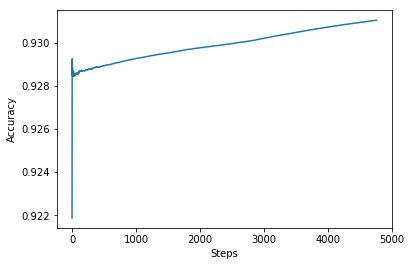

In [16]:

# TODO Display graph of data
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(performance_graph)

In [9]:

#TODO Eval Data
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
     
    sess.run(tf.local_variables_initializer())
     
    for image, label in zip(eval_imgs, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
     
    print(sess.run(cnn.accuracy))


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-99


KeyboardInterrupt: 

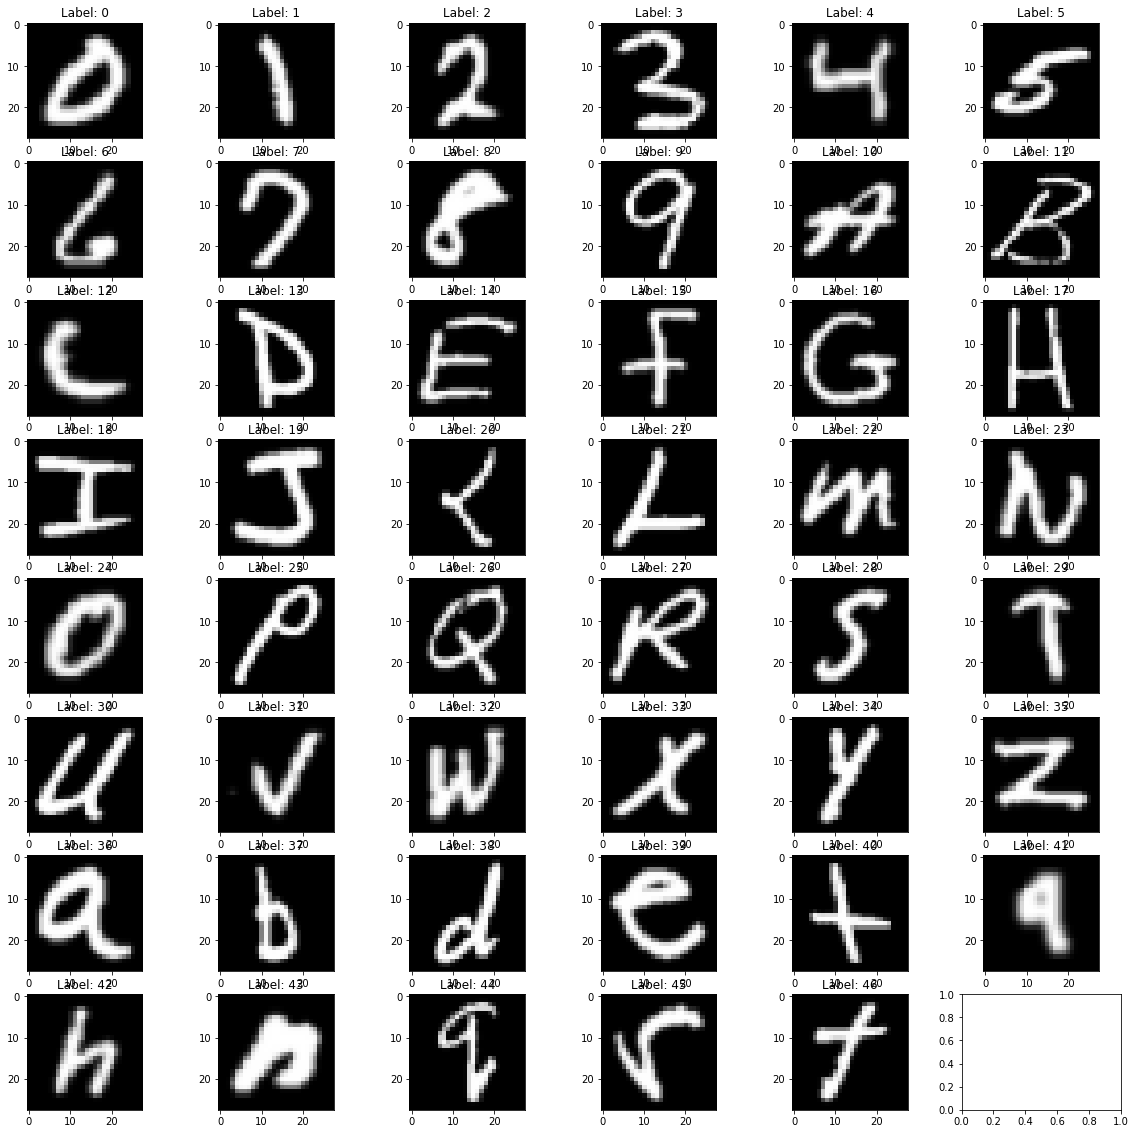

In [10]:
# TODO Get printout of each label
rows = 8
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.patch.set_facecolor('white')
image_count = 0

curr_label = 0
counter = 1

for idx, label in enumerate(train_labels):
    if label == curr_label:
        sub = plt.subplot(rows, cols, counter)
        img = train_data[idx]
        img = img.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        sub.set_title("Label: " + str(curr_label))
        curr_label += 1
        counter += 1

        

In [20]:
#TODO Change labels names
mydict = {}

for i in range(10):
    mydict[i] = str(i)
    
idx = 10
for j in range(65,91):
    mydict[idx] = chr(j)
    idx += 1

mydict[36] = "a"
mydict[37] = "b"
mydict[38] = "d"
mydict[39] = "e"
mydict[40] = "t"
mydict[41] = "q"
mydict[42] = "h"
mydict[43] = "n"
mydict[44] = "q"
mydict[45] = "r"
mydict[46] = "t"

print(mydict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 't', 41: 'q', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-999


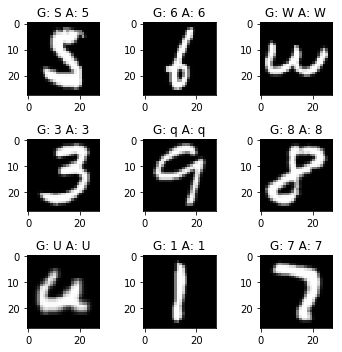

In [10]:
# TODO: Get a random set of images and make guesses for each
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    indexes = np.random.choice(len(train_data), 9, replace=False)
     
    rows = 3
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        img = train_data[idx]
        img = img.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[train_data[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()

In [17]:
# TODO: Take a picture with the webcam
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("test", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "./SampleLetters/opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()


./SampleLetters/opencv_frame_0.png written!


./SampleLetters/opencv_frame_1.png written!
./SampleLetters/opencv_frame_2.png written!


Escape hit, closing...


In [18]:
#TODO Run For webcam
new_img = []

for i in range(3):
    img = cv2.imread(f'./SampleLetters/opencv_frame_{i}.png', 0)

    res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    print(type(res))
    # res = np.expand_dims(res, axis=0)
    res = np.expand_dims(res, axis=2)
    # plt.imshow(res[0], cmap='gray')
    # plt.show()
    res = np.around(res, decimals=0)
    res = 1 - res
    print(res.shape)
    new_img.append(res)

new_imgs = np.asarray(new_img)
print(new_imgs.shape)


<class 'numpy.ndarray'>
(28, 28, 1)
<class 'numpy.ndarray'>
(28, 28, 1)
<class 'numpy.ndarray'>
(28, 28, 1)
(3, 28, 28, 1)


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-476000


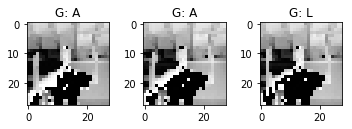

In [21]:
# TODO: Get webcam img and guess

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    # indexes = np.random.choice(len(new_imgs), 2, replace=False)
     
    rows = 1
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in range(3):
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        imgs = new_imgs[idx]
        img = imgs.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[new_imgs[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name)
        
    plt.tight_layout()


In [22]:
#Pixel
img = cv2.imread("./SampleLetters/Drawing.png", 0)

res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
print(type(res))
res = np.expand_dims(res, axis=0)
res = np.expand_dims(res, axis=3)
# plt.imshow(res[0], cmap='gray')
# plt.show()
res = np.around(res, decimals=0)
# res = 1 - res
print(res.shape)
# new_img.append(res)

# new_imgs = np.asarray(new_img)
# print(new_imgs.shape)

<class 'numpy.ndarray'>
(1, 28, 28, 1)


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-476000


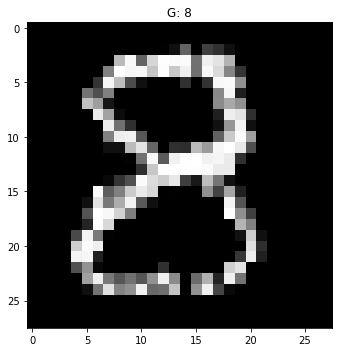

In [23]:
# TODO: Get webcam img and guess

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    # indexes = np.random.choice(len(new_imgs), 2, replace=False)
     
    rows = 1
    cols = 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in range(1):
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        imgs = res[idx]
        img = imgs.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[res[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name)
        
    plt.tight_layout()